In [67]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [68]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.initializers import GlorotNormal
import tensorflow.keras.initializers as inits
import matplotlib.pyplot as plt
from tensorflow.keras.activations import linear

In [76]:
def ForwardKinematics(q1,q2,q3, l1=1, l2=0.5, l3=0.25):
    #l1 = 1 
    #l2 = 0.5
    #l3 = 0.25

    #Forward Kinematics 
    X1 = l1*np.cos(q1)
    Y1 = l1*np.sin(q1) 

    X2 = X1 + l2*np.cos(q1+q2)
    Y2 = Y1 + l2*np.sin(q1+q2)

    Xe = X2 + l3*np.cos(q1+q2+q3)
    Ye = Y2 + l3*np.sin(q1+q2+q3)

    Q = q1+q2+q3;

    X0 = 0; 
    Y0 = 0;
    Xfk = [X0, X1, X2, Xe]
    Yfk = [Y0, Y1, Y2, Ye]
    
    return Xfk, Yfk, Q

In [152]:
def FKCheck(q1, q2, q3, modelname):

    # convert input joint angles to radians
    q1 = q1*(np.pi/180.0)
    q2 = q2*(np.pi/180.0)
    q3 = q3*(np.pi/180.0)

    #forward kinematics of chosen joint angles, this is the 'correct' configuration
    Xtru, Ytru, Q = ForwardKinematics(q1,q2,q3)

    # input to neural network is the coordinate found from forward kinematics for the chosen joint angles
    des = [[Xtru[3], Ytru[3], Q]]

    # after training the model, the current weights are used to make a prediction on the input
    ang = modelname.predict(des)

    # forward kinematics of model predicted joint angles 
    Xnn, Ynn, A = ForwardKinematics(ang[0][0], ang[0][1], ang[0][2])
    
    plt.plot(Xtru, Ytru)
    plt.plot(Xnn,Ynn)
    
    Error = np.sqrt((Xnn[3] - Xtru[3])**2 + (Ynn[3] - Ytru[3])**2)
    format_error = "{:.4f}".format(Error)
    print('End-Effector Error: ' + str(format_error))

# Read in Data produced in MATLAB

In [89]:
# import the input and target data produced from the forward kinematics in MATLAB 
x = []
target = []

# open text file with data to be analyzed
with open('inputRnd.txt','r') as file:
# reading each line    
    for line in file:
        # reading each word        
        for word in line.split():
            # append the data array with each word 
            x.append(word)

xtemp = np.reshape(x, (9261,3))
x = xtemp.astype(float)

# open text file with data to be analyzed
with open('targetRnd.txt','r') as file:
    # reading each line    
    for line in file:
        # reading each word        
        for word in line.split():
            # append the data array with each word 
            target.append(word)

target = np.reshape(target, (9261, 3))
y = target.astype(float)

# import the input and target data produced from the forward kinematics in MATLAB 
circInput = []

# open text file with data to be analyzed
with open('circInput.txt','r') as file:
# reading each line    
    for line in file:
        # reading each word        
        for word in line.split():
            # append the data array with each word 
            circInput.append(word)

xtemp = np.reshape(circInput, (25,3))
circ = xtemp.astype(float)

# Benchmark Model
This model uses the sigmoid activation function with normal random weight initialization and mean squared error loss function. It has 10 neurons in the single hidden layer. The activation function for the output layer is always a linear function.  

In [92]:
# model using the sequential class
modelBM = Sequential()

# random normal probability distribution for weight init
BMinit = inits.RandomNormal()

# add hidden layer with 10 neurons and output layer
modelBM.add(Dense(10, activation = 'sigmoid', input_shape = (3,), kernel_initializer = BMinit))
modelBM.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
modelBM.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.3), metrics = ['accuracy'])
# prints model summary to show model details
modelBM.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                40        
                                                                 
 dense_13 (Dense)            (None, 3)                 33        
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [93]:
# 75/25 train/validation data split 
# split training data set 
trainX, testX, trainY, testY = train_test_split(x, y,  test_size = 0.25, random_state = 1)

maxEpochs = 4000
batchSize = 128

H = modelBM.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Epoch 1/4000
55/55 [==============================] - 1s 5ms/step - loss: 0.5497 - accuracy: 0.8746 - val_loss: 0.3967 - val_accuracy: 0.8718
Epoch 2/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3587 - accuracy: 0.8936 - val_loss: 0.3446 - val_accuracy: 0.9020
Epoch 3/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3319 - accuracy: 0.9044 - val_loss: 0.3241 - val_accuracy: 0.9033
Epoch 4/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3145 - accuracy: 0.9057 - val_loss: 0.3108 - val_accuracy: 0.9003
Epoch 5/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.9041 - val_loss: 0.2971 - val_accuracy: 0.9020
Epoch 6/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2893 - accuracy: 0.9044 - val_loss: 0.2953 - val_accuracy: 0.9063
Epoch 7/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2771 - accuracy: 0.9048 - val_loss: 0.2711 - val_accuracy: 0.8977
Epoch 

55/55 [==============================] - 0s 2ms/step - loss: 0.0300 - accuracy: 0.9675 - val_loss: 0.0312 - val_accuracy: 0.9706
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9650 - val_loss: 0.0321 - val_accuracy: 0.9706
Epoch 117/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9654 - val_loss: 0.0345 - val_accuracy: 0.9620
Epoch 118/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.9685 - val_loss: 0.0307 - val_accuracy: 0.9706
Epoch 119/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9670 - val_loss: 0.0305 - val_accuracy: 0.9711
Epoch 120/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.9680 - val_loss: 0.0298 - val_accuracy: 0.9715
Epoch 121/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.9690 - val_loss: 0.0361 - val_accuracy: 0.9680
Epoch 1

Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.9716 - val_loss: 0.0272 - val_accuracy: 0.9741
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9705 - val_loss: 0.0264 - val_accuracy: 0.9711
Epoch 174/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0263 - accuracy: 0.9715 - val_loss: 0.0261 - val_accuracy: 0.9741
Epoch 175/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.9711 - val_loss: 0.0272 - val_accuracy: 0.9732
Epoch 176/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0263 - accuracy: 0.9706 - val_loss: 0.0265 - val_accuracy: 0.9698
Epoch 177/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9718 - val_loss: 0.0271 - val_accuracy: 0.9750
Epoch 178/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9709 - val_loss: 0.0260 - val_accuracy:

Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9724 - val_loss: 0.0275 - val_accuracy: 0.9689
Epoch 230/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9703 - val_loss: 0.0331 - val_accuracy: 0.9732
Epoch 231/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0256 - accuracy: 0.9719 - val_loss: 0.0287 - val_accuracy: 0.9728
Epoch 232/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9709 - val_loss: 0.0366 - val_accuracy: 0.9715
Epoch 233/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.9703 - val_loss: 0.0250 - val_accuracy: 0.9732
Epoch 234/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9696 - val_loss: 0.0259 - val_accuracy: 0.9724
Epoch 235/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0256 - accuracy: 0.9708 - val_loss: 0.0267 - val_accuracy:

Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.9693 - val_loss: 0.0256 - val_accuracy: 0.9724
Epoch 287/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9712 - val_loss: 0.0247 - val_accuracy: 0.9754
Epoch 288/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9709 - val_loss: 0.0251 - val_accuracy: 0.9702
Epoch 289/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9715 - val_loss: 0.0290 - val_accuracy: 0.9754
Epoch 290/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9715 - val_loss: 0.0244 - val_accuracy: 0.9745
Epoch 291/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9701 - val_loss: 0.0250 - val_accuracy: 0.9737
Epoch 292/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9711 - val_loss: 0.0297 - val_accuracy:

Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9719 - val_loss: 0.0242 - val_accuracy: 0.9741
Epoch 344/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9705 - val_loss: 0.0238 - val_accuracy: 0.9741
Epoch 345/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9715 - val_loss: 0.0253 - val_accuracy: 0.9724
Epoch 346/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9708 - val_loss: 0.0274 - val_accuracy: 0.9680
Epoch 347/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9701 - val_loss: 0.0244 - val_accuracy: 0.9724
Epoch 348/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9699 - val_loss: 0.0238 - val_accuracy: 0.9745
Epoch 349/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9709 - val_loss: 0.0247 - val_accuracy:

Epoch 400/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9696 - val_loss: 0.0249 - val_accuracy: 0.9719
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.9712 - val_loss: 0.0363 - val_accuracy: 0.9676
Epoch 402/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.9706 - val_loss: 0.0250 - val_accuracy: 0.9724
Epoch 403/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9708 - val_loss: 0.0288 - val_accuracy: 0.9732
Epoch 404/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9711 - val_loss: 0.0372 - val_accuracy: 0.9745
Epoch 405/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9719 - val_loss: 0.0286 - val_accuracy: 0.9750
Epoch 406/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9713 - val_loss: 0.0254 - val_accuracy:

Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9706 - val_loss: 0.0239 - val_accuracy: 0.9732
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.9713 - val_loss: 0.0222 - val_accuracy: 0.9741
Epoch 459/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9703 - val_loss: 0.0221 - val_accuracy: 0.9732
Epoch 460/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 0.9692 - val_loss: 0.0287 - val_accuracy: 0.9745
Epoch 461/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 0.9689 - val_loss: 0.0253 - val_accuracy: 0.9702
Epoch 462/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9722 - val_loss: 0.0258 - val_accuracy: 0.9728
Epoch 463/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9699 - val_loss: 0.0223 - val_accuracy:

Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0291 - accuracy: 0.9715 - val_loss: 0.0219 - val_accuracy: 0.9741
Epoch 515/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9702 - val_loss: 0.0228 - val_accuracy: 0.9745
Epoch 516/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9682 - val_loss: 0.0290 - val_accuracy: 0.9668
Epoch 517/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0271 - accuracy: 0.9698 - val_loss: 0.0287 - val_accuracy: 0.9711
Epoch 518/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9709 - val_loss: 0.0240 - val_accuracy: 0.9750
Epoch 519/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 0.9689 - val_loss: 0.0266 - val_accuracy: 0.9663
Epoch 520/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9724 - val_loss: 0.0298 - val_accuracy:

Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9724 - val_loss: 0.0278 - val_accuracy: 0.9672
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9716 - val_loss: 0.0226 - val_accuracy: 0.9715
Epoch 573/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9719 - val_loss: 0.0216 - val_accuracy: 0.9732
Epoch 574/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9724 - val_loss: 0.0232 - val_accuracy: 0.9745
Epoch 575/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9728 - val_loss: 0.0216 - val_accuracy: 0.9754
Epoch 576/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 0.9726 - val_loss: 0.0223 - val_accuracy: 0.9728
Epoch 577/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9699 - val_loss: 0.0264 - val_accuracy:

Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9673 - val_loss: 0.0303 - val_accuracy: 0.9642
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.9709 - val_loss: 0.0240 - val_accuracy: 0.9758
Epoch 630/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.9713 - val_loss: 0.0244 - val_accuracy: 0.9754
Epoch 631/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9702 - val_loss: 0.0213 - val_accuracy: 0.9767
Epoch 632/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9709 - val_loss: 0.0215 - val_accuracy: 0.9754
Epoch 633/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.9712 - val_loss: 0.0325 - val_accuracy: 0.9680
Epoch 634/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0237 - accuracy: 0.9716 - val_loss: 0.0228 - val_accuracy:

Epoch 685/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9652 - val_loss: 0.0231 - val_accuracy: 0.9711
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9695 - val_loss: 0.0214 - val_accuracy: 0.9780
Epoch 687/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9729 - val_loss: 0.0253 - val_accuracy: 0.9741
Epoch 688/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0424 - accuracy: 0.9631 - val_loss: 0.0272 - val_accuracy: 0.9754
Epoch 689/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9711 - val_loss: 0.0375 - val_accuracy: 0.9611
Epoch 690/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9688 - val_loss: 0.0239 - val_accuracy: 0.9775
Epoch 691/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.9683 - val_loss: 0.0259 - val_accuracy:

Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9703 - val_loss: 0.0216 - val_accuracy: 0.9719
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9722 - val_loss: 0.0327 - val_accuracy: 0.9741
Epoch 744/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9698 - val_loss: 0.0228 - val_accuracy: 0.9715
Epoch 745/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9724 - val_loss: 0.0227 - val_accuracy: 0.9780
Epoch 746/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9735 - val_loss: 0.0210 - val_accuracy: 0.9767
Epoch 747/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0272 - accuracy: 0.9686 - val_loss: 0.0546 - val_accuracy: 0.9447
Epoch 748/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9715 - val_loss: 0.0328 - val_accuracy:

Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0256 - accuracy: 0.9708 - val_loss: 0.0206 - val_accuracy: 0.9754
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9742 - val_loss: 0.0221 - val_accuracy: 0.9737
Epoch 801/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9726 - val_loss: 0.0228 - val_accuracy: 0.9711
Epoch 802/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9728 - val_loss: 0.0342 - val_accuracy: 0.9715
Epoch 803/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9670 - val_loss: 0.0212 - val_accuracy: 0.9728
Epoch 804/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9709 - val_loss: 0.0221 - val_accuracy: 0.9732
Epoch 805/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9721 - val_loss: 0.0297 - val_accuracy:

Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9680 - val_loss: 0.0306 - val_accuracy: 0.9650
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9673 - val_loss: 0.0214 - val_accuracy: 0.9767
Epoch 858/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9712 - val_loss: 0.0297 - val_accuracy: 0.9750
Epoch 859/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9715 - val_loss: 0.0203 - val_accuracy: 0.9758
Epoch 860/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9672 - val_loss: 0.0226 - val_accuracy: 0.9741
Epoch 861/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9731 - val_loss: 0.0300 - val_accuracy: 0.9758
Epoch 862/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9670 - val_loss: 0.0383 - val_accuracy:

Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9719 - val_loss: 0.0213 - val_accuracy: 0.9763
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9726 - val_loss: 0.0236 - val_accuracy: 0.9719
Epoch 915/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9716 - val_loss: 0.0362 - val_accuracy: 0.9702
Epoch 916/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9715 - val_loss: 0.0222 - val_accuracy: 0.9715
Epoch 917/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.9652 - val_loss: 0.0359 - val_accuracy: 0.9633
Epoch 918/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9711 - val_loss: 0.0231 - val_accuracy: 0.9775
Epoch 919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9729 - val_loss: 0.0219 - val_accuracy:

Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9663 - val_loss: 0.0218 - val_accuracy: 0.9719
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9712 - val_loss: 0.0248 - val_accuracy: 0.9741
Epoch 972/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9721 - val_loss: 0.0266 - val_accuracy: 0.9763
Epoch 973/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9702 - val_loss: 0.0255 - val_accuracy: 0.9745
Epoch 974/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9724 - val_loss: 0.0212 - val_accuracy: 0.9732
Epoch 975/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9706 - val_loss: 0.0203 - val_accuracy: 0.9767
Epoch 976/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9729 - val_loss: 0.0260 - val_accuracy:

Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9738 - val_loss: 0.0576 - val_accuracy: 0.9668
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9683 - val_loss: 0.0333 - val_accuracy: 0.9711
Epoch 1029/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9696 - val_loss: 0.0623 - val_accuracy: 0.9542
Epoch 1030/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9677 - val_loss: 0.0219 - val_accuracy: 0.9728
Epoch 1031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9711 - val_loss: 0.0390 - val_accuracy: 0.9659
Epoch 1032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9677 - val_loss: 0.0266 - val_accuracy: 0.9728
Epoch 1033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9724 - val_loss: 0.0302 - val_ac

55/55 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9613 - val_loss: 0.0216 - val_accuracy: 0.9767
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9657 - val_loss: 0.0294 - val_accuracy: 0.9767
Epoch 1141/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9731 - val_loss: 0.0247 - val_accuracy: 0.9763
Epoch 1142/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.9705 - val_loss: 0.0254 - val_accuracy: 0.9676
Epoch 1143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9683 - val_loss: 0.0297 - val_accuracy: 0.9780
Epoch 1144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0256 - accuracy: 0.9686 - val_loss: 0.0262 - val_accuracy: 0.9745
Epoch 1145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0282 - accuracy: 0.9702 - val_loss: 0.0215 - val_accuracy: 0.9767
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9711 - val_loss: 0.0368 - val_accuracy: 0.9715
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9702 - val_loss: 0.0260 - val_accuracy: 0.9763
Epoch 1253/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.9702 - val_loss: 0.0206 - val_accuracy: 0.9754
Epoch 1254/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0370 - accuracy: 0.9623 - val_loss: 0.0224 - val_accuracy: 0.9724
Epoch 1255/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9725 - val_loss: 0.0269 - val_accuracy: 0.9676
Epoch 1256/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 0.9718 - val_loss: 0.0327 - val_accuracy: 0.9698
Epoch 1257/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9725 - val_loss: 0.0227 - val_accuracy: 0.9741
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 0.9686 - val_loss: 0.0667 - val_accuracy: 0.9564
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0369 - accuracy: 0.9630 - val_loss: 0.0224 - val_accuracy: 0.9780
Epoch 1365/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9699 - val_loss: 0.0221 - val_accuracy: 0.9780
Epoch 1366/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9705 - val_loss: 0.0247 - val_accuracy: 0.9767
Epoch 1367/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9659 - val_loss: 0.0265 - val_accuracy: 0.9715
Epoch 1368/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9726 - val_loss: 0.0301 - val_accuracy: 0.9754
Epoch 1369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9695 - val_loss: 0.0211 - val_accuracy: 0.9732
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9689 - val_loss: 0.0473 - val_accuracy: 0.9616
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.9726 - val_loss: 0.0325 - val_accuracy: 0.9750
Epoch 1477/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9705 - val_loss: 0.0199 - val_accuracy: 0.9758
Epoch 1478/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9728 - val_loss: 0.0227 - val_accuracy: 0.9780
Epoch 1479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.9706 - val_loss: 0.0386 - val_accuracy: 0.9668
Epoch 1480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9712 - val_loss: 0.0195 - val_accuracy: 0.9788
Epoch 1481/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.9755 - val_loss: 0.0245 - val_accuracy: 0.9771
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.9708 - val_loss: 0.0403 - val_accuracy: 0.9642
Epoch 1588/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0261 - accuracy: 0.9724 - val_loss: 0.0253 - val_accuracy: 0.9788
Epoch 1589/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.9708 - val_loss: 0.0374 - val_accuracy: 0.9702
Epoch 1590/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9726 - val_loss: 0.0245 - val_accuracy: 0.9763
Epoch 1591/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 0.9741 - val_loss: 0.0267 - val_accuracy: 0.9767
Epoch 1592/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9726 - val_loss: 0.0190 - val_accuracy: 0.9788
Epoch 1593/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9713 - val_loss: 0.0234 - val_accuracy: 0.9771
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9744 - val_loss: 0.0205 - val_accuracy: 0.9780
Epoch 1700/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0237 - accuracy: 0.9725 - val_loss: 0.0427 - val_accuracy: 0.9650
Epoch 1701/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9701 - val_loss: 0.0190 - val_accuracy: 0.9788
Epoch 1702/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9754 - val_loss: 0.0225 - val_accuracy: 0.9801
Epoch 1703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9721 - val_loss: 0.0218 - val_accuracy: 0.9793
Epoch 1704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9698 - val_loss: 0.0638 - val_accuracy: 0.9456
Epoch 1705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9737 - val_loss: 0.0208 - val_accuracy: 0.9801
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.9744 - val_loss: 0.0188 - val_accuracy: 0.9788
Epoch 1812/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0255 - accuracy: 0.9711 - val_loss: 0.0301 - val_accuracy: 0.9672
Epoch 1813/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9711 - val_loss: 0.0267 - val_accuracy: 0.9728
Epoch 1814/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9742 - val_loss: 0.0206 - val_accuracy: 0.9801
Epoch 1815/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 0.9747 - val_loss: 0.0221 - val_accuracy: 0.9797
Epoch 1816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9742 - val_loss: 0.0308 - val_accuracy: 0.9689
Epoch 1817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9729 - val_loss: 0.0188 - val_accuracy: 0.9788
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9702 - val_loss: 0.0185 - val_accuracy: 0.9797
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9735 - val_loss: 0.0227 - val_accuracy: 0.9788
Epoch 1925/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9745 - val_loss: 0.0379 - val_accuracy: 0.9698
Epoch 1926/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9738 - val_loss: 0.0193 - val_accuracy: 0.9797
Epoch 1927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9702 - val_loss: 0.0360 - val_accuracy: 0.9750
Epoch 1928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9670 - val_loss: 0.0211 - val_accuracy: 0.9771
Epoch 1929/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9757 - val_loss: 0.0240 - val_accuracy: 0.9728
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9712 - val_loss: 0.0303 - val_accuracy: 0.9771
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0425 - accuracy: 0.9618 - val_loss: 0.0630 - val_accuracy: 0.9603
Epoch 2037/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.9726 - val_loss: 0.0197 - val_accuracy: 0.9801
Epoch 2038/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9741 - val_loss: 0.0309 - val_accuracy: 0.9706
Epoch 2039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9747 - val_loss: 0.0187 - val_accuracy: 0.9806
Epoch 2040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9741 - val_loss: 0.0348 - val_accuracy: 0.9629
Epoch 2041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9754 - val_loss: 0.0202 - val_accuracy: 0.9797
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9738 - val_loss: 0.0192 - val_accuracy: 0.9754
Epoch 2148/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9754 - val_loss: 0.0334 - val_accuracy: 0.9711
Epoch 2149/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.9748 - val_loss: 0.0188 - val_accuracy: 0.9793
Epoch 2150/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.9758 - val_loss: 0.0188 - val_accuracy: 0.9784
Epoch 2151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9771 - val_loss: 0.0224 - val_accuracy: 0.9750
Epoch 2152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9738 - val_loss: 0.0214 - val_accuracy: 0.9810
Epoch 2153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9708 - val_loss: 0.0198 - val_accuracy: 0.9797
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9701 - val_loss: 0.0406 - val_accuracy: 0.9624
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9725 - val_loss: 0.0199 - val_accuracy: 0.9801
Epoch 2261/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9729 - val_loss: 0.0256 - val_accuracy: 0.9689
Epoch 2262/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9765 - val_loss: 0.0185 - val_accuracy: 0.9775
Epoch 2263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9744 - val_loss: 0.0187 - val_accuracy: 0.9767
Epoch 2264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9768 - val_loss: 0.0271 - val_accuracy: 0.9784
Epoch 2265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9765 - val_loss: 0.0191 - val_accuracy: 0.9784
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9713 - val_loss: 0.0489 - val_accuracy: 0.9585
Epoch 2372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0418 - accuracy: 0.9654 - val_loss: 0.0209 - val_accuracy: 0.9771
Epoch 2373/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9775 - val_loss: 0.0213 - val_accuracy: 0.9793
Epoch 2374/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9768 - val_loss: 0.0237 - val_accuracy: 0.9711
Epoch 2375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9762 - val_loss: 0.0190 - val_accuracy: 0.9771
Epoch 2376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9777 - val_loss: 0.0200 - val_accuracy: 0.9771
Epoch 2377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9732 - val_loss: 0.0287 - val_accuracy: 0.9806
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9741 - val_loss: 0.0184 - val_accuracy: 0.9775
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9761 - val_loss: 0.0173 - val_accuracy: 0.9793
Epoch 2485/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0233 - accuracy: 0.9744 - val_loss: 0.0564 - val_accuracy: 0.9585
Epoch 2486/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9729 - val_loss: 0.0217 - val_accuracy: 0.9784
Epoch 2487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9732 - val_loss: 0.0309 - val_accuracy: 0.9650
Epoch 2488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 0.9744 - val_loss: 0.0456 - val_accuracy: 0.9668
Epoch 2489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9728 - val_loss: 0.0229 - val_accuracy: 0.9745
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9744 - val_loss: 0.0177 - val_accuracy: 0.9784
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9764 - val_loss: 0.0319 - val_accuracy: 0.9668
Epoch 2597/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9742 - val_loss: 0.0380 - val_accuracy: 0.9706
Epoch 2598/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9722 - val_loss: 0.0179 - val_accuracy: 0.9775
Epoch 2599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9732 - val_loss: 0.0225 - val_accuracy: 0.9780
Epoch 2600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9741 - val_loss: 0.0191 - val_accuracy: 0.9793
Epoch 2601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9752 - val_loss: 0.0205 - val_accuracy: 0.9780
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9762 - val_loss: 0.0205 - val_accuracy: 0.9788
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9767 - val_loss: 0.0209 - val_accuracy: 0.9780
Epoch 2709/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9699 - val_loss: 0.0186 - val_accuracy: 0.9797
Epoch 2710/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9762 - val_loss: 0.0173 - val_accuracy: 0.9780
Epoch 2711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9729 - val_loss: 0.0207 - val_accuracy: 0.9771
Epoch 2712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9777 - val_loss: 0.0184 - val_accuracy: 0.9775
Epoch 2713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9757 - val_loss: 0.0317 - val_accuracy: 0.9758
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9729 - val_loss: 0.0172 - val_accuracy: 0.9793
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9737 - val_loss: 0.0181 - val_accuracy: 0.9775
Epoch 2821/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9768 - val_loss: 0.0207 - val_accuracy: 0.9780
Epoch 2822/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9768 - val_loss: 0.0184 - val_accuracy: 0.9784
Epoch 2823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9771 - val_loss: 0.0229 - val_accuracy: 0.9788
Epoch 2824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9728 - val_loss: 0.0310 - val_accuracy: 0.9689
Epoch 2825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0481 - accuracy: 0.9613 - val_loss: 0.0180 - val_accuracy: 0.9771
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 0.9742 - val_loss: 0.0205 - val_accuracy: 0.9784
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9787 - val_loss: 0.0183 - val_accuracy: 0.9771
Epoch 2933/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0344 - accuracy: 0.9711 - val_loss: 0.0418 - val_accuracy: 0.9642
Epoch 2934/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9745 - val_loss: 0.0213 - val_accuracy: 0.9788
Epoch 2935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9772 - val_loss: 0.0280 - val_accuracy: 0.9663
Epoch 2936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9709 - val_loss: 0.0208 - val_accuracy: 0.9780
Epoch 2937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9749 - val_loss: 0.0232 - val_accuracy: 0.9775
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 0.9771 - val_loss: 0.0192 - val_accuracy: 0.9771
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9721 - val_loss: 0.0271 - val_accuracy: 0.9780
Epoch 3045/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9726 - val_loss: 0.0244 - val_accuracy: 0.9724
Epoch 3046/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 0.9768 - val_loss: 0.0183 - val_accuracy: 0.9780
Epoch 3047/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9735 - val_loss: 0.0349 - val_accuracy: 0.9754
Epoch 3048/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0492 - accuracy: 0.9624 - val_loss: 0.0290 - val_accuracy: 0.9758
Epoch 3049/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9738 - val_loss: 0.0186 - val_accuracy: 0.9780
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9761 - val_loss: 0.0211 - val_accuracy: 0.9711
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9757 - val_loss: 0.0175 - val_accuracy: 0.9780
Epoch 3157/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0446 - accuracy: 0.9670 - val_loss: 0.0435 - val_accuracy: 0.9685
Epoch 3158/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9680 - val_loss: 0.0269 - val_accuracy: 0.9763
Epoch 3159/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9751 - val_loss: 0.0203 - val_accuracy: 0.9750
Epoch 3160/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9752 - val_loss: 0.0256 - val_accuracy: 0.9788
Epoch 3161/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9725 - val_loss: 0.0253 - val_accuracy: 0.9780
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9744 - val_loss: 0.0186 - val_accuracy: 0.9797
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9721 - val_loss: 0.0644 - val_accuracy: 0.9585
Epoch 3269/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9713 - val_loss: 0.0405 - val_accuracy: 0.9650
Epoch 3270/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9706 - val_loss: 0.0320 - val_accuracy: 0.9633
Epoch 3271/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9761 - val_loss: 0.0201 - val_accuracy: 0.9728
Epoch 3272/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9764 - val_loss: 0.0204 - val_accuracy: 0.9758
Epoch 3273/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9764 - val_loss: 0.0189 - val_accuracy: 0.9775
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9724 - val_loss: 0.0335 - val_accuracy: 0.9728
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9702 - val_loss: 0.0185 - val_accuracy: 0.9780
Epoch 3381/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9765 - val_loss: 0.0260 - val_accuracy: 0.9693
Epoch 3382/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9744 - val_loss: 0.0195 - val_accuracy: 0.9771
Epoch 3383/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9685 - val_loss: 0.0642 - val_accuracy: 0.9659
Epoch 3384/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9724 - val_loss: 0.0231 - val_accuracy: 0.9719
Epoch 3385/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9734 - val_loss: 0.0420 - val_accuracy: 0.9715
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.9749 - val_loss: 0.0317 - val_accuracy: 0.9676
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.9706 - val_loss: 0.0228 - val_accuracy: 0.9793
Epoch 3493/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9777 - val_loss: 0.0200 - val_accuracy: 0.9741
Epoch 3494/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9742 - val_loss: 0.0198 - val_accuracy: 0.9775
Epoch 3495/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9718 - val_loss: 0.0213 - val_accuracy: 0.9780
Epoch 3496/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9757 - val_loss: 0.0226 - val_accuracy: 0.9767
Epoch 3497/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9768 - val_loss: 0.0180 - val_accuracy: 0.9763
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0401 - accuracy: 0.9690 - val_loss: 0.0178 - val_accuracy: 0.9767
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9688 - val_loss: 0.0214 - val_accuracy: 0.9732
Epoch 3605/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9771 - val_loss: 0.0339 - val_accuracy: 0.9607
Epoch 3606/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9739 - val_loss: 0.0230 - val_accuracy: 0.9767
Epoch 3607/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9741 - val_loss: 0.0188 - val_accuracy: 0.9754
Epoch 3608/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.9721 - val_loss: 0.0838 - val_accuracy: 0.9473
Epoch 3609/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.9686 - val_loss: 0.0172 - val_accuracy: 0.9775
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9751 - val_loss: 0.0208 - val_accuracy: 0.9728
Epoch 3716/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9751 - val_loss: 0.0310 - val_accuracy: 0.9560
Epoch 3717/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9698 - val_loss: 0.0207 - val_accuracy: 0.9784
Epoch 3718/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9760 - val_loss: 0.0201 - val_accuracy: 0.9775
Epoch 3719/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 0.9742 - val_loss: 0.0378 - val_accuracy: 0.9741
Epoch 3720/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9741 - val_loss: 0.0180 - val_accuracy: 0.9771
Epoch 3721/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9721 - val_loss: 0.0787 - val_accuracy: 0.9577
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9757 - val_loss: 0.0175 - val_accuracy: 0.9771
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0191 - accuracy: 0.9772 - val_loss: 0.0175 - val_accuracy: 0.9784
Epoch 3829/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9758 - val_loss: 0.0235 - val_accuracy: 0.9780
Epoch 3830/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9719 - val_loss: 0.0299 - val_accuracy: 0.9775
Epoch 3831/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9747 - val_loss: 0.0172 - val_accuracy: 0.9784
Epoch 3832/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.9715 - val_loss: 0.0181 - val_accuracy: 0.9793
Epoch 3833/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9774 - val_loss: 0.0174 - val_accuracy: 0.9784
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9702 - val_loss: 0.0629 - val_accuracy: 0.9633
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9734 - val_loss: 0.0312 - val_accuracy: 0.9698
Epoch 3941/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9709 - val_loss: 0.0191 - val_accuracy: 0.9763
Epoch 3942/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9762 - val_loss: 0.0183 - val_accuracy: 0.9775
Epoch 3943/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.9749 - val_loss: 0.0215 - val_accuracy: 0.9737
Epoch 3944/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9709 - val_loss: 0.0245 - val_accuracy: 0.9780
Epoch 3945/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9751 - val_loss: 0.0196 - val_accuracy: 0.9780
E

# Plotting the Performance of the Benchmark Model

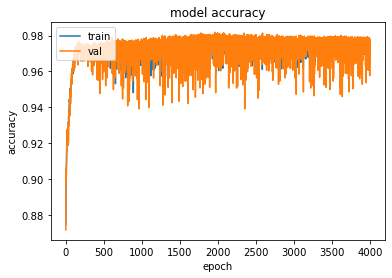

In [94]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The accuracy oscillates quite significantly after a few hundred epochs so decreasing the learning rate should help alleviate that. However, the accuracy is in the mid to upper 90's for the training and validation accuracy which is very suprising for such a small network. The original plan was to use a hidden layer with 100 neurons but it may be possible to acheive satisfactory performance with a relatively small network.  

The model is recompiled from scratch with the same weight init method in order to understand the effect of decreasing the learning rate. 

In [101]:
# model using the sequential class
modelBM = Sequential()

# random normal probability distribution for weight init
BMinit = inits.RandomNormal()

# add hidden layer with 10 neurons and output layer
modelBM.add(Dense(10, activation = 'sigmoid', input_shape = (3,), kernel_initializer = BMinit))
modelBM.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
modelBM.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.1), metrics = ['accuracy'])
# prints model summary to show model details
modelBM.summary()

H = modelBM.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 10)                40        
                                                                 
 dense_17 (Dense)            (None, 3)                 33        
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
55/55 [==============================] - 1s 5ms/step - loss: 0.7075 - accuracy: 0.8746 - val_loss: 0.5040 - val_accuracy: 0.8718
Epoch 2/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.4640 - accuracy: 0.8746 - val_loss: 0.4300 - val_accuracy: 0.8718
Epoch 3/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.4096 - accuracy: 0.8746 - val_loss: 0.3899 - val_accuracy: 0.8718
Epoch 4/4000
55/55 [=======

55/55 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9525 - val_loss: 0.0616 - val_accuracy: 0.9525
Epoch 111/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0619 - accuracy: 0.9533 - val_loss: 0.0608 - val_accuracy: 0.9521
Epoch 112/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9532 - val_loss: 0.0605 - val_accuracy: 0.9525
Epoch 113/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0607 - accuracy: 0.9551 - val_loss: 0.0598 - val_accuracy: 0.9534
Epoch 114/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0603 - accuracy: 0.9554 - val_loss: 0.0594 - val_accuracy: 0.9542
Epoch 115/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0597 - accuracy: 0.9555 - val_loss: 0.0589 - val_accuracy: 0.9560
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0593 - accuracy: 0.9567 - val_loss: 0.0584 - val_accuracy: 0.9560
Epoch 1

Epoch 167/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0449 - accuracy: 0.9641 - val_loss: 0.0445 - val_accuracy: 0.9680
Epoch 168/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.9643 - val_loss: 0.0444 - val_accuracy: 0.9680
Epoch 169/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0446 - accuracy: 0.9649 - val_loss: 0.0442 - val_accuracy: 0.9689
Epoch 170/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0445 - accuracy: 0.9639 - val_loss: 0.0447 - val_accuracy: 0.9689
Epoch 171/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9649 - val_loss: 0.0438 - val_accuracy: 0.9680
Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9650 - val_loss: 0.0436 - val_accuracy: 0.9698
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0439 - accuracy: 0.9654 - val_loss: 0.0438 - val_accuracy:

Epoch 224/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9663 - val_loss: 0.0377 - val_accuracy: 0.9693
Epoch 225/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0378 - accuracy: 0.9665 - val_loss: 0.0377 - val_accuracy: 0.9689
Epoch 226/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9667 - val_loss: 0.0382 - val_accuracy: 0.9689
Epoch 227/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9663 - val_loss: 0.0373 - val_accuracy: 0.9693
Epoch 228/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9660 - val_loss: 0.0378 - val_accuracy: 0.9685
Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9670 - val_loss: 0.0373 - val_accuracy: 0.9702
Epoch 230/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9672 - val_loss: 0.0379 - val_accuracy:

Epoch 281/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9667 - val_loss: 0.0336 - val_accuracy: 0.9685
Epoch 282/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9665 - val_loss: 0.0339 - val_accuracy: 0.9676
Epoch 283/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.9665 - val_loss: 0.0336 - val_accuracy: 0.9693
Epoch 284/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9659 - val_loss: 0.0340 - val_accuracy: 0.9680
Epoch 285/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9669 - val_loss: 0.0339 - val_accuracy: 0.9689
Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9666 - val_loss: 0.0337 - val_accuracy: 0.9680
Epoch 287/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9669 - val_loss: 0.0335 - val_accuracy:

Epoch 338/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9676 - val_loss: 0.0312 - val_accuracy: 0.9719
Epoch 339/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9675 - val_loss: 0.0312 - val_accuracy: 0.9706
Epoch 340/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.9672 - val_loss: 0.0307 - val_accuracy: 0.9719
Epoch 341/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9672 - val_loss: 0.0307 - val_accuracy: 0.9724
Epoch 342/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9675 - val_loss: 0.0311 - val_accuracy: 0.9706
Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9677 - val_loss: 0.0312 - val_accuracy: 0.9706
Epoch 344/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9675 - val_loss: 0.0306 - val_accuracy:

Epoch 395/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9690 - val_loss: 0.0286 - val_accuracy: 0.9728
Epoch 396/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9693 - val_loss: 0.0288 - val_accuracy: 0.9724
Epoch 397/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9698 - val_loss: 0.0286 - val_accuracy: 0.9741
Epoch 398/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9695 - val_loss: 0.0287 - val_accuracy: 0.9732
Epoch 399/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9698 - val_loss: 0.0286 - val_accuracy: 0.9741
Epoch 400/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9696 - val_loss: 0.0289 - val_accuracy: 0.9737
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9689 - val_loss: 0.0291 - val_accuracy:

Epoch 452/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9696 - val_loss: 0.0277 - val_accuracy: 0.9737
Epoch 453/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9709 - val_loss: 0.0271 - val_accuracy: 0.9745
Epoch 454/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9703 - val_loss: 0.0272 - val_accuracy: 0.9750
Epoch 455/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9699 - val_loss: 0.0272 - val_accuracy: 0.9750
Epoch 456/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9698 - val_loss: 0.0270 - val_accuracy: 0.9745
Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9706 - val_loss: 0.0275 - val_accuracy: 0.9732
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.9702 - val_loss: 0.0270 - val_accuracy:

Epoch 509/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9725 - val_loss: 0.0258 - val_accuracy: 0.9754
Epoch 510/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9716 - val_loss: 0.0258 - val_accuracy: 0.9750
Epoch 511/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9722 - val_loss: 0.0261 - val_accuracy: 0.9754
Epoch 512/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9719 - val_loss: 0.0258 - val_accuracy: 0.9745
Epoch 513/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9716 - val_loss: 0.0260 - val_accuracy: 0.9758
Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9719 - val_loss: 0.0260 - val_accuracy: 0.9745
Epoch 515/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9721 - val_loss: 0.0263 - val_accuracy:

Epoch 566/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9737 - val_loss: 0.0251 - val_accuracy: 0.9767
Epoch 567/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9738 - val_loss: 0.0251 - val_accuracy: 0.9771
Epoch 568/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9729 - val_loss: 0.0250 - val_accuracy: 0.9767
Epoch 569/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9728 - val_loss: 0.0250 - val_accuracy: 0.9763
Epoch 570/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9728 - val_loss: 0.0250 - val_accuracy: 0.9763
Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.9744 - val_loss: 0.0248 - val_accuracy: 0.9758
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.9731 - val_loss: 0.0250 - val_accuracy:

Epoch 623/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9748 - val_loss: 0.0243 - val_accuracy: 0.9767
Epoch 624/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9739 - val_loss: 0.0252 - val_accuracy: 0.9771
Epoch 625/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9764 - val_loss: 0.0243 - val_accuracy: 0.9771
Epoch 626/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9747 - val_loss: 0.0242 - val_accuracy: 0.9775
Epoch 627/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9751 - val_loss: 0.0242 - val_accuracy: 0.9771
Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9747 - val_loss: 0.0257 - val_accuracy: 0.9763
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 0.9761 - val_loss: 0.0244 - val_accuracy:

Epoch 680/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9761 - val_loss: 0.0240 - val_accuracy: 0.9775
Epoch 681/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9764 - val_loss: 0.0238 - val_accuracy: 0.9780
Epoch 682/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9761 - val_loss: 0.0238 - val_accuracy: 0.9788
Epoch 683/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9761 - val_loss: 0.0237 - val_accuracy: 0.9780
Epoch 684/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9760 - val_loss: 0.0243 - val_accuracy: 0.9780
Epoch 685/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9758 - val_loss: 0.0241 - val_accuracy: 0.9775
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9767 - val_loss: 0.0238 - val_accuracy:

Epoch 737/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9765 - val_loss: 0.0233 - val_accuracy: 0.9788
Epoch 738/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9761 - val_loss: 0.0235 - val_accuracy: 0.9780
Epoch 739/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9755 - val_loss: 0.0235 - val_accuracy: 0.9784
Epoch 740/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9767 - val_loss: 0.0234 - val_accuracy: 0.9780
Epoch 741/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9772 - val_loss: 0.0233 - val_accuracy: 0.9780
Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9762 - val_loss: 0.0235 - val_accuracy: 0.9784
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9761 - val_loss: 0.0236 - val_accuracy:

Epoch 794/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 0.9767 - val_loss: 0.0231 - val_accuracy: 0.9797
Epoch 795/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9760 - val_loss: 0.0251 - val_accuracy: 0.9775
Epoch 796/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 0.9765 - val_loss: 0.0229 - val_accuracy: 0.9793
Epoch 797/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9758 - val_loss: 0.0229 - val_accuracy: 0.9784
Epoch 798/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9765 - val_loss: 0.0233 - val_accuracy: 0.9780
Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9765 - val_loss: 0.0233 - val_accuracy: 0.9771
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.9770 - val_loss: 0.0231 - val_accuracy:

Epoch 851/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9757 - val_loss: 0.0228 - val_accuracy: 0.9784
Epoch 852/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9761 - val_loss: 0.0228 - val_accuracy: 0.9788
Epoch 853/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9755 - val_loss: 0.0227 - val_accuracy: 0.9775
Epoch 854/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9760 - val_loss: 0.0226 - val_accuracy: 0.9784
Epoch 855/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9761 - val_loss: 0.0228 - val_accuracy: 0.9793
Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9757 - val_loss: 0.0236 - val_accuracy: 0.9767
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9752 - val_loss: 0.0227 - val_accuracy:

Epoch 908/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9760 - val_loss: 0.0224 - val_accuracy: 0.9784
Epoch 909/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9755 - val_loss: 0.0231 - val_accuracy: 0.9763
Epoch 910/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9757 - val_loss: 0.0227 - val_accuracy: 0.9771
Epoch 911/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9745 - val_loss: 0.0231 - val_accuracy: 0.9797
Epoch 912/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9765 - val_loss: 0.0224 - val_accuracy: 0.9784
Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9754 - val_loss: 0.0223 - val_accuracy: 0.9775
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9755 - val_loss: 0.0225 - val_accuracy:

Epoch 965/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9749 - val_loss: 0.0232 - val_accuracy: 0.9797
Epoch 966/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9752 - val_loss: 0.0224 - val_accuracy: 0.9775
Epoch 967/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9754 - val_loss: 0.0221 - val_accuracy: 0.9784
Epoch 968/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9745 - val_loss: 0.0221 - val_accuracy: 0.9780
Epoch 969/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9761 - val_loss: 0.0220 - val_accuracy: 0.9784
Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9752 - val_loss: 0.0222 - val_accuracy: 0.9788
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9754 - val_loss: 0.0220 - val_accuracy:

Epoch 1022/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9755 - val_loss: 0.0217 - val_accuracy: 0.9793
Epoch 1023/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9737 - val_loss: 0.0221 - val_accuracy: 0.9771
Epoch 1024/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9747 - val_loss: 0.0220 - val_accuracy: 0.9784
Epoch 1025/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9751 - val_loss: 0.0217 - val_accuracy: 0.9784
Epoch 1026/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9745 - val_loss: 0.0217 - val_accuracy: 0.9788
Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 0.9745 - val_loss: 0.0217 - val_accuracy: 0.9780
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 0.9741 - val_loss: 0.0219 - val_ac

55/55 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 0.9737 - val_loss: 0.0219 - val_accuracy: 0.9775
Epoch 1135/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9745 - val_loss: 0.0213 - val_accuracy: 0.9788
Epoch 1136/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 0.9739 - val_loss: 0.0217 - val_accuracy: 0.9771
Epoch 1137/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 0.9737 - val_loss: 0.0214 - val_accuracy: 0.9788
Epoch 1138/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 0.9737 - val_loss: 0.0213 - val_accuracy: 0.9784
Epoch 1139/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 0.9739 - val_loss: 0.0216 - val_accuracy: 0.9775
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9735 - val_loss: 0.0213 - val_accuracy: 0.9788
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9734 - val_loss: 0.0210 - val_accuracy: 0.9797
Epoch 1247/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9731 - val_loss: 0.0211 - val_accuracy: 0.9767
Epoch 1248/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9737 - val_loss: 0.0212 - val_accuracy: 0.9763
Epoch 1249/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9732 - val_loss: 0.0209 - val_accuracy: 0.9793
Epoch 1250/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9731 - val_loss: 0.0216 - val_accuracy: 0.9775
Epoch 1251/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9728 - val_loss: 0.0211 - val_accuracy: 0.9771
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9735 - val_loss: 0.0212 - val_accuracy: 0.9788
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9726 - val_loss: 0.0205 - val_accuracy: 0.9763
Epoch 1359/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9734 - val_loss: 0.0206 - val_accuracy: 0.9793
Epoch 1360/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9735 - val_loss: 0.0208 - val_accuracy: 0.9780
Epoch 1361/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9734 - val_loss: 0.0208 - val_accuracy: 0.9775
Epoch 1362/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9734 - val_loss: 0.0207 - val_accuracy: 0.9754
Epoch 1363/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.9738 - val_loss: 0.0207 - val_accuracy: 0.9788
Epoch 1364/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 0.9734 - val_loss: 0.0205 - val_accuracy: 0.9793
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9734 - val_loss: 0.0201 - val_accuracy: 0.9788
Epoch 1471/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9729 - val_loss: 0.0203 - val_accuracy: 0.9780
Epoch 1472/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9735 - val_loss: 0.0205 - val_accuracy: 0.9775
Epoch 1473/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9735 - val_loss: 0.0206 - val_accuracy: 0.9775
Epoch 1474/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9735 - val_loss: 0.0205 - val_accuracy: 0.9771
Epoch 1475/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9731 - val_loss: 0.0207 - val_accuracy: 0.9788
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9732 - val_loss: 0.0202 - val_accuracy: 0.9775
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9738 - val_loss: 0.0200 - val_accuracy: 0.9771
Epoch 1583/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9735 - val_loss: 0.0203 - val_accuracy: 0.9763
Epoch 1584/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9731 - val_loss: 0.0198 - val_accuracy: 0.9788
Epoch 1585/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9729 - val_loss: 0.0201 - val_accuracy: 0.9788
Epoch 1586/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9737 - val_loss: 0.0199 - val_accuracy: 0.9763
Epoch 1587/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9738 - val_loss: 0.0204 - val_accuracy: 0.9780
Epoch 1588/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9731 - val_loss: 0.0197 - val_accuracy: 0.9775
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9731 - val_loss: 0.0196 - val_accuracy: 0.9788
Epoch 1695/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9726 - val_loss: 0.0197 - val_accuracy: 0.9780
Epoch 1696/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9728 - val_loss: 0.0195 - val_accuracy: 0.9775
Epoch 1697/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9725 - val_loss: 0.0199 - val_accuracy: 0.9767
Epoch 1698/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9726 - val_loss: 0.0194 - val_accuracy: 0.9767
Epoch 1699/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9728 - val_loss: 0.0193 - val_accuracy: 0.9767
Epoch 1700/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9728 - val_loss: 0.0194 - val_accuracy: 0.9771
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9728 - val_loss: 0.0191 - val_accuracy: 0.9767
Epoch 1807/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9735 - val_loss: 0.0192 - val_accuracy: 0.9775
Epoch 1808/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9729 - val_loss: 0.0190 - val_accuracy: 0.9775
Epoch 1809/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9726 - val_loss: 0.0198 - val_accuracy: 0.9763
Epoch 1810/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9722 - val_loss: 0.0191 - val_accuracy: 0.9767
Epoch 1811/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9729 - val_loss: 0.0192 - val_accuracy: 0.9767
Epoch 1812/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9739 - val_loss: 0.0190 - val_accuracy: 0.9775
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9735 - val_loss: 0.0195 - val_accuracy: 0.9741
Epoch 1919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9732 - val_loss: 0.0187 - val_accuracy: 0.9763
Epoch 1920/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9735 - val_loss: 0.0189 - val_accuracy: 0.9750
Epoch 1921/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9732 - val_loss: 0.0186 - val_accuracy: 0.9754
Epoch 1922/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9734 - val_loss: 0.0187 - val_accuracy: 0.9758
Epoch 1923/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9738 - val_loss: 0.0188 - val_accuracy: 0.9758
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9742 - val_loss: 0.0187 - val_accuracy: 0.9767
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9737 - val_loss: 0.0193 - val_accuracy: 0.9763
Epoch 2031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9739 - val_loss: 0.0183 - val_accuracy: 0.9763
Epoch 2032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9725 - val_loss: 0.0189 - val_accuracy: 0.9754
Epoch 2033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9737 - val_loss: 0.0183 - val_accuracy: 0.9758
Epoch 2034/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9737 - val_loss: 0.0185 - val_accuracy: 0.9754
Epoch 2035/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9742 - val_loss: 0.0184 - val_accuracy: 0.9758
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.9738 - val_loss: 0.0185 - val_accuracy: 0.9763
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9739 - val_loss: 0.0184 - val_accuracy: 0.9754
Epoch 2143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9739 - val_loss: 0.0187 - val_accuracy: 0.9728
Epoch 2144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9738 - val_loss: 0.0183 - val_accuracy: 0.9724
Epoch 2145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9737 - val_loss: 0.0182 - val_accuracy: 0.9732
Epoch 2146/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9735 - val_loss: 0.0186 - val_accuracy: 0.9724
Epoch 2147/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9734 - val_loss: 0.0181 - val_accuracy: 0.9754
Epoch 2148/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9739 - val_loss: 0.0182 - val_accuracy: 0.9728
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9742 - val_loss: 0.0180 - val_accuracy: 0.9750
Epoch 2255/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9741 - val_loss: 0.0179 - val_accuracy: 0.9745
Epoch 2256/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9738 - val_loss: 0.0179 - val_accuracy: 0.9745
Epoch 2257/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9735 - val_loss: 0.0179 - val_accuracy: 0.9750
Epoch 2258/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9734 - val_loss: 0.0184 - val_accuracy: 0.9741
Epoch 2259/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9728 - val_loss: 0.0179 - val_accuracy: 0.9741
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9741 - val_loss: 0.0179 - val_accuracy: 0.9745
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9742 - val_loss: 0.0176 - val_accuracy: 0.9750
Epoch 2367/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9734 - val_loss: 0.0183 - val_accuracy: 0.9741
Epoch 2368/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9729 - val_loss: 0.0178 - val_accuracy: 0.9750
Epoch 2369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9728 - val_loss: 0.0177 - val_accuracy: 0.9745
Epoch 2370/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 0.9735 - val_loss: 0.0176 - val_accuracy: 0.9745
Epoch 2371/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 0.9731 - val_loss: 0.0181 - val_accuracy: 0.9758
Epoch 2372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9721 - val_loss: 0.0181 - val_accuracy: 0.9724
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9728 - val_loss: 0.0174 - val_accuracy: 0.9754
Epoch 2479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9718 - val_loss: 0.0175 - val_accuracy: 0.9745
Epoch 2480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9729 - val_loss: 0.0178 - val_accuracy: 0.9728
Epoch 2481/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9732 - val_loss: 0.0176 - val_accuracy: 0.9732
Epoch 2482/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9729 - val_loss: 0.0174 - val_accuracy: 0.9754
Epoch 2483/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9725 - val_loss: 0.0191 - val_accuracy: 0.9771
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9729 - val_loss: 0.0181 - val_accuracy: 0.9711
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9728 - val_loss: 0.0175 - val_accuracy: 0.9750
Epoch 2591/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9724 - val_loss: 0.0173 - val_accuracy: 0.9750
Epoch 2592/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9731 - val_loss: 0.0173 - val_accuracy: 0.9750
Epoch 2593/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9725 - val_loss: 0.0174 - val_accuracy: 0.9745
Epoch 2594/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9732 - val_loss: 0.0173 - val_accuracy: 0.9732
Epoch 2595/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9728 - val_loss: 0.0173 - val_accuracy: 0.9745
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9722 - val_loss: 0.0175 - val_accuracy: 0.9724
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9734 - val_loss: 0.0173 - val_accuracy: 0.9741
Epoch 2703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9738 - val_loss: 0.0171 - val_accuracy: 0.9745
Epoch 2704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9726 - val_loss: 0.0179 - val_accuracy: 0.9737
Epoch 2705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9726 - val_loss: 0.0174 - val_accuracy: 0.9763
Epoch 2706/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9731 - val_loss: 0.0172 - val_accuracy: 0.9745
Epoch 2707/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9734 - val_loss: 0.0172 - val_accuracy: 0.9750
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9734 - val_loss: 0.0173 - val_accuracy: 0.9750
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9729 - val_loss: 0.0174 - val_accuracy: 0.9741
Epoch 2815/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9737 - val_loss: 0.0174 - val_accuracy: 0.9732
Epoch 2816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9739 - val_loss: 0.0175 - val_accuracy: 0.9719
Epoch 2817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9729 - val_loss: 0.0170 - val_accuracy: 0.9741
Epoch 2818/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9731 - val_loss: 0.0173 - val_accuracy: 0.9763
Epoch 2819/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9735 - val_loss: 0.0171 - val_accuracy: 0.9745
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9731 - val_loss: 0.0171 - val_accuracy: 0.9741
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9739 - val_loss: 0.0170 - val_accuracy: 0.9754
Epoch 2927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9737 - val_loss: 0.0172 - val_accuracy: 0.9754
Epoch 2928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9725 - val_loss: 0.0173 - val_accuracy: 0.9732
Epoch 2929/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.9728 - val_loss: 0.0177 - val_accuracy: 0.9728
Epoch 2930/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9745 - val_loss: 0.0172 - val_accuracy: 0.9750
Epoch 2931/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9735 - val_loss: 0.0170 - val_accuracy: 0.9745
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9728 - val_loss: 0.0171 - val_accuracy: 0.9745
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9732 - val_loss: 0.0170 - val_accuracy: 0.9750
Epoch 3039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9737 - val_loss: 0.0170 - val_accuracy: 0.9754
Epoch 3040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9728 - val_loss: 0.0171 - val_accuracy: 0.9737
Epoch 3041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9737 - val_loss: 0.0169 - val_accuracy: 0.9745
Epoch 3042/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9735 - val_loss: 0.0171 - val_accuracy: 0.9754
Epoch 3043/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9742 - val_loss: 0.0171 - val_accuracy: 0.9750
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9731 - val_loss: 0.0168 - val_accuracy: 0.9750
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9738 - val_loss: 0.0167 - val_accuracy: 0.9754
Epoch 3151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9738 - val_loss: 0.0168 - val_accuracy: 0.9754
Epoch 3152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9738 - val_loss: 0.0168 - val_accuracy: 0.9745
Epoch 3153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9731 - val_loss: 0.0168 - val_accuracy: 0.9750
Epoch 3154/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9731 - val_loss: 0.0169 - val_accuracy: 0.9763
Epoch 3155/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9744 - val_loss: 0.0169 - val_accuracy: 0.9758
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9735 - val_loss: 0.0171 - val_accuracy: 0.9724
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9737 - val_loss: 0.0168 - val_accuracy: 0.9750
Epoch 3263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9737 - val_loss: 0.0170 - val_accuracy: 0.9758
Epoch 3264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9744 - val_loss: 0.0168 - val_accuracy: 0.9745
Epoch 3265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9731 - val_loss: 0.0173 - val_accuracy: 0.9737
Epoch 3266/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9738 - val_loss: 0.0175 - val_accuracy: 0.9763
Epoch 3267/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9735 - val_loss: 0.0169 - val_accuracy: 0.9737
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9729 - val_loss: 0.0169 - val_accuracy: 0.9750
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9741 - val_loss: 0.0182 - val_accuracy: 0.9728
Epoch 3375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9739 - val_loss: 0.0166 - val_accuracy: 0.9750
Epoch 3376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9735 - val_loss: 0.0172 - val_accuracy: 0.9732
Epoch 3377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9738 - val_loss: 0.0168 - val_accuracy: 0.9750
Epoch 3378/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9735 - val_loss: 0.0170 - val_accuracy: 0.9737
Epoch 3379/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0166 - accuracy: 0.9729 - val_loss: 0.0173 - val_accuracy: 0.9767
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9739 - val_loss: 0.0169 - val_accuracy: 0.9758
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9738 - val_loss: 0.0167 - val_accuracy: 0.9758
Epoch 3487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9739 - val_loss: 0.0166 - val_accuracy: 0.9758
Epoch 3488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9735 - val_loss: 0.0166 - val_accuracy: 0.9754
Epoch 3489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9732 - val_loss: 0.0170 - val_accuracy: 0.9754
Epoch 3490/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9742 - val_loss: 0.0167 - val_accuracy: 0.9758
Epoch 3491/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9738 - val_loss: 0.0171 - val_accuracy: 0.9728
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9748 - val_loss: 0.0167 - val_accuracy: 0.9763
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9738 - val_loss: 0.0166 - val_accuracy: 0.9763
Epoch 3599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9747 - val_loss: 0.0169 - val_accuracy: 0.9771
Epoch 3600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9739 - val_loss: 0.0167 - val_accuracy: 0.9754
Epoch 3601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9744 - val_loss: 0.0170 - val_accuracy: 0.9741
Epoch 3602/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9739 - val_loss: 0.0166 - val_accuracy: 0.9754
Epoch 3603/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9732 - val_loss: 0.0170 - val_accuracy: 0.9728
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9741 - val_loss: 0.0185 - val_accuracy: 0.9715
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9742 - val_loss: 0.0165 - val_accuracy: 0.9750
Epoch 3711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9738 - val_loss: 0.0164 - val_accuracy: 0.9767
Epoch 3712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9745 - val_loss: 0.0166 - val_accuracy: 0.9767
Epoch 3713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9741 - val_loss: 0.0171 - val_accuracy: 0.9732
Epoch 3714/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9734 - val_loss: 0.0174 - val_accuracy: 0.9741
Epoch 3715/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9732 - val_loss: 0.0163 - val_accuracy: 0.9750
Epoch 3716/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9742 - val_loss: 0.0169 - val_accuracy: 0.9758
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9739 - val_loss: 0.0163 - val_accuracy: 0.9758
Epoch 3823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9744 - val_loss: 0.0166 - val_accuracy: 0.9741
Epoch 3824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9744 - val_loss: 0.0163 - val_accuracy: 0.9758
Epoch 3825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9744 - val_loss: 0.0172 - val_accuracy: 0.9754
Epoch 3826/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9752 - val_loss: 0.0171 - val_accuracy: 0.9758
Epoch 3827/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9748 - val_loss: 0.0171 - val_accuracy: 0.9754
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9749 - val_loss: 0.0166 - val_accuracy: 0.9780
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9741 - val_loss: 0.0167 - val_accuracy: 0.9780
Epoch 3935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9739 - val_loss: 0.0165 - val_accuracy: 0.9758
Epoch 3936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9744 - val_loss: 0.0169 - val_accuracy: 0.9758
Epoch 3937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9747 - val_loss: 0.0174 - val_accuracy: 0.9745
Epoch 3938/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9745 - val_loss: 0.0164 - val_accuracy: 0.9741
Epoch 3939/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9744 - val_loss: 0.0169 - val_accuracy: 0.9763
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.9734 - val_loss: 0.0165 - val_accuracy: 0.9763
E

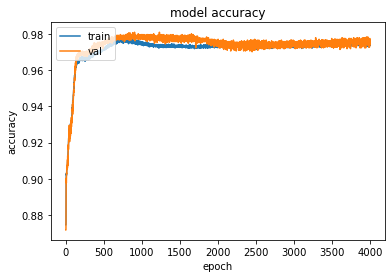

In [103]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

There is still oscillation on the accuracy so lets reduce the learning rate once again to try to eliminate that. The accuracy is still quite good but its not 99% which is the goal. 

In [104]:
# model using the sequential class
modelBM = Sequential()

# random normal probability distribution for weight init
BMinit = inits.RandomNormal(mean = 0.0, stddev = 1.0)

# add hidden layer with 10 neurons and output layer
modelBM.add(Dense(10, activation = 'sigmoid', input_shape = (3,), kernel_initializer = BMinit))
modelBM.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
modelBM.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.009), metrics = ['accuracy'])
# prints model summary to show model details
modelBM.summary()

H = modelBM.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                40        
                                                                 
 dense_21 (Dense)            (None, 3)                 33        
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
55/55 [==============================] - 1s 5ms/step - loss: 1.3664 - accuracy: 0.6544 - val_loss: 0.8101 - val_accuracy: 0.8718
Epoch 2/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.8746 - val_loss: 0.6277 - val_accuracy: 0.8718
Epoch 3/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.5983 - accuracy: 0.8746 - val_loss: 0.5679 - val_accuracy: 0.8718
Epoch 4/4000
55/55 [=======

55/55 [==============================] - 0s 2ms/step - loss: 0.3075 - accuracy: 0.9086 - val_loss: 0.3088 - val_accuracy: 0.9076
Epoch 111/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3069 - accuracy: 0.9087 - val_loss: 0.3082 - val_accuracy: 0.9080
Epoch 112/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3064 - accuracy: 0.9090 - val_loss: 0.3077 - val_accuracy: 0.9076
Epoch 113/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3058 - accuracy: 0.9091 - val_loss: 0.3071 - val_accuracy: 0.9085
Epoch 114/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3053 - accuracy: 0.9089 - val_loss: 0.3066 - val_accuracy: 0.9085
Epoch 115/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3047 - accuracy: 0.9090 - val_loss: 0.3061 - val_accuracy: 0.9089
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.9094 - val_loss: 0.3055 - val_accuracy: 0.9085
Epoch 1

Epoch 167/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2797 - accuracy: 0.9130 - val_loss: 0.2808 - val_accuracy: 0.9149
Epoch 168/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2793 - accuracy: 0.9132 - val_loss: 0.2803 - val_accuracy: 0.9149
Epoch 169/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2789 - accuracy: 0.9133 - val_loss: 0.2799 - val_accuracy: 0.9149
Epoch 170/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2784 - accuracy: 0.9136 - val_loss: 0.2794 - val_accuracy: 0.9154
Epoch 171/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2780 - accuracy: 0.9142 - val_loss: 0.2790 - val_accuracy: 0.9149
Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2776 - accuracy: 0.9139 - val_loss: 0.2785 - val_accuracy: 0.9149
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2771 - accuracy: 0.9142 - val_loss: 0.2781 - val_accuracy:

Epoch 224/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2560 - accuracy: 0.9197 - val_loss: 0.2566 - val_accuracy: 0.9197
Epoch 225/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2556 - accuracy: 0.9199 - val_loss: 0.2562 - val_accuracy: 0.9201
Epoch 226/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2552 - accuracy: 0.9198 - val_loss: 0.2558 - val_accuracy: 0.9201
Epoch 227/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2548 - accuracy: 0.9198 - val_loss: 0.2553 - val_accuracy: 0.9206
Epoch 228/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2544 - accuracy: 0.9201 - val_loss: 0.2550 - val_accuracy: 0.9201
Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2540 - accuracy: 0.9199 - val_loss: 0.2545 - val_accuracy: 0.9206
Epoch 230/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2536 - accuracy: 0.9199 - val_loss: 0.2541 - val_accuracy:

Epoch 281/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2328 - accuracy: 0.9246 - val_loss: 0.2331 - val_accuracy: 0.9240
Epoch 282/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2324 - accuracy: 0.9250 - val_loss: 0.2327 - val_accuracy: 0.9249
Epoch 283/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2320 - accuracy: 0.9246 - val_loss: 0.2323 - val_accuracy: 0.9249
Epoch 284/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2316 - accuracy: 0.9248 - val_loss: 0.2318 - val_accuracy: 0.9244
Epoch 285/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2312 - accuracy: 0.9254 - val_loss: 0.2315 - val_accuracy: 0.9253
Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2308 - accuracy: 0.9251 - val_loss: 0.2311 - val_accuracy: 0.9253
Epoch 287/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.2304 - accuracy: 0.9256 - val_loss: 0.2306 - val_accuracy:

Epoch 338/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.9279 - val_loss: 0.2097 - val_accuracy: 0.9262
Epoch 339/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2093 - accuracy: 0.9276 - val_loss: 0.2093 - val_accuracy: 0.9262
Epoch 340/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2089 - accuracy: 0.9280 - val_loss: 0.2088 - val_accuracy: 0.9262
Epoch 341/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2085 - accuracy: 0.9271 - val_loss: 0.2085 - val_accuracy: 0.9266
Epoch 342/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2081 - accuracy: 0.9269 - val_loss: 0.2081 - val_accuracy: 0.9270
Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2077 - accuracy: 0.9276 - val_loss: 0.2077 - val_accuracy: 0.9262
Epoch 344/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2073 - accuracy: 0.9271 - val_loss: 0.2072 - val_accuracy:

Epoch 395/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.9271 - val_loss: 0.1874 - val_accuracy: 0.9257
Epoch 396/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.9269 - val_loss: 0.1872 - val_accuracy: 0.9262
Epoch 397/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1870 - accuracy: 0.9269 - val_loss: 0.1867 - val_accuracy: 0.9257
Epoch 398/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1867 - accuracy: 0.9270 - val_loss: 0.1864 - val_accuracy: 0.9257
Epoch 399/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1863 - accuracy: 0.9267 - val_loss: 0.1861 - val_accuracy: 0.9262
Epoch 400/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1859 - accuracy: 0.9271 - val_loss: 0.1856 - val_accuracy: 0.9257
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1856 - accuracy: 0.9271 - val_loss: 0.1853 - val_accuracy:

Epoch 452/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1680 - accuracy: 0.9284 - val_loss: 0.1675 - val_accuracy: 0.9279
Epoch 453/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1677 - accuracy: 0.9279 - val_loss: 0.1672 - val_accuracy: 0.9279
Epoch 454/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1673 - accuracy: 0.9286 - val_loss: 0.1669 - val_accuracy: 0.9279
Epoch 455/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1670 - accuracy: 0.9283 - val_loss: 0.1667 - val_accuracy: 0.9283
Epoch 456/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1667 - accuracy: 0.9289 - val_loss: 0.1662 - val_accuracy: 0.9279
Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1663 - accuracy: 0.9281 - val_loss: 0.1660 - val_accuracy: 0.9279
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1660 - accuracy: 0.9286 - val_loss: 0.1655 - val_accuracy:

Epoch 509/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1503 - accuracy: 0.9302 - val_loss: 0.1497 - val_accuracy: 0.9275
Epoch 510/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1500 - accuracy: 0.9300 - val_loss: 0.1494 - val_accuracy: 0.9270
Epoch 511/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1497 - accuracy: 0.9300 - val_loss: 0.1492 - val_accuracy: 0.9275
Epoch 512/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1494 - accuracy: 0.9299 - val_loss: 0.1488 - val_accuracy: 0.9275
Epoch 513/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1491 - accuracy: 0.9300 - val_loss: 0.1485 - val_accuracy: 0.9279
Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.9303 - val_loss: 0.1482 - val_accuracy: 0.9279
Epoch 515/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1485 - accuracy: 0.9299 - val_loss: 0.1479 - val_accuracy:

Epoch 566/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1344 - accuracy: 0.9313 - val_loss: 0.1337 - val_accuracy: 0.9313
Epoch 567/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9312 - val_loss: 0.1335 - val_accuracy: 0.9313
Epoch 568/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1338 - accuracy: 0.9312 - val_loss: 0.1332 - val_accuracy: 0.9313
Epoch 569/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1336 - accuracy: 0.9316 - val_loss: 0.1330 - val_accuracy: 0.9318
Epoch 570/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1333 - accuracy: 0.9313 - val_loss: 0.1327 - val_accuracy: 0.9318
Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1331 - accuracy: 0.9316 - val_loss: 0.1324 - val_accuracy: 0.9318
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1328 - accuracy: 0.9315 - val_loss: 0.1323 - val_accuracy:

Epoch 623/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1202 - accuracy: 0.9342 - val_loss: 0.1195 - val_accuracy: 0.9335
Epoch 624/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1199 - accuracy: 0.9343 - val_loss: 0.1193 - val_accuracy: 0.9335
Epoch 625/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1197 - accuracy: 0.9343 - val_loss: 0.1191 - val_accuracy: 0.9335
Epoch 626/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1195 - accuracy: 0.9342 - val_loss: 0.1189 - val_accuracy: 0.9335
Epoch 627/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1193 - accuracy: 0.9346 - val_loss: 0.1186 - val_accuracy: 0.9335
Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1190 - accuracy: 0.9348 - val_loss: 0.1185 - val_accuracy: 0.9344
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1188 - accuracy: 0.9348 - val_loss: 0.1182 - val_accuracy:

Epoch 680/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1080 - accuracy: 0.9369 - val_loss: 0.1076 - val_accuracy: 0.9365
Epoch 681/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1078 - accuracy: 0.9365 - val_loss: 0.1073 - val_accuracy: 0.9365
Epoch 682/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1076 - accuracy: 0.9366 - val_loss: 0.1071 - val_accuracy: 0.9365
Epoch 683/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1074 - accuracy: 0.9374 - val_loss: 0.1069 - val_accuracy: 0.9370
Epoch 684/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1072 - accuracy: 0.9372 - val_loss: 0.1067 - val_accuracy: 0.9370
Epoch 685/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1070 - accuracy: 0.9371 - val_loss: 0.1066 - val_accuracy: 0.9370
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1068 - accuracy: 0.9368 - val_loss: 0.1064 - val_accuracy:

Epoch 737/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0980 - accuracy: 0.9400 - val_loss: 0.0977 - val_accuracy: 0.9378
Epoch 738/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0978 - accuracy: 0.9398 - val_loss: 0.0976 - val_accuracy: 0.9378
Epoch 739/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0976 - accuracy: 0.9398 - val_loss: 0.0973 - val_accuracy: 0.9378
Epoch 740/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0975 - accuracy: 0.9401 - val_loss: 0.0972 - val_accuracy: 0.9378
Epoch 741/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0973 - accuracy: 0.9400 - val_loss: 0.0970 - val_accuracy: 0.9383
Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0972 - accuracy: 0.9401 - val_loss: 0.0969 - val_accuracy: 0.9383
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0970 - accuracy: 0.9402 - val_loss: 0.0967 - val_accuracy:

Epoch 794/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0899 - accuracy: 0.9421 - val_loss: 0.0898 - val_accuracy: 0.9387
Epoch 795/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.9415 - val_loss: 0.0897 - val_accuracy: 0.9383
Epoch 796/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0896 - accuracy: 0.9421 - val_loss: 0.0895 - val_accuracy: 0.9374
Epoch 797/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0895 - accuracy: 0.9423 - val_loss: 0.0894 - val_accuracy: 0.9387
Epoch 798/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0894 - accuracy: 0.9420 - val_loss: 0.0893 - val_accuracy: 0.9387
Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0893 - accuracy: 0.9420 - val_loss: 0.0891 - val_accuracy: 0.9378
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9421 - val_loss: 0.0890 - val_accuracy:

Epoch 851/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.9433 - val_loss: 0.0834 - val_accuracy: 0.9391
Epoch 852/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0832 - accuracy: 0.9436 - val_loss: 0.0833 - val_accuracy: 0.9391
Epoch 853/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0831 - accuracy: 0.9428 - val_loss: 0.0832 - val_accuracy: 0.9396
Epoch 854/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0830 - accuracy: 0.9440 - val_loss: 0.0831 - val_accuracy: 0.9391
Epoch 855/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0829 - accuracy: 0.9433 - val_loss: 0.0830 - val_accuracy: 0.9391
Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0828 - accuracy: 0.9431 - val_loss: 0.0829 - val_accuracy: 0.9396
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 0.9437 - val_loss: 0.0828 - val_accuracy:

Epoch 908/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9457 - val_loss: 0.0780 - val_accuracy: 0.9413
Epoch 909/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0778 - accuracy: 0.9459 - val_loss: 0.0780 - val_accuracy: 0.9413
Epoch 910/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9453 - val_loss: 0.0779 - val_accuracy: 0.9413
Epoch 911/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0776 - accuracy: 0.9451 - val_loss: 0.0778 - val_accuracy: 0.9413
Epoch 912/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9454 - val_loss: 0.0777 - val_accuracy: 0.9413
Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0774 - accuracy: 0.9456 - val_loss: 0.0776 - val_accuracy: 0.9413
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0774 - accuracy: 0.9456 - val_loss: 0.0775 - val_accuracy:

Epoch 965/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.9476 - val_loss: 0.0734 - val_accuracy: 0.9443
Epoch 966/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.9472 - val_loss: 0.0734 - val_accuracy: 0.9434
Epoch 967/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.9470 - val_loss: 0.0732 - val_accuracy: 0.9443
Epoch 968/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9472 - val_loss: 0.0731 - val_accuracy: 0.9447
Epoch 969/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0728 - accuracy: 0.9474 - val_loss: 0.0731 - val_accuracy: 0.9447
Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.9472 - val_loss: 0.0730 - val_accuracy: 0.9447
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9474 - val_loss: 0.0729 - val_accuracy:

Epoch 1022/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.9470 - val_loss: 0.0691 - val_accuracy: 0.9469
Epoch 1023/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.9472 - val_loss: 0.0691 - val_accuracy: 0.9460
Epoch 1024/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9469 - val_loss: 0.0691 - val_accuracy: 0.9465
Epoch 1025/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9470 - val_loss: 0.0689 - val_accuracy: 0.9469
Epoch 1026/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9470 - val_loss: 0.0689 - val_accuracy: 0.9478
Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.9473 - val_loss: 0.0689 - val_accuracy: 0.9469
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0684 - accuracy: 0.9473 - val_loss: 0.0688 - val_ac

55/55 [==============================] - 0s 2ms/step - loss: 0.0617 - accuracy: 0.9496 - val_loss: 0.0620 - val_accuracy: 0.9491
Epoch 1135/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9493 - val_loss: 0.0620 - val_accuracy: 0.9495
Epoch 1136/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9497 - val_loss: 0.0619 - val_accuracy: 0.9495
Epoch 1137/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9495 - val_loss: 0.0619 - val_accuracy: 0.9491
Epoch 1138/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9496 - val_loss: 0.0618 - val_accuracy: 0.9495
Epoch 1139/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9499 - val_loss: 0.0618 - val_accuracy: 0.9491
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0613 - accuracy: 0.9500 - val_loss: 0.0617 - val_accuracy: 0.9495
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9528 - val_loss: 0.0563 - val_accuracy: 0.9521
Epoch 1247/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9531 - val_loss: 0.0563 - val_accuracy: 0.9521
Epoch 1248/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0559 - accuracy: 0.9529 - val_loss: 0.0562 - val_accuracy: 0.9516
Epoch 1249/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0559 - accuracy: 0.9528 - val_loss: 0.0561 - val_accuracy: 0.9525
Epoch 1250/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9531 - val_loss: 0.0561 - val_accuracy: 0.9516
Epoch 1251/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9531 - val_loss: 0.0561 - val_accuracy: 0.9521
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9532 - val_loss: 0.0560 - val_accuracy: 0.9529
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0516 - accuracy: 0.9554 - val_loss: 0.0517 - val_accuracy: 0.9525
Epoch 1359/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0516 - accuracy: 0.9551 - val_loss: 0.0517 - val_accuracy: 0.9525
Epoch 1360/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9552 - val_loss: 0.0517 - val_accuracy: 0.9521
Epoch 1361/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9546 - val_loss: 0.0516 - val_accuracy: 0.9525
Epoch 1362/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9549 - val_loss: 0.0516 - val_accuracy: 0.9525
Epoch 1363/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0514 - accuracy: 0.9549 - val_loss: 0.0516 - val_accuracy: 0.9525
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0514 - accuracy: 0.9551 - val_loss: 0.0515 - val_accuracy: 0.9525
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0481 - accuracy: 0.9568 - val_loss: 0.0481 - val_accuracy: 0.9534
Epoch 1471/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0480 - accuracy: 0.9568 - val_loss: 0.0481 - val_accuracy: 0.9534
Epoch 1472/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0480 - accuracy: 0.9568 - val_loss: 0.0481 - val_accuracy: 0.9534
Epoch 1473/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0480 - accuracy: 0.9567 - val_loss: 0.0481 - val_accuracy: 0.9534
Epoch 1474/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0480 - accuracy: 0.9568 - val_loss: 0.0480 - val_accuracy: 0.9534
Epoch 1475/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0479 - accuracy: 0.9567 - val_loss: 0.0480 - val_accuracy: 0.9534
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0479 - accuracy: 0.9568 - val_loss: 0.0480 - val_accuracy: 0.9534
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.9577 - val_loss: 0.0452 - val_accuracy: 0.9568
Epoch 1583/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.9578 - val_loss: 0.0452 - val_accuracy: 0.9568
Epoch 1584/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.9577 - val_loss: 0.0452 - val_accuracy: 0.9560
Epoch 1585/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.9578 - val_loss: 0.0451 - val_accuracy: 0.9564
Epoch 1586/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.9578 - val_loss: 0.0451 - val_accuracy: 0.9568
Epoch 1587/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9582 - val_loss: 0.0451 - val_accuracy: 0.9568
Epoch 1588/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9575 - val_loss: 0.0450 - val_accuracy: 0.9568
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0430 - accuracy: 0.9578 - val_loss: 0.0429 - val_accuracy: 0.9564
Epoch 1695/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0430 - accuracy: 0.9574 - val_loss: 0.0429 - val_accuracy: 0.9564
Epoch 1696/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0429 - accuracy: 0.9574 - val_loss: 0.0428 - val_accuracy: 0.9568
Epoch 1697/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0429 - accuracy: 0.9578 - val_loss: 0.0428 - val_accuracy: 0.9568
Epoch 1698/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0429 - accuracy: 0.9575 - val_loss: 0.0428 - val_accuracy: 0.9564
Epoch 1699/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0429 - accuracy: 0.9574 - val_loss: 0.0428 - val_accuracy: 0.9568
Epoch 1700/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0429 - accuracy: 0.9572 - val_loss: 0.0428 - val_accuracy: 0.9568
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9578 - val_loss: 0.0410 - val_accuracy: 0.9577
Epoch 1807/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9577 - val_loss: 0.0410 - val_accuracy: 0.9568
Epoch 1808/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9575 - val_loss: 0.0409 - val_accuracy: 0.9577
Epoch 1809/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9578 - val_loss: 0.0410 - val_accuracy: 0.9568
Epoch 1810/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9578 - val_loss: 0.0409 - val_accuracy: 0.9573
Epoch 1811/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9580 - val_loss: 0.0409 - val_accuracy: 0.9568
Epoch 1812/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9581 - val_loss: 0.0409 - val_accuracy: 0.9568
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9582 - val_loss: 0.0395 - val_accuracy: 0.9581
Epoch 1919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9585 - val_loss: 0.0394 - val_accuracy: 0.9581
Epoch 1920/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9585 - val_loss: 0.0394 - val_accuracy: 0.9581
Epoch 1921/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9584 - val_loss: 0.0394 - val_accuracy: 0.9581
Epoch 1922/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9582 - val_loss: 0.0394 - val_accuracy: 0.9581
Epoch 1923/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9582 - val_loss: 0.0394 - val_accuracy: 0.9581
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9580 - val_loss: 0.0394 - val_accuracy: 0.9581
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0385 - accuracy: 0.9582 - val_loss: 0.0382 - val_accuracy: 0.9607
Epoch 2031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0385 - accuracy: 0.9588 - val_loss: 0.0382 - val_accuracy: 0.9607
Epoch 2032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.9587 - val_loss: 0.0382 - val_accuracy: 0.9607
Epoch 2033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.9587 - val_loss: 0.0382 - val_accuracy: 0.9607
Epoch 2034/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.9588 - val_loss: 0.0382 - val_accuracy: 0.9607
Epoch 2035/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.9588 - val_loss: 0.0382 - val_accuracy: 0.9607
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.9581 - val_loss: 0.0382 - val_accuracy: 0.9607
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9578 - val_loss: 0.0372 - val_accuracy: 0.9611
Epoch 2143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9581 - val_loss: 0.0372 - val_accuracy: 0.9616
Epoch 2144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9582 - val_loss: 0.0372 - val_accuracy: 0.9616
Epoch 2145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9575 - val_loss: 0.0372 - val_accuracy: 0.9611
Epoch 2146/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9580 - val_loss: 0.0372 - val_accuracy: 0.9616
Epoch 2147/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9577 - val_loss: 0.0372 - val_accuracy: 0.9611
Epoch 2148/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9580 - val_loss: 0.0371 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9578 - val_loss: 0.0363 - val_accuracy: 0.9624
Epoch 2255/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9574 - val_loss: 0.0363 - val_accuracy: 0.9624
Epoch 2256/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9578 - val_loss: 0.0362 - val_accuracy: 0.9624
Epoch 2257/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9577 - val_loss: 0.0362 - val_accuracy: 0.9624
Epoch 2258/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9575 - val_loss: 0.0362 - val_accuracy: 0.9624
Epoch 2259/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9577 - val_loss: 0.0362 - val_accuracy: 0.9624
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0365 - accuracy: 0.9575 - val_loss: 0.0362 - val_accuracy: 0.9620
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9577 - val_loss: 0.0355 - val_accuracy: 0.9616
Epoch 2367/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9582 - val_loss: 0.0355 - val_accuracy: 0.9616
Epoch 2368/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9580 - val_loss: 0.0355 - val_accuracy: 0.9620
Epoch 2369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9581 - val_loss: 0.0355 - val_accuracy: 0.9620
Epoch 2370/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9581 - val_loss: 0.0355 - val_accuracy: 0.9616
Epoch 2371/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9585 - val_loss: 0.0354 - val_accuracy: 0.9616
Epoch 2372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9580 - val_loss: 0.0354 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9581 - val_loss: 0.0348 - val_accuracy: 0.9616
Epoch 2479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9584 - val_loss: 0.0347 - val_accuracy: 0.9616
Epoch 2480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9584 - val_loss: 0.0347 - val_accuracy: 0.9616
Epoch 2481/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0350 - accuracy: 0.9582 - val_loss: 0.0347 - val_accuracy: 0.9616
Epoch 2482/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9581 - val_loss: 0.0348 - val_accuracy: 0.9616
Epoch 2483/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9582 - val_loss: 0.0347 - val_accuracy: 0.9616
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9582 - val_loss: 0.0347 - val_accuracy: 0.9620
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9587 - val_loss: 0.0340 - val_accuracy: 0.9603
Epoch 2591/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9587 - val_loss: 0.0341 - val_accuracy: 0.9607
Epoch 2592/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9587 - val_loss: 0.0341 - val_accuracy: 0.9611
Epoch 2593/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9584 - val_loss: 0.0340 - val_accuracy: 0.9607
Epoch 2594/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9590 - val_loss: 0.0341 - val_accuracy: 0.9607
Epoch 2595/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9588 - val_loss: 0.0341 - val_accuracy: 0.9611
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9587 - val_loss: 0.0340 - val_accuracy: 0.9607
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9590 - val_loss: 0.0334 - val_accuracy: 0.9611
Epoch 2703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9591 - val_loss: 0.0334 - val_accuracy: 0.9611
Epoch 2704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9593 - val_loss: 0.0334 - val_accuracy: 0.9611
Epoch 2705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9591 - val_loss: 0.0334 - val_accuracy: 0.9611
Epoch 2706/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9593 - val_loss: 0.0334 - val_accuracy: 0.9611
Epoch 2707/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9588 - val_loss: 0.0334 - val_accuracy: 0.9611
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9591 - val_loss: 0.0334 - val_accuracy: 0.9611
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0331 - accuracy: 0.9595 - val_loss: 0.0328 - val_accuracy: 0.9616
Epoch 2815/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0331 - accuracy: 0.9597 - val_loss: 0.0328 - val_accuracy: 0.9620
Epoch 2816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9591 - val_loss: 0.0328 - val_accuracy: 0.9624
Epoch 2817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9595 - val_loss: 0.0328 - val_accuracy: 0.9620
Epoch 2818/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9598 - val_loss: 0.0328 - val_accuracy: 0.9624
Epoch 2819/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9594 - val_loss: 0.0328 - val_accuracy: 0.9624
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9595 - val_loss: 0.0328 - val_accuracy: 0.9620
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9603 - val_loss: 0.0322 - val_accuracy: 0.9611
Epoch 2927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9604 - val_loss: 0.0322 - val_accuracy: 0.9611
Epoch 2928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9607 - val_loss: 0.0322 - val_accuracy: 0.9620
Epoch 2929/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9601 - val_loss: 0.0322 - val_accuracy: 0.9616
Epoch 2930/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9603 - val_loss: 0.0322 - val_accuracy: 0.9620
Epoch 2931/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9605 - val_loss: 0.0322 - val_accuracy: 0.9620
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9604 - val_loss: 0.0322 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9605 - val_loss: 0.0317 - val_accuracy: 0.9611
Epoch 3039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9607 - val_loss: 0.0317 - val_accuracy: 0.9611
Epoch 3040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9605 - val_loss: 0.0316 - val_accuracy: 0.9616
Epoch 3041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9611 - val_loss: 0.0317 - val_accuracy: 0.9611
Epoch 3042/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.9605 - val_loss: 0.0317 - val_accuracy: 0.9616
Epoch 3043/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9608 - val_loss: 0.0317 - val_accuracy: 0.9616
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9607 - val_loss: 0.0316 - val_accuracy: 0.9611
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9614 - val_loss: 0.0312 - val_accuracy: 0.9620
Epoch 3151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9611 - val_loss: 0.0311 - val_accuracy: 0.9616
Epoch 3152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9610 - val_loss: 0.0311 - val_accuracy: 0.9616
Epoch 3153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9611 - val_loss: 0.0311 - val_accuracy: 0.9616
Epoch 3154/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9611 - val_loss: 0.0311 - val_accuracy: 0.9611
Epoch 3155/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9614 - val_loss: 0.0311 - val_accuracy: 0.9620
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9610 - val_loss: 0.0311 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9620 - val_loss: 0.0306 - val_accuracy: 0.9616
Epoch 3263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9620 - val_loss: 0.0306 - val_accuracy: 0.9616
Epoch 3264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9626 - val_loss: 0.0306 - val_accuracy: 0.9616
Epoch 3265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9623 - val_loss: 0.0306 - val_accuracy: 0.9620
Epoch 3266/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9620 - val_loss: 0.0306 - val_accuracy: 0.9616
Epoch 3267/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9623 - val_loss: 0.0306 - val_accuracy: 0.9620
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9623 - val_loss: 0.0306 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9627 - val_loss: 0.0301 - val_accuracy: 0.9611
Epoch 3375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9627 - val_loss: 0.0301 - val_accuracy: 0.9611
Epoch 3376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9627 - val_loss: 0.0301 - val_accuracy: 0.9616
Epoch 3377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9629 - val_loss: 0.0301 - val_accuracy: 0.9616
Epoch 3378/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9626 - val_loss: 0.0301 - val_accuracy: 0.9616
Epoch 3379/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9629 - val_loss: 0.0301 - val_accuracy: 0.9616
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9626 - val_loss: 0.0301 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9631 - val_loss: 0.0296 - val_accuracy: 0.9620
Epoch 3487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9630 - val_loss: 0.0296 - val_accuracy: 0.9616
Epoch 3488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9631 - val_loss: 0.0296 - val_accuracy: 0.9620
Epoch 3489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9627 - val_loss: 0.0296 - val_accuracy: 0.9620
Epoch 3490/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9631 - val_loss: 0.0296 - val_accuracy: 0.9616
Epoch 3491/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9630 - val_loss: 0.0296 - val_accuracy: 0.9620
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9633 - val_loss: 0.0296 - val_accuracy: 0.9620
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9633 - val_loss: 0.0291 - val_accuracy: 0.9624
Epoch 3599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9633 - val_loss: 0.0291 - val_accuracy: 0.9629
Epoch 3600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9630 - val_loss: 0.0291 - val_accuracy: 0.9629
Epoch 3601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9631 - val_loss: 0.0291 - val_accuracy: 0.9620
Epoch 3602/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9627 - val_loss: 0.0291 - val_accuracy: 0.9629
Epoch 3603/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9630 - val_loss: 0.0291 - val_accuracy: 0.9620
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9630 - val_loss: 0.0291 - val_accuracy: 0.9633
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9637 - val_loss: 0.0287 - val_accuracy: 0.9629
Epoch 3711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9639 - val_loss: 0.0287 - val_accuracy: 0.9629
Epoch 3712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9639 - val_loss: 0.0287 - val_accuracy: 0.9629
Epoch 3713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9634 - val_loss: 0.0287 - val_accuracy: 0.9624
Epoch 3714/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9640 - val_loss: 0.0287 - val_accuracy: 0.9629
Epoch 3715/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9639 - val_loss: 0.0287 - val_accuracy: 0.9629
Epoch 3716/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9637 - val_loss: 0.0287 - val_accuracy: 0.9629
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9641 - val_loss: 0.0283 - val_accuracy: 0.9629
Epoch 3823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9639 - val_loss: 0.0283 - val_accuracy: 0.9629
Epoch 3824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9640 - val_loss: 0.0283 - val_accuracy: 0.9633
Epoch 3825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9641 - val_loss: 0.0283 - val_accuracy: 0.9633
Epoch 3826/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9641 - val_loss: 0.0283 - val_accuracy: 0.9633
Epoch 3827/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9641 - val_loss: 0.0283 - val_accuracy: 0.9629
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9640 - val_loss: 0.0282 - val_accuracy: 0.9633
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9643 - val_loss: 0.0279 - val_accuracy: 0.9637
Epoch 3935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9643 - val_loss: 0.0279 - val_accuracy: 0.9637
Epoch 3936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9643 - val_loss: 0.0279 - val_accuracy: 0.9637
Epoch 3937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9644 - val_loss: 0.0279 - val_accuracy: 0.9637
Epoch 3938/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9644 - val_loss: 0.0279 - val_accuracy: 0.9637
Epoch 3939/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9640 - val_loss: 0.0279 - val_accuracy: 0.9637
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9641 - val_loss: 0.0279 - val_accuracy: 0.9637
E

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

It seems like there is a plateau that each of the above models is reaching. Lets see if a different weight initialization method can help fix that. I will try the He method with a uniform distribution and the smallest learning rate from the above experiments. 

In [105]:
# create the model using sequential Dense layers 
# Sequential model is feedforward neural network
model = Sequential()

# weight initialization method 
initializer = HeUniform()

# add hidden layers and output layer 
model.add(Dense(10, activation = 'sigmoid', input_shape = (3,), kernel_initializer = initializer)) 
#model.add(Dense(25, activation = 'tanh', kernel_initializer = initializer2))
model.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
model.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.009), metrics = ['accuracy'])

# prints model summary to show model details
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 10)                40        
                                                                 
 dense_23 (Dense)            (None, 3)                 33        
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [106]:
# 75/25 train/validation data split 
# split training data set 
trainX, testX, trainY, testY = train_test_split(x, y,  test_size = 0.25, random_state = 1)

maxEpochs = 4000
batchSize = 128

H2 = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Epoch 1/4000
55/55 [==============================] - 1s 5ms/step - loss: 1.0303 - accuracy: 0.8746 - val_loss: 0.8828 - val_accuracy: 0.8718
Epoch 2/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.8199 - accuracy: 0.8746 - val_loss: 0.7628 - val_accuracy: 0.8718
Epoch 3/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.7246 - accuracy: 0.8746 - val_loss: 0.6842 - val_accuracy: 0.8718
Epoch 4/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.8746 - val_loss: 0.6248 - val_accuracy: 0.8718
Epoch 5/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.6027 - accuracy: 0.8746 - val_loss: 0.5787 - val_accuracy: 0.8718
Epoch 6/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.5613 - accuracy: 0.8746 - val_loss: 0.5426 - val_accuracy: 0.8718
Epoch 7/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.5288 - accuracy: 0.8746 - val_loss: 0.5144 - val_accuracy: 0.8718
Epoch 

55/55 [==============================] - 0s 2ms/step - loss: 0.2855 - accuracy: 0.8968 - val_loss: 0.2875 - val_accuracy: 0.8908
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2849 - accuracy: 0.8968 - val_loss: 0.2869 - val_accuracy: 0.8908
Epoch 117/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2844 - accuracy: 0.8968 - val_loss: 0.2864 - val_accuracy: 0.8908
Epoch 118/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2838 - accuracy: 0.8972 - val_loss: 0.2859 - val_accuracy: 0.8925
Epoch 119/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.8970 - val_loss: 0.2853 - val_accuracy: 0.8925
Epoch 120/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2828 - accuracy: 0.8970 - val_loss: 0.2848 - val_accuracy: 0.8925
Epoch 121/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2823 - accuracy: 0.8970 - val_loss: 0.2843 - val_accuracy: 0.8929
Epoch 1

Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2622 - accuracy: 0.9001 - val_loss: 0.2640 - val_accuracy: 0.9028
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2619 - accuracy: 0.9009 - val_loss: 0.2636 - val_accuracy: 0.9028
Epoch 174/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2616 - accuracy: 0.9006 - val_loss: 0.2633 - val_accuracy: 0.9028
Epoch 175/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2613 - accuracy: 0.9006 - val_loss: 0.2630 - val_accuracy: 0.9028
Epoch 176/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2609 - accuracy: 0.9009 - val_loss: 0.2627 - val_accuracy: 0.9028
Epoch 177/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2606 - accuracy: 0.9014 - val_loss: 0.2623 - val_accuracy: 0.9028
Epoch 178/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2603 - accuracy: 0.9012 - val_loss: 0.2620 - val_accuracy:

Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2440 - accuracy: 0.9068 - val_loss: 0.2456 - val_accuracy: 0.9076
Epoch 230/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2437 - accuracy: 0.9070 - val_loss: 0.2452 - val_accuracy: 0.9076
Epoch 231/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2433 - accuracy: 0.9077 - val_loss: 0.2450 - val_accuracy: 0.9076
Epoch 232/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2430 - accuracy: 0.9077 - val_loss: 0.2446 - val_accuracy: 0.9076
Epoch 233/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.9076 - val_loss: 0.2443 - val_accuracy: 0.9076
Epoch 234/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2424 - accuracy: 0.9078 - val_loss: 0.2440 - val_accuracy: 0.9076
Epoch 235/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2421 - accuracy: 0.9077 - val_loss: 0.2437 - val_accuracy:

Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2262 - accuracy: 0.9133 - val_loss: 0.2278 - val_accuracy: 0.9119
Epoch 287/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2259 - accuracy: 0.9132 - val_loss: 0.2274 - val_accuracy: 0.9115
Epoch 288/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2256 - accuracy: 0.9140 - val_loss: 0.2272 - val_accuracy: 0.9123
Epoch 289/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2253 - accuracy: 0.9138 - val_loss: 0.2268 - val_accuracy: 0.9123
Epoch 290/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2250 - accuracy: 0.9136 - val_loss: 0.2265 - val_accuracy: 0.9128
Epoch 291/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2247 - accuracy: 0.9143 - val_loss: 0.2262 - val_accuracy: 0.9132
Epoch 292/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2244 - accuracy: 0.9140 - val_loss: 0.2259 - val_accuracy:

Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2089 - accuracy: 0.9189 - val_loss: 0.2103 - val_accuracy: 0.9180
Epoch 344/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2086 - accuracy: 0.9188 - val_loss: 0.2100 - val_accuracy: 0.9184
Epoch 345/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.9191 - val_loss: 0.2098 - val_accuracy: 0.9184
Epoch 346/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2080 - accuracy: 0.9194 - val_loss: 0.2094 - val_accuracy: 0.9184
Epoch 347/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2077 - accuracy: 0.9194 - val_loss: 0.2091 - val_accuracy: 0.9184
Epoch 348/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.9192 - val_loss: 0.2088 - val_accuracy: 0.9180
Epoch 349/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2071 - accuracy: 0.9197 - val_loss: 0.2085 - val_accuracy:

Epoch 400/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1917 - accuracy: 0.9233 - val_loss: 0.1929 - val_accuracy: 0.9236
Epoch 401/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9238 - val_loss: 0.1927 - val_accuracy: 0.9240
Epoch 402/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.1911 - accuracy: 0.9231 - val_loss: 0.1923 - val_accuracy: 0.9236
Epoch 403/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1908 - accuracy: 0.9241 - val_loss: 0.1921 - val_accuracy: 0.9231
Epoch 404/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1904 - accuracy: 0.9237 - val_loss: 0.1918 - val_accuracy: 0.9236
Epoch 405/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1901 - accuracy: 0.9248 - val_loss: 0.1916 - val_accuracy: 0.9236
Epoch 406/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.9244 - val_loss: 0.1912 - val_accuracy:

Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1741 - accuracy: 0.9277 - val_loss: 0.1754 - val_accuracy: 0.9262
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1738 - accuracy: 0.9281 - val_loss: 0.1750 - val_accuracy: 0.9262
Epoch 459/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.9279 - val_loss: 0.1746 - val_accuracy: 0.9262
Epoch 460/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.9276 - val_loss: 0.1743 - val_accuracy: 0.9262
Epoch 461/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1728 - accuracy: 0.9274 - val_loss: 0.1740 - val_accuracy: 0.9262
Epoch 462/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.9279 - val_loss: 0.1738 - val_accuracy: 0.9262
Epoch 463/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1722 - accuracy: 0.9277 - val_loss: 0.1734 - val_accuracy:

Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1562 - accuracy: 0.9293 - val_loss: 0.1573 - val_accuracy: 0.9257
Epoch 515/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1559 - accuracy: 0.9292 - val_loss: 0.1569 - val_accuracy: 0.9257
Epoch 516/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1556 - accuracy: 0.9294 - val_loss: 0.1566 - val_accuracy: 0.9253
Epoch 517/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1553 - accuracy: 0.9296 - val_loss: 0.1563 - val_accuracy: 0.9257
Epoch 518/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9294 - val_loss: 0.1560 - val_accuracy: 0.9253
Epoch 519/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1547 - accuracy: 0.9294 - val_loss: 0.1558 - val_accuracy: 0.9257
Epoch 520/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9297 - val_loss: 0.1554 - val_accuracy:

Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1388 - accuracy: 0.9305 - val_loss: 0.1396 - val_accuracy: 0.9257
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.9305 - val_loss: 0.1393 - val_accuracy: 0.9257
Epoch 573/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1382 - accuracy: 0.9303 - val_loss: 0.1389 - val_accuracy: 0.9266
Epoch 574/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1379 - accuracy: 0.9306 - val_loss: 0.1387 - val_accuracy: 0.9262
Epoch 575/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1376 - accuracy: 0.9302 - val_loss: 0.1384 - val_accuracy: 0.9257
Epoch 576/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1373 - accuracy: 0.9307 - val_loss: 0.1380 - val_accuracy: 0.9257
Epoch 577/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1370 - accuracy: 0.9300 - val_loss: 0.1378 - val_accuracy:

Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1226 - accuracy: 0.9322 - val_loss: 0.1233 - val_accuracy: 0.9288
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9320 - val_loss: 0.1229 - val_accuracy: 0.9288
Epoch 630/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1220 - accuracy: 0.9319 - val_loss: 0.1227 - val_accuracy: 0.9283
Epoch 631/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1218 - accuracy: 0.9319 - val_loss: 0.1224 - val_accuracy: 0.9288
Epoch 632/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9322 - val_loss: 0.1222 - val_accuracy: 0.9288
Epoch 633/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1212 - accuracy: 0.9319 - val_loss: 0.1219 - val_accuracy: 0.9288
Epoch 634/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1210 - accuracy: 0.9320 - val_loss: 0.1217 - val_accuracy:

Epoch 685/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.1084 - accuracy: 0.9348 - val_loss: 0.1092 - val_accuracy: 0.9309
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1082 - accuracy: 0.9351 - val_loss: 0.1089 - val_accuracy: 0.9309
Epoch 687/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1080 - accuracy: 0.9351 - val_loss: 0.1086 - val_accuracy: 0.9305
Epoch 688/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1078 - accuracy: 0.9358 - val_loss: 0.1084 - val_accuracy: 0.9309
Epoch 689/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1076 - accuracy: 0.9353 - val_loss: 0.1082 - val_accuracy: 0.9309
Epoch 690/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1073 - accuracy: 0.9356 - val_loss: 0.1080 - val_accuracy: 0.9309
Epoch 691/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1071 - accuracy: 0.9351 - val_loss: 0.1078 - val_accuracy:

Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0968 - accuracy: 0.9414 - val_loss: 0.0975 - val_accuracy: 0.9365
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0966 - accuracy: 0.9413 - val_loss: 0.0974 - val_accuracy: 0.9365
Epoch 744/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0964 - accuracy: 0.9421 - val_loss: 0.0971 - val_accuracy: 0.9370
Epoch 745/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0963 - accuracy: 0.9415 - val_loss: 0.0970 - val_accuracy: 0.9374
Epoch 746/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0961 - accuracy: 0.9418 - val_loss: 0.0969 - val_accuracy: 0.9370
Epoch 747/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0959 - accuracy: 0.9420 - val_loss: 0.0966 - val_accuracy: 0.9370
Epoch 748/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0957 - accuracy: 0.9418 - val_loss: 0.0965 - val_accuracy:

Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0875 - accuracy: 0.9433 - val_loss: 0.0883 - val_accuracy: 0.9408
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0873 - accuracy: 0.9434 - val_loss: 0.0881 - val_accuracy: 0.9408
Epoch 801/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0872 - accuracy: 0.9437 - val_loss: 0.0880 - val_accuracy: 0.9413
Epoch 802/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0870 - accuracy: 0.9436 - val_loss: 0.0878 - val_accuracy: 0.9408
Epoch 803/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0869 - accuracy: 0.9431 - val_loss: 0.0878 - val_accuracy: 0.9413
Epoch 804/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0867 - accuracy: 0.9431 - val_loss: 0.0876 - val_accuracy: 0.9417
Epoch 805/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0866 - accuracy: 0.9430 - val_loss: 0.0874 - val_accuracy:

Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0798 - accuracy: 0.9437 - val_loss: 0.0808 - val_accuracy: 0.9421
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.9434 - val_loss: 0.0807 - val_accuracy: 0.9430
Epoch 858/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0796 - accuracy: 0.9437 - val_loss: 0.0806 - val_accuracy: 0.9421
Epoch 859/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0795 - accuracy: 0.9434 - val_loss: 0.0805 - val_accuracy: 0.9430
Epoch 860/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0793 - accuracy: 0.9438 - val_loss: 0.0803 - val_accuracy: 0.9430
Epoch 861/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0792 - accuracy: 0.9438 - val_loss: 0.0803 - val_accuracy: 0.9426
Epoch 862/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 0.9436 - val_loss: 0.0801 - val_accuracy:

Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0734 - accuracy: 0.9451 - val_loss: 0.0745 - val_accuracy: 0.9439
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0733 - accuracy: 0.9451 - val_loss: 0.0744 - val_accuracy: 0.9439
Epoch 915/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0732 - accuracy: 0.9454 - val_loss: 0.0744 - val_accuracy: 0.9443
Epoch 916/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.9457 - val_loss: 0.0742 - val_accuracy: 0.9443
Epoch 917/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.9450 - val_loss: 0.0741 - val_accuracy: 0.9439
Epoch 918/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9457 - val_loss: 0.0740 - val_accuracy: 0.9434
Epoch 919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0728 - accuracy: 0.9454 - val_loss: 0.0739 - val_accuracy:

Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9467 - val_loss: 0.0692 - val_accuracy: 0.9443
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.9469 - val_loss: 0.0691 - val_accuracy: 0.9443
Epoch 972/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.9472 - val_loss: 0.0691 - val_accuracy: 0.9443
Epoch 973/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9466 - val_loss: 0.0690 - val_accuracy: 0.9443
Epoch 974/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9470 - val_loss: 0.0689 - val_accuracy: 0.9443
Epoch 975/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0676 - accuracy: 0.9464 - val_loss: 0.0688 - val_accuracy: 0.9443
Epoch 976/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9469 - val_loss: 0.0687 - val_accuracy:

Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9486 - val_loss: 0.0648 - val_accuracy: 0.9452
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9487 - val_loss: 0.0648 - val_accuracy: 0.9456
Epoch 1029/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0635 - accuracy: 0.9483 - val_loss: 0.0647 - val_accuracy: 0.9452
Epoch 1030/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9483 - val_loss: 0.0647 - val_accuracy: 0.9456
Epoch 1031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9483 - val_loss: 0.0646 - val_accuracy: 0.9456
Epoch 1032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9485 - val_loss: 0.0645 - val_accuracy: 0.9460
Epoch 1033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.9486 - val_loss: 0.0644 - val_ac

55/55 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.9521 - val_loss: 0.0586 - val_accuracy: 0.9469
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.9522 - val_loss: 0.0585 - val_accuracy: 0.9473
Epoch 1141/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9521 - val_loss: 0.0584 - val_accuracy: 0.9469
Epoch 1142/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9522 - val_loss: 0.0584 - val_accuracy: 0.9469
Epoch 1143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9521 - val_loss: 0.0584 - val_accuracy: 0.9469
Epoch 1144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0571 - accuracy: 0.9522 - val_loss: 0.0583 - val_accuracy: 0.9469
Epoch 1145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0571 - accuracy: 0.9521 - val_loss: 0.0583 - val_accuracy: 0.9486
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.9549 - val_loss: 0.0543 - val_accuracy: 0.9512
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.9546 - val_loss: 0.0543 - val_accuracy: 0.9512
Epoch 1253/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.9549 - val_loss: 0.0542 - val_accuracy: 0.9512
Epoch 1254/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0530 - accuracy: 0.9546 - val_loss: 0.0542 - val_accuracy: 0.9512
Epoch 1255/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0530 - accuracy: 0.9551 - val_loss: 0.0542 - val_accuracy: 0.9516
Epoch 1256/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0530 - accuracy: 0.9548 - val_loss: 0.0541 - val_accuracy: 0.9516
Epoch 1257/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0529 - accuracy: 0.9549 - val_loss: 0.0541 - val_accuracy: 0.9516
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.9559 - val_loss: 0.0513 - val_accuracy: 0.9534
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.9562 - val_loss: 0.0513 - val_accuracy: 0.9538
Epoch 1365/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.9562 - val_loss: 0.0512 - val_accuracy: 0.9538
Epoch 1366/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.9559 - val_loss: 0.0512 - val_accuracy: 0.9534
Epoch 1367/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.9562 - val_loss: 0.0512 - val_accuracy: 0.9538
Epoch 1368/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.9561 - val_loss: 0.0511 - val_accuracy: 0.9538
Epoch 1369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.9564 - val_loss: 0.0511 - val_accuracy: 0.9538
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0477 - accuracy: 0.9578 - val_loss: 0.0489 - val_accuracy: 0.9560
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0477 - accuracy: 0.9578 - val_loss: 0.0489 - val_accuracy: 0.9564
Epoch 1477/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0477 - accuracy: 0.9580 - val_loss: 0.0488 - val_accuracy: 0.9564
Epoch 1478/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0477 - accuracy: 0.9574 - val_loss: 0.0488 - val_accuracy: 0.9564
Epoch 1479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0477 - accuracy: 0.9580 - val_loss: 0.0488 - val_accuracy: 0.9564
Epoch 1480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0477 - accuracy: 0.9572 - val_loss: 0.0488 - val_accuracy: 0.9564
Epoch 1481/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0476 - accuracy: 0.9577 - val_loss: 0.0487 - val_accuracy: 0.9564
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.9581 - val_loss: 0.0468 - val_accuracy: 0.9564
Epoch 1588/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.9582 - val_loss: 0.0468 - val_accuracy: 0.9560
Epoch 1589/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9580 - val_loss: 0.0468 - val_accuracy: 0.9560
Epoch 1590/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9577 - val_loss: 0.0468 - val_accuracy: 0.9560
Epoch 1591/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9577 - val_loss: 0.0468 - val_accuracy: 0.9564
Epoch 1592/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9580 - val_loss: 0.0468 - val_accuracy: 0.9555
Epoch 1593/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9580 - val_loss: 0.0468 - val_accuracy: 0.9560
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0440 - accuracy: 0.9587 - val_loss: 0.0451 - val_accuracy: 0.9564
Epoch 1700/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9593 - val_loss: 0.0451 - val_accuracy: 0.9560
Epoch 1701/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9587 - val_loss: 0.0450 - val_accuracy: 0.9564
Epoch 1702/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9582 - val_loss: 0.0451 - val_accuracy: 0.9564
Epoch 1703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9590 - val_loss: 0.0450 - val_accuracy: 0.9564
Epoch 1704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9590 - val_loss: 0.0450 - val_accuracy: 0.9560
Epoch 1705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9590 - val_loss: 0.0450 - val_accuracy: 0.9560
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0425 - accuracy: 0.9588 - val_loss: 0.0435 - val_accuracy: 0.9560
Epoch 1812/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0425 - accuracy: 0.9587 - val_loss: 0.0435 - val_accuracy: 0.9555
Epoch 1813/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0425 - accuracy: 0.9584 - val_loss: 0.0435 - val_accuracy: 0.9564
Epoch 1814/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0424 - accuracy: 0.9590 - val_loss: 0.0435 - val_accuracy: 0.9555
Epoch 1815/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0424 - accuracy: 0.9585 - val_loss: 0.0435 - val_accuracy: 0.9560
Epoch 1816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0424 - accuracy: 0.9587 - val_loss: 0.0435 - val_accuracy: 0.9555
Epoch 1817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0424 - accuracy: 0.9588 - val_loss: 0.0435 - val_accuracy: 0.9560
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9590 - val_loss: 0.0421 - val_accuracy: 0.9555
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9585 - val_loss: 0.0421 - val_accuracy: 0.9560
Epoch 1925/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 0.9584 - val_loss: 0.0421 - val_accuracy: 0.9560
Epoch 1926/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.9584 - val_loss: 0.0421 - val_accuracy: 0.9560
Epoch 1927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.9582 - val_loss: 0.0421 - val_accuracy: 0.9560
Epoch 1928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.9581 - val_loss: 0.0421 - val_accuracy: 0.9560
Epoch 1929/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.9584 - val_loss: 0.0420 - val_accuracy: 0.9551
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9582 - val_loss: 0.0408 - val_accuracy: 0.9560
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9581 - val_loss: 0.0408 - val_accuracy: 0.9560
Epoch 2037/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9582 - val_loss: 0.0408 - val_accuracy: 0.9560
Epoch 2038/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9584 - val_loss: 0.0407 - val_accuracy: 0.9555
Epoch 2039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9581 - val_loss: 0.0407 - val_accuracy: 0.9555
Epoch 2040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9578 - val_loss: 0.0407 - val_accuracy: 0.9560
Epoch 2041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9582 - val_loss: 0.0408 - val_accuracy: 0.9555
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9577 - val_loss: 0.0396 - val_accuracy: 0.9568
Epoch 2148/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9577 - val_loss: 0.0396 - val_accuracy: 0.9573
Epoch 2149/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9581 - val_loss: 0.0396 - val_accuracy: 0.9568
Epoch 2150/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9580 - val_loss: 0.0396 - val_accuracy: 0.9568
Epoch 2151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9577 - val_loss: 0.0396 - val_accuracy: 0.9568
Epoch 2152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9580 - val_loss: 0.0396 - val_accuracy: 0.9568
Epoch 2153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0386 - accuracy: 0.9577 - val_loss: 0.0396 - val_accuracy: 0.9573
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9581 - val_loss: 0.0385 - val_accuracy: 0.9581
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9587 - val_loss: 0.0385 - val_accuracy: 0.9581
Epoch 2261/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9584 - val_loss: 0.0385 - val_accuracy: 0.9581
Epoch 2262/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9585 - val_loss: 0.0385 - val_accuracy: 0.9581
Epoch 2263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9581 - val_loss: 0.0385 - val_accuracy: 0.9581
Epoch 2264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9582 - val_loss: 0.0385 - val_accuracy: 0.9577
Epoch 2265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9582 - val_loss: 0.0385 - val_accuracy: 0.9581
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9585 - val_loss: 0.0375 - val_accuracy: 0.9573
Epoch 2372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9585 - val_loss: 0.0375 - val_accuracy: 0.9581
Epoch 2373/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9585 - val_loss: 0.0375 - val_accuracy: 0.9573
Epoch 2374/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9588 - val_loss: 0.0375 - val_accuracy: 0.9581
Epoch 2375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9584 - val_loss: 0.0375 - val_accuracy: 0.9581
Epoch 2376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9587 - val_loss: 0.0375 - val_accuracy: 0.9581
Epoch 2377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9585 - val_loss: 0.0375 - val_accuracy: 0.9577
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9588 - val_loss: 0.0366 - val_accuracy: 0.9577
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9587 - val_loss: 0.0366 - val_accuracy: 0.9577
Epoch 2485/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9590 - val_loss: 0.0366 - val_accuracy: 0.9581
Epoch 2486/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9590 - val_loss: 0.0366 - val_accuracy: 0.9581
Epoch 2487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9587 - val_loss: 0.0365 - val_accuracy: 0.9581
Epoch 2488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9591 - val_loss: 0.0365 - val_accuracy: 0.9581
Epoch 2489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9590 - val_loss: 0.0365 - val_accuracy: 0.9577
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9598 - val_loss: 0.0358 - val_accuracy: 0.9585
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9598 - val_loss: 0.0357 - val_accuracy: 0.9581
Epoch 2597/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9597 - val_loss: 0.0357 - val_accuracy: 0.9577
Epoch 2598/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9595 - val_loss: 0.0357 - val_accuracy: 0.9581
Epoch 2599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9597 - val_loss: 0.0357 - val_accuracy: 0.9581
Epoch 2600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9600 - val_loss: 0.0357 - val_accuracy: 0.9577
Epoch 2601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9595 - val_loss: 0.0357 - val_accuracy: 0.9581
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.9607 - val_loss: 0.0350 - val_accuracy: 0.9577
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.9608 - val_loss: 0.0350 - val_accuracy: 0.9577
Epoch 2709/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.9604 - val_loss: 0.0350 - val_accuracy: 0.9577
Epoch 2710/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.9605 - val_loss: 0.0350 - val_accuracy: 0.9581
Epoch 2711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.9605 - val_loss: 0.0349 - val_accuracy: 0.9577
Epoch 2712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.9605 - val_loss: 0.0350 - val_accuracy: 0.9581
Epoch 2713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.9605 - val_loss: 0.0349 - val_accuracy: 0.9581
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9613 - val_loss: 0.0343 - val_accuracy: 0.9577
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9611 - val_loss: 0.0343 - val_accuracy: 0.9577
Epoch 2821/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9614 - val_loss: 0.0343 - val_accuracy: 0.9577
Epoch 2822/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9611 - val_loss: 0.0343 - val_accuracy: 0.9581
Epoch 2823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9611 - val_loss: 0.0343 - val_accuracy: 0.9585
Epoch 2824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9611 - val_loss: 0.0342 - val_accuracy: 0.9577
Epoch 2825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9608 - val_loss: 0.0342 - val_accuracy: 0.9573
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9616 - val_loss: 0.0336 - val_accuracy: 0.9577
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9614 - val_loss: 0.0336 - val_accuracy: 0.9581
Epoch 2933/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9614 - val_loss: 0.0336 - val_accuracy: 0.9581
Epoch 2934/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9613 - val_loss: 0.0336 - val_accuracy: 0.9577
Epoch 2935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9610 - val_loss: 0.0336 - val_accuracy: 0.9590
Epoch 2936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9616 - val_loss: 0.0336 - val_accuracy: 0.9585
Epoch 2937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9611 - val_loss: 0.0336 - val_accuracy: 0.9581
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9616 - val_loss: 0.0331 - val_accuracy: 0.9585
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9621 - val_loss: 0.0330 - val_accuracy: 0.9590
Epoch 3045/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9616 - val_loss: 0.0330 - val_accuracy: 0.9590
Epoch 3046/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9616 - val_loss: 0.0330 - val_accuracy: 0.9594
Epoch 3047/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9620 - val_loss: 0.0331 - val_accuracy: 0.9590
Epoch 3048/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.9617 - val_loss: 0.0330 - val_accuracy: 0.9594
Epoch 3049/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9618 - val_loss: 0.0330 - val_accuracy: 0.9590
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9624 - val_loss: 0.0325 - val_accuracy: 0.9603
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9617 - val_loss: 0.0325 - val_accuracy: 0.9598
Epoch 3157/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9624 - val_loss: 0.0325 - val_accuracy: 0.9594
Epoch 3158/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9620 - val_loss: 0.0325 - val_accuracy: 0.9598
Epoch 3159/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9620 - val_loss: 0.0325 - val_accuracy: 0.9598
Epoch 3160/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9620 - val_loss: 0.0325 - val_accuracy: 0.9598
Epoch 3161/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9621 - val_loss: 0.0325 - val_accuracy: 0.9594
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9621 - val_loss: 0.0321 - val_accuracy: 0.9598
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9626 - val_loss: 0.0321 - val_accuracy: 0.9603
Epoch 3269/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9627 - val_loss: 0.0321 - val_accuracy: 0.9598
Epoch 3270/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9626 - val_loss: 0.0320 - val_accuracy: 0.9607
Epoch 3271/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9627 - val_loss: 0.0320 - val_accuracy: 0.9603
Epoch 3272/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9627 - val_loss: 0.0320 - val_accuracy: 0.9603
Epoch 3273/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9627 - val_loss: 0.0320 - val_accuracy: 0.9611
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9626 - val_loss: 0.0316 - val_accuracy: 0.9611
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9626 - val_loss: 0.0316 - val_accuracy: 0.9611
Epoch 3381/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9629 - val_loss: 0.0316 - val_accuracy: 0.9611
Epoch 3382/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9626 - val_loss: 0.0316 - val_accuracy: 0.9611
Epoch 3383/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9629 - val_loss: 0.0316 - val_accuracy: 0.9616
Epoch 3384/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9627 - val_loss: 0.0316 - val_accuracy: 0.9611
Epoch 3385/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.9630 - val_loss: 0.0316 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9633 - val_loss: 0.0312 - val_accuracy: 0.9611
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9634 - val_loss: 0.0312 - val_accuracy: 0.9607
Epoch 3493/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9629 - val_loss: 0.0312 - val_accuracy: 0.9611
Epoch 3494/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9631 - val_loss: 0.0312 - val_accuracy: 0.9620
Epoch 3495/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9631 - val_loss: 0.0312 - val_accuracy: 0.9616
Epoch 3496/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9633 - val_loss: 0.0311 - val_accuracy: 0.9611
Epoch 3497/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.9633 - val_loss: 0.0312 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9631 - val_loss: 0.0308 - val_accuracy: 0.9616
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9631 - val_loss: 0.0308 - val_accuracy: 0.9616
Epoch 3605/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9630 - val_loss: 0.0308 - val_accuracy: 0.9616
Epoch 3606/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9634 - val_loss: 0.0308 - val_accuracy: 0.9616
Epoch 3607/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9634 - val_loss: 0.0308 - val_accuracy: 0.9611
Epoch 3608/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9634 - val_loss: 0.0308 - val_accuracy: 0.9616
Epoch 3609/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9634 - val_loss: 0.0308 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9634 - val_loss: 0.0305 - val_accuracy: 0.9620
Epoch 3716/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9637 - val_loss: 0.0305 - val_accuracy: 0.9616
Epoch 3717/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9637 - val_loss: 0.0305 - val_accuracy: 0.9616
Epoch 3718/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9637 - val_loss: 0.0304 - val_accuracy: 0.9620
Epoch 3719/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9634 - val_loss: 0.0304 - val_accuracy: 0.9620
Epoch 3720/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9636 - val_loss: 0.0305 - val_accuracy: 0.9620
Epoch 3721/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9637 - val_loss: 0.0304 - val_accuracy: 0.9616
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9641 - val_loss: 0.0302 - val_accuracy: 0.9620
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9643 - val_loss: 0.0301 - val_accuracy: 0.9620
Epoch 3829/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9640 - val_loss: 0.0301 - val_accuracy: 0.9616
Epoch 3830/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9637 - val_loss: 0.0301 - val_accuracy: 0.9620
Epoch 3831/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9639 - val_loss: 0.0302 - val_accuracy: 0.9620
Epoch 3832/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9641 - val_loss: 0.0302 - val_accuracy: 0.9616
Epoch 3833/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9639 - val_loss: 0.0301 - val_accuracy: 0.9620
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9640 - val_loss: 0.0299 - val_accuracy: 0.9620
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9641 - val_loss: 0.0299 - val_accuracy: 0.9620
Epoch 3941/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9640 - val_loss: 0.0298 - val_accuracy: 0.9616
Epoch 3942/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9641 - val_loss: 0.0299 - val_accuracy: 0.9620
Epoch 3943/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9640 - val_loss: 0.0298 - val_accuracy: 0.9624
Epoch 3944/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9641 - val_loss: 0.0299 - val_accuracy: 0.9620
Epoch 3945/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.9641 - val_loss: 0.0299 - val_accuracy: 0.9620
E

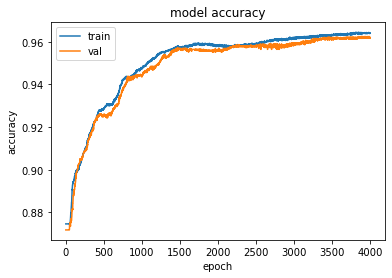

In [107]:
plt.plot(H2.history['accuracy'])
plt.plot(H2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

It looks like the oscillations on the accuracy are reduced. Lets increase the network size to see if that can help improve total accuracy. I will ad 40 neurons to the hidden layer for a total of 50 hidden neurons. 

In [109]:
# create the model using sequential Dense layers 
# Sequential model is feedforward neural network
model = Sequential()

# weight initialization method 
initializer = HeUniform()

# add hidden layers and output layer 
model.add(Dense(50, activation = 'sigmoid', input_shape = (3,), kernel_initializer = initializer)) 
#model.add(Dense(25, activation = 'tanh', kernel_initializer = initializer2))
model.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
model.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.009), metrics = ['accuracy'])

# prints model summary to show model details
model.summary()
H2 = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 50)                200       
                                                                 
 dense_27 (Dense)            (None, 3)                 153       
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
55/55 [==============================] - 1s 5ms/step - loss: 1.2706 - accuracy: 0.8091 - val_loss: 0.7484 - val_accuracy: 0.8718
Epoch 2/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.6677 - accuracy: 0.8746 - val_loss: 0.5977 - val_accuracy: 0.8718
Epoch 3/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.5623 - accuracy: 0.8746 - val_loss: 0.5248 - val_accuracy: 0.8718
Epoch 4/4000
55/55 [=====

55/55 [==============================] - 0s 2ms/step - loss: 0.2754 - accuracy: 0.9175 - val_loss: 0.2751 - val_accuracy: 0.9136
Epoch 111/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2749 - accuracy: 0.9174 - val_loss: 0.2746 - val_accuracy: 0.9149
Epoch 112/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2746 - accuracy: 0.9182 - val_loss: 0.2741 - val_accuracy: 0.9154
Epoch 113/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2741 - accuracy: 0.9182 - val_loss: 0.2736 - val_accuracy: 0.9149
Epoch 114/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2736 - accuracy: 0.9184 - val_loss: 0.2731 - val_accuracy: 0.9141
Epoch 115/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2732 - accuracy: 0.9179 - val_loss: 0.2726 - val_accuracy: 0.9145
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2728 - accuracy: 0.9178 - val_loss: 0.2722 - val_accuracy: 0.9136
Epoch 1

Epoch 167/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2504 - accuracy: 0.9202 - val_loss: 0.2497 - val_accuracy: 0.9201
Epoch 168/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.9207 - val_loss: 0.2494 - val_accuracy: 0.9201
Epoch 169/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2495 - accuracy: 0.9205 - val_loss: 0.2488 - val_accuracy: 0.9184
Epoch 170/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2491 - accuracy: 0.9215 - val_loss: 0.2484 - val_accuracy: 0.9193
Epoch 171/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.9215 - val_loss: 0.2479 - val_accuracy: 0.9193
Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2482 - accuracy: 0.9198 - val_loss: 0.2476 - val_accuracy: 0.9201
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2478 - accuracy: 0.9214 - val_loss: 0.2471 - val_accuracy:

Epoch 224/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.2250 - accuracy: 0.9228 - val_loss: 0.2241 - val_accuracy: 0.9206
Epoch 225/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.2246 - accuracy: 0.9227 - val_loss: 0.2238 - val_accuracy: 0.9206
Epoch 226/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.2242 - accuracy: 0.9227 - val_loss: 0.2231 - val_accuracy: 0.9197
Epoch 227/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.2237 - accuracy: 0.9228 - val_loss: 0.2227 - val_accuracy: 0.9201
Epoch 228/4000
55/55 [==============================] - 0s 6ms/step - loss: 0.2232 - accuracy: 0.9228 - val_loss: 0.2222 - val_accuracy: 0.9201
Epoch 229/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.2228 - accuracy: 0.9230 - val_loss: 0.2218 - val_accuracy: 0.9197
Epoch 230/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.2223 - accuracy: 0.9231 - val_loss: 0.2221 - val_accuracy:

Epoch 281/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1993 - accuracy: 0.9241 - val_loss: 0.1980 - val_accuracy: 0.9201
Epoch 282/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1989 - accuracy: 0.9240 - val_loss: 0.1975 - val_accuracy: 0.9214
Epoch 283/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1984 - accuracy: 0.9243 - val_loss: 0.1971 - val_accuracy: 0.9210
Epoch 284/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1979 - accuracy: 0.9235 - val_loss: 0.1968 - val_accuracy: 0.9210
Epoch 285/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1975 - accuracy: 0.9238 - val_loss: 0.1962 - val_accuracy: 0.9206
Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1971 - accuracy: 0.9238 - val_loss: 0.1957 - val_accuracy: 0.9206
Epoch 287/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.1966 - accuracy: 0.9238 - val_loss: 0.1955 - val_accuracy:

Epoch 338/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1736 - accuracy: 0.9247 - val_loss: 0.1723 - val_accuracy: 0.9227
Epoch 339/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1732 - accuracy: 0.9247 - val_loss: 0.1719 - val_accuracy: 0.9227
Epoch 340/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1728 - accuracy: 0.9256 - val_loss: 0.1712 - val_accuracy: 0.9218
Epoch 341/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1723 - accuracy: 0.9250 - val_loss: 0.1706 - val_accuracy: 0.9214
Epoch 342/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.9250 - val_loss: 0.1702 - val_accuracy: 0.9223
Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1714 - accuracy: 0.9250 - val_loss: 0.1698 - val_accuracy: 0.9210
Epoch 344/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1710 - accuracy: 0.9256 - val_loss: 0.1693 - val_accuracy:

Epoch 395/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1483 - accuracy: 0.9260 - val_loss: 0.1464 - val_accuracy: 0.9244
Epoch 396/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1478 - accuracy: 0.9258 - val_loss: 0.1462 - val_accuracy: 0.9240
Epoch 397/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1474 - accuracy: 0.9261 - val_loss: 0.1459 - val_accuracy: 0.9262
Epoch 398/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1470 - accuracy: 0.9256 - val_loss: 0.1451 - val_accuracy: 0.9214
Epoch 399/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1465 - accuracy: 0.9266 - val_loss: 0.1448 - val_accuracy: 0.9244
Epoch 400/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.1461 - accuracy: 0.9264 - val_loss: 0.1444 - val_accuracy: 0.9244
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.9263 - val_loss: 0.1438 - val_accuracy:

Epoch 452/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1250 - accuracy: 0.9287 - val_loss: 0.1234 - val_accuracy: 0.9288
Epoch 453/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1246 - accuracy: 0.9290 - val_loss: 0.1226 - val_accuracy: 0.9240
Epoch 454/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1242 - accuracy: 0.9290 - val_loss: 0.1224 - val_accuracy: 0.9283
Epoch 455/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1238 - accuracy: 0.9299 - val_loss: 0.1218 - val_accuracy: 0.9253
Epoch 456/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1235 - accuracy: 0.9290 - val_loss: 0.1217 - val_accuracy: 0.9288
Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1231 - accuracy: 0.9289 - val_loss: 0.1211 - val_accuracy: 0.9275
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1227 - accuracy: 0.9297 - val_loss: 0.1209 - val_accuracy:

Epoch 509/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1054 - accuracy: 0.9328 - val_loss: 0.1033 - val_accuracy: 0.9301
Epoch 510/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1051 - accuracy: 0.9323 - val_loss: 0.1031 - val_accuracy: 0.9305
Epoch 511/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9328 - val_loss: 0.1028 - val_accuracy: 0.9301
Epoch 512/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1045 - accuracy: 0.9326 - val_loss: 0.1024 - val_accuracy: 0.9279
Epoch 513/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1042 - accuracy: 0.9328 - val_loss: 0.1021 - val_accuracy: 0.9305
Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1039 - accuracy: 0.9328 - val_loss: 0.1021 - val_accuracy: 0.9309
Epoch 515/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.1036 - accuracy: 0.9329 - val_loss: 0.1016 - val_accuracy:

Epoch 566/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.9365 - val_loss: 0.0879 - val_accuracy: 0.9344
Epoch 567/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.9365 - val_loss: 0.0877 - val_accuracy: 0.9335
Epoch 568/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0895 - accuracy: 0.9369 - val_loss: 0.0875 - val_accuracy: 0.9335
Epoch 569/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0893 - accuracy: 0.9368 - val_loss: 0.0873 - val_accuracy: 0.9339
Epoch 570/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9371 - val_loss: 0.0870 - val_accuracy: 0.9339
Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0888 - accuracy: 0.9369 - val_loss: 0.0869 - val_accuracy: 0.9352
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0885 - accuracy: 0.9374 - val_loss: 0.0865 - val_accuracy:

Epoch 623/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0780 - accuracy: 0.9398 - val_loss: 0.0763 - val_accuracy: 0.9383
Epoch 624/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0778 - accuracy: 0.9400 - val_loss: 0.0761 - val_accuracy: 0.9383
Epoch 625/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9402 - val_loss: 0.0758 - val_accuracy: 0.9383
Epoch 626/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9400 - val_loss: 0.0758 - val_accuracy: 0.9387
Epoch 627/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0773 - accuracy: 0.9405 - val_loss: 0.0756 - val_accuracy: 0.9387
Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0771 - accuracy: 0.9405 - val_loss: 0.0755 - val_accuracy: 0.9396
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.9415 - val_loss: 0.0752 - val_accuracy:

Epoch 680/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.9444 - val_loss: 0.0674 - val_accuracy: 0.9439
Epoch 681/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9449 - val_loss: 0.0671 - val_accuracy: 0.9417
Epoch 682/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9446 - val_loss: 0.0670 - val_accuracy: 0.9408
Epoch 683/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0684 - accuracy: 0.9441 - val_loss: 0.0669 - val_accuracy: 0.9426
Epoch 684/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9446 - val_loss: 0.0666 - val_accuracy: 0.9413
Epoch 685/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9446 - val_loss: 0.0666 - val_accuracy: 0.9426
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9453 - val_loss: 0.0664 - val_accuracy:

Epoch 737/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0617 - accuracy: 0.9489 - val_loss: 0.0602 - val_accuracy: 0.9460
Epoch 738/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9485 - val_loss: 0.0601 - val_accuracy: 0.9465
Epoch 739/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9486 - val_loss: 0.0601 - val_accuracy: 0.9465
Epoch 740/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0613 - accuracy: 0.9482 - val_loss: 0.0601 - val_accuracy: 0.9469
Epoch 741/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9482 - val_loss: 0.0598 - val_accuracy: 0.9456
Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9487 - val_loss: 0.0598 - val_accuracy: 0.9469
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9485 - val_loss: 0.0597 - val_accuracy:

Epoch 794/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0559 - accuracy: 0.9503 - val_loss: 0.0548 - val_accuracy: 0.9499
Epoch 795/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9503 - val_loss: 0.0546 - val_accuracy: 0.9482
Epoch 796/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.9502 - val_loss: 0.0546 - val_accuracy: 0.9503
Epoch 797/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.9503 - val_loss: 0.0545 - val_accuracy: 0.9495
Epoch 798/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0555 - accuracy: 0.9503 - val_loss: 0.0544 - val_accuracy: 0.9499
Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0555 - accuracy: 0.9502 - val_loss: 0.0544 - val_accuracy: 0.9495
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0554 - accuracy: 0.9508 - val_loss: 0.0543 - val_accuracy:

Epoch 851/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0513 - accuracy: 0.9523 - val_loss: 0.0503 - val_accuracy: 0.9503
Epoch 852/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9523 - val_loss: 0.0503 - val_accuracy: 0.9503
Epoch 853/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9525 - val_loss: 0.0501 - val_accuracy: 0.9521
Epoch 854/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9525 - val_loss: 0.0501 - val_accuracy: 0.9503
Epoch 855/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9523 - val_loss: 0.0500 - val_accuracy: 0.9503
Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0509 - accuracy: 0.9526 - val_loss: 0.0500 - val_accuracy: 0.9503
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0509 - accuracy: 0.9523 - val_loss: 0.0499 - val_accuracy:

Epoch 908/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0475 - accuracy: 0.9551 - val_loss: 0.0468 - val_accuracy: 0.9529
Epoch 909/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0475 - accuracy: 0.9557 - val_loss: 0.0467 - val_accuracy: 0.9529
Epoch 910/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0474 - accuracy: 0.9549 - val_loss: 0.0465 - val_accuracy: 0.9525
Epoch 911/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9552 - val_loss: 0.0465 - val_accuracy: 0.9529
Epoch 912/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9552 - val_loss: 0.0465 - val_accuracy: 0.9529
Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.9552 - val_loss: 0.0464 - val_accuracy: 0.9525
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.9557 - val_loss: 0.0463 - val_accuracy:

Epoch 965/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0444 - accuracy: 0.9578 - val_loss: 0.0437 - val_accuracy: 0.9538
Epoch 966/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0444 - accuracy: 0.9580 - val_loss: 0.0436 - val_accuracy: 0.9542
Epoch 967/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9578 - val_loss: 0.0436 - val_accuracy: 0.9555
Epoch 968/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9574 - val_loss: 0.0435 - val_accuracy: 0.9538
Epoch 969/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.9580 - val_loss: 0.0436 - val_accuracy: 0.9547
Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.9577 - val_loss: 0.0435 - val_accuracy: 0.9542
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9580 - val_loss: 0.0434 - val_accuracy:

Epoch 1022/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0418 - accuracy: 0.9590 - val_loss: 0.0411 - val_accuracy: 0.9551
Epoch 1023/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0418 - accuracy: 0.9591 - val_loss: 0.0411 - val_accuracy: 0.9551
Epoch 1024/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0417 - accuracy: 0.9591 - val_loss: 0.0410 - val_accuracy: 0.9555
Epoch 1025/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0417 - accuracy: 0.9587 - val_loss: 0.0411 - val_accuracy: 0.9551
Epoch 1026/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9593 - val_loss: 0.0410 - val_accuracy: 0.9551
Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9595 - val_loss: 0.0410 - val_accuracy: 0.9555
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0415 - accuracy: 0.9593 - val_loss: 0.0411 - val_ac

55/55 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9620 - val_loss: 0.0372 - val_accuracy: 0.9598
Epoch 1135/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9621 - val_loss: 0.0372 - val_accuracy: 0.9603
Epoch 1136/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0377 - accuracy: 0.9621 - val_loss: 0.0372 - val_accuracy: 0.9607
Epoch 1137/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9621 - val_loss: 0.0371 - val_accuracy: 0.9607
Epoch 1138/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9627 - val_loss: 0.0370 - val_accuracy: 0.9598
Epoch 1139/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9620 - val_loss: 0.0370 - val_accuracy: 0.9603
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9626 - val_loss: 0.0370 - val_accuracy: 0.9611
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9650 - val_loss: 0.0342 - val_accuracy: 0.9616
Epoch 1247/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9646 - val_loss: 0.0341 - val_accuracy: 0.9624
Epoch 1248/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9654 - val_loss: 0.0341 - val_accuracy: 0.9620
Epoch 1249/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9652 - val_loss: 0.0341 - val_accuracy: 0.9624
Epoch 1250/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9649 - val_loss: 0.0341 - val_accuracy: 0.9629
Epoch 1251/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9652 - val_loss: 0.0340 - val_accuracy: 0.9629
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9654 - val_loss: 0.0340 - val_accuracy: 0.9629
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9667 - val_loss: 0.0318 - val_accuracy: 0.9637
Epoch 1359/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9670 - val_loss: 0.0318 - val_accuracy: 0.9642
Epoch 1360/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9675 - val_loss: 0.0317 - val_accuracy: 0.9672
Epoch 1361/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9676 - val_loss: 0.0318 - val_accuracy: 0.9646
Epoch 1362/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9675 - val_loss: 0.0318 - val_accuracy: 0.9646
Epoch 1363/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9672 - val_loss: 0.0317 - val_accuracy: 0.9646
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9673 - val_loss: 0.0317 - val_accuracy: 0.9646
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9688 - val_loss: 0.0299 - val_accuracy: 0.9693
Epoch 1471/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9689 - val_loss: 0.0300 - val_accuracy: 0.9676
Epoch 1472/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9689 - val_loss: 0.0299 - val_accuracy: 0.9689
Epoch 1473/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9686 - val_loss: 0.0299 - val_accuracy: 0.9685
Epoch 1474/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9686 - val_loss: 0.0299 - val_accuracy: 0.9689
Epoch 1475/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9686 - val_loss: 0.0299 - val_accuracy: 0.9685
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.9686 - val_loss: 0.0299 - val_accuracy: 0.9685
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9692 - val_loss: 0.0285 - val_accuracy: 0.9702
Epoch 1583/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9695 - val_loss: 0.0284 - val_accuracy: 0.9702
Epoch 1584/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9692 - val_loss: 0.0284 - val_accuracy: 0.9698
Epoch 1585/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9692 - val_loss: 0.0284 - val_accuracy: 0.9698
Epoch 1586/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9692 - val_loss: 0.0283 - val_accuracy: 0.9702
Epoch 1587/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9693 - val_loss: 0.0284 - val_accuracy: 0.9702
Epoch 1588/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.9692 - val_loss: 0.0284 - val_accuracy: 0.9702
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9702 - val_loss: 0.0272 - val_accuracy: 0.9702
Epoch 1695/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9701 - val_loss: 0.0272 - val_accuracy: 0.9706
Epoch 1696/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9703 - val_loss: 0.0272 - val_accuracy: 0.9706
Epoch 1697/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9706 - val_loss: 0.0272 - val_accuracy: 0.9702
Epoch 1698/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9709 - val_loss: 0.0272 - val_accuracy: 0.9702
Epoch 1699/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9702 - val_loss: 0.0271 - val_accuracy: 0.9706
Epoch 1700/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9703 - val_loss: 0.0271 - val_accuracy: 0.9702
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9712 - val_loss: 0.0261 - val_accuracy: 0.9711
Epoch 1807/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9712 - val_loss: 0.0261 - val_accuracy: 0.9715
Epoch 1808/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9713 - val_loss: 0.0261 - val_accuracy: 0.9715
Epoch 1809/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9713 - val_loss: 0.0261 - val_accuracy: 0.9711
Epoch 1810/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9713 - val_loss: 0.0260 - val_accuracy: 0.9728
Epoch 1811/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9711 - val_loss: 0.0261 - val_accuracy: 0.9715
Epoch 1812/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0264 - accuracy: 0.9709 - val_loss: 0.0261 - val_accuracy: 0.9715
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9718 - val_loss: 0.0252 - val_accuracy: 0.9728
Epoch 1919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9715 - val_loss: 0.0252 - val_accuracy: 0.9732
Epoch 1920/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9715 - val_loss: 0.0253 - val_accuracy: 0.9732
Epoch 1921/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9715 - val_loss: 0.0253 - val_accuracy: 0.9711
Epoch 1922/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9715 - val_loss: 0.0252 - val_accuracy: 0.9728
Epoch 1923/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9718 - val_loss: 0.0252 - val_accuracy: 0.9732
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9715 - val_loss: 0.0252 - val_accuracy: 0.9732
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9721 - val_loss: 0.0244 - val_accuracy: 0.9741
Epoch 2031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9726 - val_loss: 0.0244 - val_accuracy: 0.9741
Epoch 2032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9729 - val_loss: 0.0244 - val_accuracy: 0.9732
Epoch 2033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9724 - val_loss: 0.0244 - val_accuracy: 0.9741
Epoch 2034/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9725 - val_loss: 0.0244 - val_accuracy: 0.9737
Epoch 2035/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9725 - val_loss: 0.0244 - val_accuracy: 0.9741
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9726 - val_loss: 0.0244 - val_accuracy: 0.9741
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9726 - val_loss: 0.0237 - val_accuracy: 0.9741
Epoch 2143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9729 - val_loss: 0.0237 - val_accuracy: 0.9737
Epoch 2144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9725 - val_loss: 0.0236 - val_accuracy: 0.9741
Epoch 2145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9731 - val_loss: 0.0237 - val_accuracy: 0.9741
Epoch 2146/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9729 - val_loss: 0.0237 - val_accuracy: 0.9741
Epoch 2147/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9729 - val_loss: 0.0237 - val_accuracy: 0.9741
Epoch 2148/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9726 - val_loss: 0.0237 - val_accuracy: 0.9737
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9731 - val_loss: 0.0230 - val_accuracy: 0.9737
Epoch 2255/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9729 - val_loss: 0.0230 - val_accuracy: 0.9741
Epoch 2256/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9731 - val_loss: 0.0231 - val_accuracy: 0.9741
Epoch 2257/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9734 - val_loss: 0.0231 - val_accuracy: 0.9741
Epoch 2258/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9729 - val_loss: 0.0230 - val_accuracy: 0.9737
Epoch 2259/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9729 - val_loss: 0.0230 - val_accuracy: 0.9741
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9732 - val_loss: 0.0230 - val_accuracy: 0.9741
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9731 - val_loss: 0.0225 - val_accuracy: 0.9737
Epoch 2367/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9735 - val_loss: 0.0225 - val_accuracy: 0.9741
Epoch 2368/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9734 - val_loss: 0.0225 - val_accuracy: 0.9741
Epoch 2369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9725 - val_loss: 0.0226 - val_accuracy: 0.9741
Epoch 2370/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9739 - val_loss: 0.0225 - val_accuracy: 0.9737
Epoch 2371/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9731 - val_loss: 0.0225 - val_accuracy: 0.9745
Epoch 2372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9729 - val_loss: 0.0225 - val_accuracy: 0.9741
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9737 - val_loss: 0.0220 - val_accuracy: 0.9750
Epoch 2479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9738 - val_loss: 0.0219 - val_accuracy: 0.9750
Epoch 2480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9737 - val_loss: 0.0220 - val_accuracy: 0.9750
Epoch 2481/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9737 - val_loss: 0.0219 - val_accuracy: 0.9750
Epoch 2482/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9737 - val_loss: 0.0219 - val_accuracy: 0.9750
Epoch 2483/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9738 - val_loss: 0.0220 - val_accuracy: 0.9754
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9737 - val_loss: 0.0219 - val_accuracy: 0.9750
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9747 - val_loss: 0.0215 - val_accuracy: 0.9750
Epoch 2591/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9745 - val_loss: 0.0215 - val_accuracy: 0.9750
Epoch 2592/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9749 - val_loss: 0.0215 - val_accuracy: 0.9754
Epoch 2593/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9742 - val_loss: 0.0215 - val_accuracy: 0.9750
Epoch 2594/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9748 - val_loss: 0.0215 - val_accuracy: 0.9758
Epoch 2595/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9747 - val_loss: 0.0215 - val_accuracy: 0.9750
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9747 - val_loss: 0.0215 - val_accuracy: 0.9745
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9752 - val_loss: 0.0211 - val_accuracy: 0.9750
Epoch 2703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9749 - val_loss: 0.0211 - val_accuracy: 0.9750
Epoch 2704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9752 - val_loss: 0.0211 - val_accuracy: 0.9754
Epoch 2705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9754 - val_loss: 0.0211 - val_accuracy: 0.9750
Epoch 2706/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9751 - val_loss: 0.0211 - val_accuracy: 0.9750
Epoch 2707/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9754 - val_loss: 0.0211 - val_accuracy: 0.9754
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.9751 - val_loss: 0.0211 - val_accuracy: 0.9754
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9754 - val_loss: 0.0208 - val_accuracy: 0.9758
Epoch 2815/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9754 - val_loss: 0.0207 - val_accuracy: 0.9754
Epoch 2816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9757 - val_loss: 0.0207 - val_accuracy: 0.9745
Epoch 2817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9755 - val_loss: 0.0207 - val_accuracy: 0.9750
Epoch 2818/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9752 - val_loss: 0.0207 - val_accuracy: 0.9754
Epoch 2819/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9757 - val_loss: 0.0207 - val_accuracy: 0.9754
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9755 - val_loss: 0.0207 - val_accuracy: 0.9754
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.9762 - val_loss: 0.0204 - val_accuracy: 0.9754
Epoch 2927/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9758 - val_loss: 0.0204 - val_accuracy: 0.9758
Epoch 2928/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0205 - accuracy: 0.9760 - val_loss: 0.0204 - val_accuracy: 0.9754
Epoch 2929/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0205 - accuracy: 0.9758 - val_loss: 0.0204 - val_accuracy: 0.9754
Epoch 2930/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.9761 - val_loss: 0.0203 - val_accuracy: 0.9750
Epoch 2931/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9755 - val_loss: 0.0203 - val_accuracy: 0.9745
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9760 - val_loss: 0.0203 - val_accuracy: 0.9750
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9760 - val_loss: 0.0201 - val_accuracy: 0.9754
Epoch 3039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9757 - val_loss: 0.0201 - val_accuracy: 0.9754
Epoch 3040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9757 - val_loss: 0.0200 - val_accuracy: 0.9754
Epoch 3041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9760 - val_loss: 0.0201 - val_accuracy: 0.9754
Epoch 3042/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9761 - val_loss: 0.0200 - val_accuracy: 0.9745
Epoch 3043/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9758 - val_loss: 0.0200 - val_accuracy: 0.9745
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9757 - val_loss: 0.0201 - val_accuracy: 0.9754
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9762 - val_loss: 0.0198 - val_accuracy: 0.9754
Epoch 3151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9757 - val_loss: 0.0198 - val_accuracy: 0.9745
Epoch 3152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9761 - val_loss: 0.0198 - val_accuracy: 0.9745
Epoch 3153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9760 - val_loss: 0.0198 - val_accuracy: 0.9745
Epoch 3154/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9764 - val_loss: 0.0198 - val_accuracy: 0.9754
Epoch 3155/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9758 - val_loss: 0.0197 - val_accuracy: 0.9745
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9761 - val_loss: 0.0197 - val_accuracy: 0.9745
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9758 - val_loss: 0.0195 - val_accuracy: 0.9754
Epoch 3263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9762 - val_loss: 0.0196 - val_accuracy: 0.9750
Epoch 3264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9760 - val_loss: 0.0195 - val_accuracy: 0.9745
Epoch 3265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9760 - val_loss: 0.0196 - val_accuracy: 0.9758
Epoch 3266/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9760 - val_loss: 0.0195 - val_accuracy: 0.9754
Epoch 3267/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9764 - val_loss: 0.0195 - val_accuracy: 0.9745
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9765 - val_loss: 0.0195 - val_accuracy: 0.9745
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9764 - val_loss: 0.0192 - val_accuracy: 0.9745
Epoch 3375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9770 - val_loss: 0.0192 - val_accuracy: 0.9750
Epoch 3376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9762 - val_loss: 0.0192 - val_accuracy: 0.9745
Epoch 3377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9761 - val_loss: 0.0192 - val_accuracy: 0.9758
Epoch 3378/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9767 - val_loss: 0.0193 - val_accuracy: 0.9754
Epoch 3379/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9765 - val_loss: 0.0192 - val_accuracy: 0.9750
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9770 - val_loss: 0.0193 - val_accuracy: 0.9754
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9767 - val_loss: 0.0190 - val_accuracy: 0.9754
Epoch 3487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9774 - val_loss: 0.0190 - val_accuracy: 0.9750
Epoch 3488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9770 - val_loss: 0.0190 - val_accuracy: 0.9750
Epoch 3489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9770 - val_loss: 0.0190 - val_accuracy: 0.9754
Epoch 3490/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9765 - val_loss: 0.0190 - val_accuracy: 0.9750
Epoch 3491/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9771 - val_loss: 0.0190 - val_accuracy: 0.9750
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.9772 - val_loss: 0.0190 - val_accuracy: 0.9750
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9772 - val_loss: 0.0188 - val_accuracy: 0.9750
Epoch 3599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9772 - val_loss: 0.0188 - val_accuracy: 0.9750
Epoch 3600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9770 - val_loss: 0.0189 - val_accuracy: 0.9750
Epoch 3601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9770 - val_loss: 0.0188 - val_accuracy: 0.9750
Epoch 3602/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9768 - val_loss: 0.0188 - val_accuracy: 0.9750
Epoch 3603/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9772 - val_loss: 0.0188 - val_accuracy: 0.9754
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9774 - val_loss: 0.0189 - val_accuracy: 0.9763
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0186 - accuracy: 0.9770 - val_loss: 0.0186 - val_accuracy: 0.9758
Epoch 3711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0186 - accuracy: 0.9775 - val_loss: 0.0186 - val_accuracy: 0.9750
Epoch 3712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0186 - accuracy: 0.9780 - val_loss: 0.0186 - val_accuracy: 0.9750
Epoch 3713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9770 - val_loss: 0.0186 - val_accuracy: 0.9758
Epoch 3714/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9771 - val_loss: 0.0186 - val_accuracy: 0.9754
Epoch 3715/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9775 - val_loss: 0.0186 - val_accuracy: 0.9754
Epoch 3716/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0185 - accuracy: 0.9772 - val_loss: 0.0186 - val_accuracy: 0.9754
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9775 - val_loss: 0.0184 - val_accuracy: 0.9758
Epoch 3823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9778 - val_loss: 0.0184 - val_accuracy: 0.9758
Epoch 3824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9772 - val_loss: 0.0184 - val_accuracy: 0.9763
Epoch 3825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9783 - val_loss: 0.0184 - val_accuracy: 0.9763
Epoch 3826/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9774 - val_loss: 0.0184 - val_accuracy: 0.9754
Epoch 3827/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9780 - val_loss: 0.0184 - val_accuracy: 0.9758
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9772 - val_loss: 0.0184 - val_accuracy: 0.9763
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9777 - val_loss: 0.0182 - val_accuracy: 0.9763
Epoch 3935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9775 - val_loss: 0.0182 - val_accuracy: 0.9763
Epoch 3936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9774 - val_loss: 0.0182 - val_accuracy: 0.9763
Epoch 3937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9775 - val_loss: 0.0182 - val_accuracy: 0.9767
Epoch 3938/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9781 - val_loss: 0.0182 - val_accuracy: 0.9767
Epoch 3939/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9777 - val_loss: 0.0182 - val_accuracy: 0.9763
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9775 - val_loss: 0.0182 - val_accuracy: 0.9763
E

The increased network size seemed to improve the accuracy a little bit. Lets see if the tanh activation function for the hidden layer improves the accuracy. 

In [110]:
# create the model using sequential Dense layers 
# Sequential model is feedforward neural network
model = Sequential()

# weight initialization method 
initializer = HeUniform()

# add hidden layers and output layer 
model.add(Dense(50, activation = 'tanh', input_shape = (3,), kernel_initializer = initializer)) 
#model.add(Dense(25, activation = 'tanh', kernel_initializer = initializer2))
model.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
model.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.009), metrics = ['accuracy'])

# prints model summary to show model details
model.summary()
H2 = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 50)                200       
                                                                 
 dense_29 (Dense)            (None, 3)                 153       
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
55/55 [==============================] - 1s 5ms/step - loss: 1.2168 - accuracy: 0.8156 - val_loss: 0.7818 - val_accuracy: 0.8472
Epoch 2/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.8580 - val_loss: 0.6063 - val_accuracy: 0.8657
Epoch 3/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.5699 - accuracy: 0.8855 - val_loss: 0.5105 - val_accuracy: 0.8834
Epoch 4/4000
55/55 [=====

55/55 [==============================] - 0s 2ms/step - loss: 0.0897 - accuracy: 0.9410 - val_loss: 0.0868 - val_accuracy: 0.9365
Epoch 111/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9410 - val_loss: 0.0862 - val_accuracy: 0.9400
Epoch 112/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0882 - accuracy: 0.9413 - val_loss: 0.0854 - val_accuracy: 0.9396
Epoch 113/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0874 - accuracy: 0.9415 - val_loss: 0.0847 - val_accuracy: 0.9396
Epoch 114/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0866 - accuracy: 0.9417 - val_loss: 0.0837 - val_accuracy: 0.9396
Epoch 115/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0858 - accuracy: 0.9420 - val_loss: 0.0832 - val_accuracy: 0.9404
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0852 - accuracy: 0.9417 - val_loss: 0.0826 - val_accuracy: 0.9408
Epoch 1

Epoch 167/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0577 - accuracy: 0.9532 - val_loss: 0.0559 - val_accuracy: 0.9516
Epoch 168/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.9529 - val_loss: 0.0554 - val_accuracy: 0.9529
Epoch 169/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0569 - accuracy: 0.9528 - val_loss: 0.0551 - val_accuracy: 0.9521
Epoch 170/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.9531 - val_loss: 0.0547 - val_accuracy: 0.9529
Epoch 171/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0561 - accuracy: 0.9533 - val_loss: 0.0544 - val_accuracy: 0.9529
Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9541 - val_loss: 0.0541 - val_accuracy: 0.9542
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0555 - accuracy: 0.9533 - val_loss: 0.0538 - val_accuracy:

Epoch 224/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0418 - accuracy: 0.9621 - val_loss: 0.0409 - val_accuracy: 0.9633
Epoch 225/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9624 - val_loss: 0.0407 - val_accuracy: 0.9637
Epoch 226/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0414 - accuracy: 0.9626 - val_loss: 0.0406 - val_accuracy: 0.9633
Epoch 227/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9623 - val_loss: 0.0404 - val_accuracy: 0.9637
Epoch 228/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.9626 - val_loss: 0.0402 - val_accuracy: 0.9642
Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.9630 - val_loss: 0.0401 - val_accuracy: 0.9642
Epoch 230/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0406 - accuracy: 0.9624 - val_loss: 0.0398 - val_accuracy:

Epoch 281/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9712 - val_loss: 0.0331 - val_accuracy: 0.9689
Epoch 282/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0332 - accuracy: 0.9716 - val_loss: 0.0331 - val_accuracy: 0.9689
Epoch 283/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0331 - accuracy: 0.9713 - val_loss: 0.0329 - val_accuracy: 0.9689
Epoch 284/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9712 - val_loss: 0.0328 - val_accuracy: 0.9689
Epoch 285/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0329 - accuracy: 0.9715 - val_loss: 0.0327 - val_accuracy: 0.9693
Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.9719 - val_loss: 0.0327 - val_accuracy: 0.9689
Epoch 287/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0327 - accuracy: 0.9718 - val_loss: 0.0326 - val_accuracy:

Epoch 338/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9744 - val_loss: 0.0287 - val_accuracy: 0.9724
Epoch 339/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9742 - val_loss: 0.0287 - val_accuracy: 0.9724
Epoch 340/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9745 - val_loss: 0.0286 - val_accuracy: 0.9732
Epoch 341/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.9741 - val_loss: 0.0285 - val_accuracy: 0.9719
Epoch 342/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9745 - val_loss: 0.0285 - val_accuracy: 0.9728
Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9745 - val_loss: 0.0285 - val_accuracy: 0.9728
Epoch 344/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9744 - val_loss: 0.0284 - val_accuracy:

Epoch 395/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9774 - val_loss: 0.0261 - val_accuracy: 0.9750
Epoch 396/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9768 - val_loss: 0.0260 - val_accuracy: 0.9750
Epoch 397/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9770 - val_loss: 0.0260 - val_accuracy: 0.9741
Epoch 398/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9777 - val_loss: 0.0261 - val_accuracy: 0.9758
Epoch 399/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9762 - val_loss: 0.0259 - val_accuracy: 0.9745
Epoch 400/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9767 - val_loss: 0.0259 - val_accuracy: 0.9750
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0256 - accuracy: 0.9765 - val_loss: 0.0259 - val_accuracy:

Epoch 452/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9775 - val_loss: 0.0244 - val_accuracy: 0.9750
Epoch 453/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9772 - val_loss: 0.0243 - val_accuracy: 0.9750
Epoch 454/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9781 - val_loss: 0.0242 - val_accuracy: 0.9763
Epoch 455/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9781 - val_loss: 0.0241 - val_accuracy: 0.9758
Epoch 456/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9774 - val_loss: 0.0241 - val_accuracy: 0.9763
Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9777 - val_loss: 0.0241 - val_accuracy: 0.9758
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0237 - accuracy: 0.9780 - val_loss: 0.0241 - val_accuracy:

Epoch 509/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9788 - val_loss: 0.0229 - val_accuracy: 0.9775
Epoch 510/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9784 - val_loss: 0.0228 - val_accuracy: 0.9780
Epoch 511/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0225 - accuracy: 0.9785 - val_loss: 0.0228 - val_accuracy: 0.9780
Epoch 512/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9780 - val_loss: 0.0229 - val_accuracy: 0.9775
Epoch 513/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9783 - val_loss: 0.0228 - val_accuracy: 0.9775
Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9783 - val_loss: 0.0228 - val_accuracy: 0.9775
Epoch 515/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9785 - val_loss: 0.0228 - val_accuracy:

Epoch 566/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0214 - accuracy: 0.9783 - val_loss: 0.0218 - val_accuracy: 0.9788
Epoch 567/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9788 - val_loss: 0.0218 - val_accuracy: 0.9801
Epoch 568/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9788 - val_loss: 0.0218 - val_accuracy: 0.9780
Epoch 569/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9788 - val_loss: 0.0218 - val_accuracy: 0.9784
Epoch 570/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9788 - val_loss: 0.0218 - val_accuracy: 0.9784
Epoch 571/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9785 - val_loss: 0.0218 - val_accuracy: 0.9784
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9785 - val_loss: 0.0217 - val_accuracy:

Epoch 623/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0204 - accuracy: 0.9791 - val_loss: 0.0210 - val_accuracy: 0.9806
Epoch 624/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0204 - accuracy: 0.9791 - val_loss: 0.0209 - val_accuracy: 0.9801
Epoch 625/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9793 - val_loss: 0.0209 - val_accuracy: 0.9801
Epoch 626/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9790 - val_loss: 0.0209 - val_accuracy: 0.9797
Epoch 627/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9791 - val_loss: 0.0208 - val_accuracy: 0.9806
Epoch 628/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0203 - accuracy: 0.9794 - val_loss: 0.0209 - val_accuracy: 0.9797
Epoch 629/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0203 - accuracy: 0.9794 - val_loss: 0.0208 - val_accuracy:

Epoch 680/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9793 - val_loss: 0.0202 - val_accuracy: 0.9814
Epoch 681/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9796 - val_loss: 0.0201 - val_accuracy: 0.9814
Epoch 682/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9793 - val_loss: 0.0201 - val_accuracy: 0.9814
Epoch 683/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9791 - val_loss: 0.0201 - val_accuracy: 0.9814
Epoch 684/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9794 - val_loss: 0.0200 - val_accuracy: 0.9810
Epoch 685/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0195 - accuracy: 0.9794 - val_loss: 0.0200 - val_accuracy: 0.9814
Epoch 686/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0195 - accuracy: 0.9794 - val_loss: 0.0202 - val_accuracy:

Epoch 737/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9796 - val_loss: 0.0194 - val_accuracy: 0.9819
Epoch 738/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9797 - val_loss: 0.0194 - val_accuracy: 0.9819
Epoch 739/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.9791 - val_loss: 0.0194 - val_accuracy: 0.9819
Epoch 740/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9793 - val_loss: 0.0194 - val_accuracy: 0.9819
Epoch 741/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.9794 - val_loss: 0.0193 - val_accuracy: 0.9819
Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.9794 - val_loss: 0.0194 - val_accuracy: 0.9814
Epoch 743/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9796 - val_loss: 0.0193 - val_accuracy:

Epoch 794/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9796 - val_loss: 0.0188 - val_accuracy: 0.9814
Epoch 795/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9797 - val_loss: 0.0189 - val_accuracy: 0.9819
Epoch 796/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9796 - val_loss: 0.0188 - val_accuracy: 0.9819
Epoch 797/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9793 - val_loss: 0.0188 - val_accuracy: 0.9814
Epoch 798/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9796 - val_loss: 0.0189 - val_accuracy: 0.9814
Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9793 - val_loss: 0.0188 - val_accuracy: 0.9819
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9794 - val_loss: 0.0188 - val_accuracy:

Epoch 851/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9797 - val_loss: 0.0184 - val_accuracy: 0.9819
Epoch 852/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9800 - val_loss: 0.0184 - val_accuracy: 0.9819
Epoch 853/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9797 - val_loss: 0.0183 - val_accuracy: 0.9823
Epoch 854/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9797 - val_loss: 0.0183 - val_accuracy: 0.9823
Epoch 855/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9794 - val_loss: 0.0184 - val_accuracy: 0.9823
Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9797 - val_loss: 0.0183 - val_accuracy: 0.9819
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9794 - val_loss: 0.0183 - val_accuracy:

Epoch 908/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9798 - val_loss: 0.0179 - val_accuracy: 0.9814
Epoch 909/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9797 - val_loss: 0.0180 - val_accuracy: 0.9810
Epoch 910/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9794 - val_loss: 0.0179 - val_accuracy: 0.9819
Epoch 911/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9796 - val_loss: 0.0179 - val_accuracy: 0.9814
Epoch 912/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9797 - val_loss: 0.0179 - val_accuracy: 0.9819
Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9791 - val_loss: 0.0179 - val_accuracy: 0.9819
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9796 - val_loss: 0.0178 - val_accuracy:

Epoch 965/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9797 - val_loss: 0.0175 - val_accuracy: 0.9819
Epoch 966/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0169 - accuracy: 0.9798 - val_loss: 0.0176 - val_accuracy: 0.9810
Epoch 967/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9801 - val_loss: 0.0174 - val_accuracy: 0.9810
Epoch 968/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9798 - val_loss: 0.0174 - val_accuracy: 0.9823
Epoch 969/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9798 - val_loss: 0.0174 - val_accuracy: 0.9823
Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9797 - val_loss: 0.0174 - val_accuracy: 0.9819
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9796 - val_loss: 0.0175 - val_accuracy:

Epoch 1022/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9794 - val_loss: 0.0171 - val_accuracy: 0.9823
Epoch 1023/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9796 - val_loss: 0.0172 - val_accuracy: 0.9823
Epoch 1024/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9796 - val_loss: 0.0171 - val_accuracy: 0.9819
Epoch 1025/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0166 - accuracy: 0.9797 - val_loss: 0.0171 - val_accuracy: 0.9832
Epoch 1026/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0165 - accuracy: 0.9797 - val_loss: 0.0170 - val_accuracy: 0.9836
Epoch 1027/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9796 - val_loss: 0.0171 - val_accuracy: 0.9832
Epoch 1028/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0165 - accuracy: 0.9797 - val_loss: 0.0170 - val_ac

55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9800 - val_loss: 0.0165 - val_accuracy: 0.9840
Epoch 1135/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9800 - val_loss: 0.0164 - val_accuracy: 0.9836
Epoch 1136/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9793 - val_loss: 0.0166 - val_accuracy: 0.9840
Epoch 1137/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9800 - val_loss: 0.0164 - val_accuracy: 0.9840
Epoch 1138/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9797 - val_loss: 0.0164 - val_accuracy: 0.9845
Epoch 1139/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9793 - val_loss: 0.0164 - val_accuracy: 0.9836
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9798 - val_loss: 0.0164 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9801 - val_loss: 0.0160 - val_accuracy: 0.9840
Epoch 1247/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9798 - val_loss: 0.0159 - val_accuracy: 0.9853
Epoch 1248/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9801 - val_loss: 0.0159 - val_accuracy: 0.9845
Epoch 1249/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9800 - val_loss: 0.0159 - val_accuracy: 0.9840
Epoch 1250/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9798 - val_loss: 0.0159 - val_accuracy: 0.9845
Epoch 1251/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9800 - val_loss: 0.0159 - val_accuracy: 0.9840
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9800 - val_loss: 0.0158 - val_accuracy: 0.9840
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9804 - val_loss: 0.0155 - val_accuracy: 0.9845
Epoch 1359/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9804 - val_loss: 0.0155 - val_accuracy: 0.9845
Epoch 1360/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9803 - val_loss: 0.0154 - val_accuracy: 0.9845
Epoch 1361/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9803 - val_loss: 0.0155 - val_accuracy: 0.9849
Epoch 1362/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9803 - val_loss: 0.0155 - val_accuracy: 0.9845
Epoch 1363/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9801 - val_loss: 0.0154 - val_accuracy: 0.9845
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9803 - val_loss: 0.0154 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9803 - val_loss: 0.0150 - val_accuracy: 0.9840
Epoch 1471/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9807 - val_loss: 0.0150 - val_accuracy: 0.9840
Epoch 1472/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9808 - val_loss: 0.0150 - val_accuracy: 0.9845
Epoch 1473/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9807 - val_loss: 0.0150 - val_accuracy: 0.9840
Epoch 1474/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9803 - val_loss: 0.0150 - val_accuracy: 0.9845
Epoch 1475/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9808 - val_loss: 0.0150 - val_accuracy: 0.9858
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9804 - val_loss: 0.0150 - val_accuracy: 0.9840
E

55/55 [==============================] - 0s 4ms/step - loss: 0.0141 - accuracy: 0.9806 - val_loss: 0.0147 - val_accuracy: 0.9845
Epoch 1583/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0141 - accuracy: 0.9806 - val_loss: 0.0146 - val_accuracy: 0.9845
Epoch 1584/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0141 - accuracy: 0.9807 - val_loss: 0.0147 - val_accuracy: 0.9849
Epoch 1585/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0141 - accuracy: 0.9806 - val_loss: 0.0146 - val_accuracy: 0.9845
Epoch 1586/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9806 - val_loss: 0.0146 - val_accuracy: 0.9832
Epoch 1587/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9808 - val_loss: 0.0146 - val_accuracy: 0.9858
Epoch 1588/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9808 - val_loss: 0.0146 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9810 - val_loss: 0.0143 - val_accuracy: 0.9845
Epoch 1695/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9807 - val_loss: 0.0143 - val_accuracy: 0.9849
Epoch 1696/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9808 - val_loss: 0.0143 - val_accuracy: 0.9849
Epoch 1697/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.9810 - val_loss: 0.0143 - val_accuracy: 0.9845
Epoch 1698/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.9807 - val_loss: 0.0143 - val_accuracy: 0.9853
Epoch 1699/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.9808 - val_loss: 0.0142 - val_accuracy: 0.9853
Epoch 1700/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.9810 - val_loss: 0.0142 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9808 - val_loss: 0.0139 - val_accuracy: 0.9845
Epoch 1807/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 0.9814 - val_loss: 0.0139 - val_accuracy: 0.9853
Epoch 1808/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9807 - val_loss: 0.0139 - val_accuracy: 0.9849
Epoch 1809/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9813 - val_loss: 0.0139 - val_accuracy: 0.9858
Epoch 1810/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9810 - val_loss: 0.0139 - val_accuracy: 0.9858
Epoch 1811/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9808 - val_loss: 0.0139 - val_accuracy: 0.9853
Epoch 1812/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9813 - val_loss: 0.0140 - val_accuracy: 0.9853
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9813 - val_loss: 0.0136 - val_accuracy: 0.9858
Epoch 1919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9813 - val_loss: 0.0136 - val_accuracy: 0.9858
Epoch 1920/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9811 - val_loss: 0.0137 - val_accuracy: 0.9858
Epoch 1921/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9817 - val_loss: 0.0136 - val_accuracy: 0.9862
Epoch 1922/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9816 - val_loss: 0.0137 - val_accuracy: 0.9862
Epoch 1923/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9814 - val_loss: 0.0136 - val_accuracy: 0.9858
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9816 - val_loss: 0.0136 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9817 - val_loss: 0.0133 - val_accuracy: 0.9866
Epoch 2031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9819 - val_loss: 0.0133 - val_accuracy: 0.9858
Epoch 2032/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9817 - val_loss: 0.0133 - val_accuracy: 0.9849
Epoch 2033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9820 - val_loss: 0.0133 - val_accuracy: 0.9858
Epoch 2034/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9820 - val_loss: 0.0134 - val_accuracy: 0.9858
Epoch 2035/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9821 - val_loss: 0.0134 - val_accuracy: 0.9862
Epoch 2036/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9820 - val_loss: 0.0133 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9820 - val_loss: 0.0130 - val_accuracy: 0.9853
Epoch 2143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9821 - val_loss: 0.0131 - val_accuracy: 0.9853
Epoch 2144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9823 - val_loss: 0.0130 - val_accuracy: 0.9866
Epoch 2145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9823 - val_loss: 0.0130 - val_accuracy: 0.9853
Epoch 2146/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9821 - val_loss: 0.0130 - val_accuracy: 0.9866
Epoch 2147/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9823 - val_loss: 0.0130 - val_accuracy: 0.9858
Epoch 2148/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9823 - val_loss: 0.0130 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 4ms/step - loss: 0.0124 - accuracy: 0.9824 - val_loss: 0.0128 - val_accuracy: 0.9866
Epoch 2255/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0124 - accuracy: 0.9821 - val_loss: 0.0129 - val_accuracy: 0.9862
Epoch 2256/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 0.9823 - val_loss: 0.0128 - val_accuracy: 0.9862
Epoch 2257/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 0.9823 - val_loss: 0.0129 - val_accuracy: 0.9862
Epoch 2258/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 0.9820 - val_loss: 0.0129 - val_accuracy: 0.9862
Epoch 2259/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9826 - val_loss: 0.0128 - val_accuracy: 0.9866
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9823 - val_loss: 0.0128 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9823 - val_loss: 0.0126 - val_accuracy: 0.9862
Epoch 2367/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9823 - val_loss: 0.0126 - val_accuracy: 0.9862
Epoch 2368/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9823 - val_loss: 0.0126 - val_accuracy: 0.9862
Epoch 2369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9821 - val_loss: 0.0126 - val_accuracy: 0.9858
Epoch 2370/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9826 - val_loss: 0.0126 - val_accuracy: 0.9862
Epoch 2371/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9821 - val_loss: 0.0126 - val_accuracy: 0.9849
Epoch 2372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9827 - val_loss: 0.0126 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9823 - val_loss: 0.0124 - val_accuracy: 0.9858
Epoch 2479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9824 - val_loss: 0.0124 - val_accuracy: 0.9866
Epoch 2480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9823 - val_loss: 0.0124 - val_accuracy: 0.9858
Epoch 2481/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9823 - val_loss: 0.0124 - val_accuracy: 0.9862
Epoch 2482/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9824 - val_loss: 0.0124 - val_accuracy: 0.9858
Epoch 2483/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9829 - val_loss: 0.0124 - val_accuracy: 0.9858
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9830 - val_loss: 0.0125 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9823 - val_loss: 0.0122 - val_accuracy: 0.9858
Epoch 2591/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 0.9820 - val_loss: 0.0122 - val_accuracy: 0.9866
Epoch 2592/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 0.9824 - val_loss: 0.0122 - val_accuracy: 0.9858
Epoch 2593/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 0.9826 - val_loss: 0.0122 - val_accuracy: 0.9866
Epoch 2594/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9826 - val_loss: 0.0122 - val_accuracy: 0.9858
Epoch 2595/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 0.9827 - val_loss: 0.0122 - val_accuracy: 0.9866
Epoch 2596/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 0.9826 - val_loss: 0.0122 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9827 - val_loss: 0.0121 - val_accuracy: 0.9866
Epoch 2703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9823 - val_loss: 0.0120 - val_accuracy: 0.9858
Epoch 2704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9827 - val_loss: 0.0120 - val_accuracy: 0.9858
Epoch 2705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9829 - val_loss: 0.0120 - val_accuracy: 0.9866
Epoch 2706/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9827 - val_loss: 0.0120 - val_accuracy: 0.9862
Epoch 2707/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9826 - val_loss: 0.0120 - val_accuracy: 0.9862
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9829 - val_loss: 0.0121 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9827 - val_loss: 0.0119 - val_accuracy: 0.9866
Epoch 2815/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9834 - val_loss: 0.0119 - val_accuracy: 0.9866
Epoch 2816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9832 - val_loss: 0.0118 - val_accuracy: 0.9862
Epoch 2817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9829 - val_loss: 0.0118 - val_accuracy: 0.9866
Epoch 2818/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9830 - val_loss: 0.0118 - val_accuracy: 0.9858
Epoch 2819/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9829 - val_loss: 0.0118 - val_accuracy: 0.9862
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9827 - val_loss: 0.0118 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9829 - val_loss: 0.0116 - val_accuracy: 0.9866
Epoch 2927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9832 - val_loss: 0.0117 - val_accuracy: 0.9866
Epoch 2928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9833 - val_loss: 0.0116 - val_accuracy: 0.9862
Epoch 2929/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9832 - val_loss: 0.0117 - val_accuracy: 0.9866
Epoch 2930/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9829 - val_loss: 0.0117 - val_accuracy: 0.9866
Epoch 2931/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9829 - val_loss: 0.0116 - val_accuracy: 0.9866
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9829 - val_loss: 0.0117 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9830 - val_loss: 0.0115 - val_accuracy: 0.9866
Epoch 3039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9834 - val_loss: 0.0115 - val_accuracy: 0.9866
Epoch 3040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9833 - val_loss: 0.0116 - val_accuracy: 0.9870
Epoch 3041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9832 - val_loss: 0.0115 - val_accuracy: 0.9866
Epoch 3042/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9829 - val_loss: 0.0116 - val_accuracy: 0.9866
Epoch 3043/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9832 - val_loss: 0.0115 - val_accuracy: 0.9866
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9833 - val_loss: 0.0115 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9829 - val_loss: 0.0114 - val_accuracy: 0.9866
Epoch 3151/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.9833 - val_loss: 0.0115 - val_accuracy: 0.9866
Epoch 3152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9834 - val_loss: 0.0114 - val_accuracy: 0.9866
Epoch 3153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9832 - val_loss: 0.0114 - val_accuracy: 0.9866
Epoch 3154/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9830 - val_loss: 0.0114 - val_accuracy: 0.9866
Epoch 3155/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9833 - val_loss: 0.0113 - val_accuracy: 0.9866
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9832 - val_loss: 0.0114 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9834 - val_loss: 0.0112 - val_accuracy: 0.9870
Epoch 3263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9829 - val_loss: 0.0112 - val_accuracy: 0.9870
Epoch 3264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9834 - val_loss: 0.0112 - val_accuracy: 0.9862
Epoch 3265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9829 - val_loss: 0.0112 - val_accuracy: 0.9866
Epoch 3266/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9834 - val_loss: 0.0113 - val_accuracy: 0.9866
Epoch 3267/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0109 - accuracy: 0.9833 - val_loss: 0.0112 - val_accuracy: 0.9870
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9834 - val_loss: 0.0112 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9836 - val_loss: 0.0111 - val_accuracy: 0.9870
Epoch 3375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9832 - val_loss: 0.0111 - val_accuracy: 0.9870
Epoch 3376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9833 - val_loss: 0.0111 - val_accuracy: 0.9866
Epoch 3377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9833 - val_loss: 0.0111 - val_accuracy: 0.9866
Epoch 3378/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9834 - val_loss: 0.0112 - val_accuracy: 0.9866
Epoch 3379/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9833 - val_loss: 0.0111 - val_accuracy: 0.9866
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9834 - val_loss: 0.0111 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9833 - val_loss: 0.0110 - val_accuracy: 0.9870
Epoch 3487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9834 - val_loss: 0.0111 - val_accuracy: 0.9866
Epoch 3488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9836 - val_loss: 0.0110 - val_accuracy: 0.9870
Epoch 3489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9833 - val_loss: 0.0110 - val_accuracy: 0.9870
Epoch 3490/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9833 - val_loss: 0.0109 - val_accuracy: 0.9870
Epoch 3491/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9836 - val_loss: 0.0109 - val_accuracy: 0.9875
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9833 - val_loss: 0.0109 - val_accuracy: 0.9870
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9834 - val_loss: 0.0109 - val_accuracy: 0.9875
Epoch 3599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9833 - val_loss: 0.0108 - val_accuracy: 0.9870
Epoch 3600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9834 - val_loss: 0.0109 - val_accuracy: 0.9870
Epoch 3601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9833 - val_loss: 0.0108 - val_accuracy: 0.9875
Epoch 3602/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9834 - val_loss: 0.0109 - val_accuracy: 0.9875
Epoch 3603/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9834 - val_loss: 0.0108 - val_accuracy: 0.9870
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0106 - accuracy: 0.9833 - val_loss: 0.0108 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9832 - val_loss: 0.0107 - val_accuracy: 0.9875
Epoch 3711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9836 - val_loss: 0.0107 - val_accuracy: 0.9866
Epoch 3712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9834 - val_loss: 0.0107 - val_accuracy: 0.9866
Epoch 3713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9833 - val_loss: 0.0107 - val_accuracy: 0.9875
Epoch 3714/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9836 - val_loss: 0.0107 - val_accuracy: 0.9875
Epoch 3715/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9834 - val_loss: 0.0107 - val_accuracy: 0.9875
Epoch 3716/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9834 - val_loss: 0.0107 - val_accuracy: 0.9875
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9836 - val_loss: 0.0106 - val_accuracy: 0.9870
Epoch 3823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9833 - val_loss: 0.0106 - val_accuracy: 0.9866
Epoch 3824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9834 - val_loss: 0.0106 - val_accuracy: 0.9866
Epoch 3825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9832 - val_loss: 0.0106 - val_accuracy: 0.9870
Epoch 3826/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9834 - val_loss: 0.0106 - val_accuracy: 0.9870
Epoch 3827/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9836 - val_loss: 0.0106 - val_accuracy: 0.9870
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9836 - val_loss: 0.0106 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9832 - val_loss: 0.0105 - val_accuracy: 0.9870
Epoch 3935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9834 - val_loss: 0.0105 - val_accuracy: 0.9870
Epoch 3936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9833 - val_loss: 0.0105 - val_accuracy: 0.9875
Epoch 3937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9833 - val_loss: 0.0104 - val_accuracy: 0.9870
Epoch 3938/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9834 - val_loss: 0.0105 - val_accuracy: 0.9866
Epoch 3939/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9837 - val_loss: 0.0105 - val_accuracy: 0.9870
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9834 - val_loss: 0.0105 - val_accuracy: 0.9875
E

That improved the accuracy a little bit. Lets increase the hidden layer size to 100 neurons as that is what was done in the attached research paper. 

In [111]:
# create the model using sequential Dense layers 
# Sequential model is feedforward neural network
model = Sequential()

# weight initialization method 
initializer = HeUniform()

# add hidden layers and output layer 
model.add(Dense(100, activation = 'tanh', input_shape = (3,), kernel_initializer = initializer)) 
#model.add(Dense(25, activation = 'tanh', kernel_initializer = initializer2))
model.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
model.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.009), metrics = ['accuracy'])

# prints model summary to show model details
model.summary()
H2 = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 100)               400       
                                                                 
 dense_31 (Dense)            (None, 3)                 303       
                                                                 
Total params: 703
Trainable params: 703
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
55/55 [==============================] - 1s 6ms/step - loss: 1.1938 - accuracy: 0.7937 - val_loss: 0.6777 - val_accuracy: 0.8735
Epoch 2/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.6015 - accuracy: 0.8924 - val_loss: 0.5203 - val_accuracy: 0.8864
Epoch 3/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.4816 - accuracy: 0.8989 - val_loss: 0.4334 - val_accuracy: 0.8938
Epoch 4/4000
55/55 [=====

55/55 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9460 - val_loss: 0.0659 - val_accuracy: 0.9447
Epoch 111/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.9461 - val_loss: 0.0653 - val_accuracy: 0.9452
Epoch 112/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.9464 - val_loss: 0.0648 - val_accuracy: 0.9447
Epoch 113/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.9469 - val_loss: 0.0644 - val_accuracy: 0.9460
Epoch 114/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0657 - accuracy: 0.9473 - val_loss: 0.0639 - val_accuracy: 0.9469
Epoch 115/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9477 - val_loss: 0.0637 - val_accuracy: 0.9460
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0647 - accuracy: 0.9473 - val_loss: 0.0628 - val_accuracy: 0.9465
Epoch 1

Epoch 167/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0462 - accuracy: 0.9590 - val_loss: 0.0455 - val_accuracy: 0.9577
Epoch 168/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9588 - val_loss: 0.0454 - val_accuracy: 0.9568
Epoch 169/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9588 - val_loss: 0.0450 - val_accuracy: 0.9573
Epoch 170/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0455 - accuracy: 0.9594 - val_loss: 0.0450 - val_accuracy: 0.9577
Epoch 171/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.9598 - val_loss: 0.0446 - val_accuracy: 0.9611
Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0450 - accuracy: 0.9598 - val_loss: 0.0444 - val_accuracy: 0.9594
Epoch 173/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.9607 - val_loss: 0.0440 - val_accuracy:

Epoch 224/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0361 - accuracy: 0.9680 - val_loss: 0.0359 - val_accuracy: 0.9676
Epoch 225/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0359 - accuracy: 0.9675 - val_loss: 0.0359 - val_accuracy: 0.9676
Epoch 226/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9682 - val_loss: 0.0357 - val_accuracy: 0.9676
Epoch 227/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.9680 - val_loss: 0.0357 - val_accuracy: 0.9680
Epoch 228/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0356 - accuracy: 0.9686 - val_loss: 0.0357 - val_accuracy: 0.9680
Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0354 - accuracy: 0.9689 - val_loss: 0.0354 - val_accuracy: 0.9672
Epoch 230/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0353 - accuracy: 0.9683 - val_loss: 0.0353 - val_accuracy:

Epoch 281/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9724 - val_loss: 0.0311 - val_accuracy: 0.9732
Epoch 282/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9728 - val_loss: 0.0309 - val_accuracy: 0.9732
Epoch 283/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9725 - val_loss: 0.0309 - val_accuracy: 0.9732
Epoch 284/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9724 - val_loss: 0.0308 - val_accuracy: 0.9737
Epoch 285/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 0.9737 - val_loss: 0.0308 - val_accuracy: 0.9737
Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 0.9732 - val_loss: 0.0308 - val_accuracy: 0.9724
Epoch 287/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 0.9731 - val_loss: 0.0308 - val_accuracy:

Epoch 338/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9757 - val_loss: 0.0280 - val_accuracy: 0.9754
Epoch 339/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9764 - val_loss: 0.0280 - val_accuracy: 0.9754
Epoch 340/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9762 - val_loss: 0.0281 - val_accuracy: 0.9750
Epoch 341/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0275 - accuracy: 0.9760 - val_loss: 0.0280 - val_accuracy: 0.9763
Epoch 342/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9761 - val_loss: 0.0283 - val_accuracy: 0.9732
Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0274 - accuracy: 0.9760 - val_loss: 0.0280 - val_accuracy: 0.9767
Epoch 344/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0274 - accuracy: 0.9762 - val_loss: 0.0279 - val_accuracy:

Epoch 395/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9772 - val_loss: 0.0260 - val_accuracy: 0.9763
Epoch 396/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9770 - val_loss: 0.0259 - val_accuracy: 0.9758
Epoch 397/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9772 - val_loss: 0.0260 - val_accuracy: 0.9771
Epoch 398/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9765 - val_loss: 0.0259 - val_accuracy: 0.9771
Epoch 399/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9768 - val_loss: 0.0262 - val_accuracy: 0.9758
Epoch 400/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9770 - val_loss: 0.0259 - val_accuracy: 0.9771
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9770 - val_loss: 0.0258 - val_accuracy:

Epoch 452/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.9778 - val_loss: 0.0246 - val_accuracy: 0.9775
Epoch 453/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9781 - val_loss: 0.0245 - val_accuracy: 0.9771
Epoch 454/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9780 - val_loss: 0.0244 - val_accuracy: 0.9767
Epoch 455/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9781 - val_loss: 0.0243 - val_accuracy: 0.9775
Epoch 456/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.9778 - val_loss: 0.0243 - val_accuracy: 0.9763
Epoch 457/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9777 - val_loss: 0.0243 - val_accuracy: 0.9771
Epoch 458/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9777 - val_loss: 0.0242 - val_accuracy:

Epoch 509/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9781 - val_loss: 0.0231 - val_accuracy: 0.9763
Epoch 510/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.9784 - val_loss: 0.0231 - val_accuracy: 0.9771
Epoch 511/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9780 - val_loss: 0.0231 - val_accuracy: 0.9771
Epoch 512/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0226 - accuracy: 0.9781 - val_loss: 0.0233 - val_accuracy: 0.9763
Epoch 513/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9780 - val_loss: 0.0231 - val_accuracy: 0.9767
Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.9784 - val_loss: 0.0231 - val_accuracy: 0.9780
Epoch 515/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0226 - accuracy: 0.9783 - val_loss: 0.0233 - val_accuracy:

Epoch 566/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9791 - val_loss: 0.0227 - val_accuracy: 0.9775
Epoch 567/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.9788 - val_loss: 0.0221 - val_accuracy: 0.9780
Epoch 568/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9788 - val_loss: 0.0221 - val_accuracy: 0.9793
Epoch 569/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9796 - val_loss: 0.0222 - val_accuracy: 0.9780
Epoch 570/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9788 - val_loss: 0.0222 - val_accuracy: 0.9793
Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9793 - val_loss: 0.0221 - val_accuracy: 0.9784
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9793 - val_loss: 0.0222 - val_accuracy:

Epoch 623/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9801 - val_loss: 0.0212 - val_accuracy: 0.9780
Epoch 624/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9810 - val_loss: 0.0216 - val_accuracy: 0.9788
Epoch 625/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9808 - val_loss: 0.0218 - val_accuracy: 0.9793
Epoch 626/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0208 - accuracy: 0.9807 - val_loss: 0.0213 - val_accuracy: 0.9793
Epoch 627/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9807 - val_loss: 0.0213 - val_accuracy: 0.9793
Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9807 - val_loss: 0.0212 - val_accuracy: 0.9784
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9808 - val_loss: 0.0211 - val_accuracy:

Epoch 680/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9806 - val_loss: 0.0205 - val_accuracy: 0.9780
Epoch 681/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9806 - val_loss: 0.0206 - val_accuracy: 0.9784
Epoch 682/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9807 - val_loss: 0.0205 - val_accuracy: 0.9788
Epoch 683/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9803 - val_loss: 0.0205 - val_accuracy: 0.9793
Epoch 684/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9810 - val_loss: 0.0205 - val_accuracy: 0.9784
Epoch 685/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9808 - val_loss: 0.0206 - val_accuracy: 0.9788
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0200 - accuracy: 0.9801 - val_loss: 0.0205 - val_accuracy:

Epoch 737/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.9803 - val_loss: 0.0199 - val_accuracy: 0.9788
Epoch 738/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.9807 - val_loss: 0.0199 - val_accuracy: 0.9797
Epoch 739/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.9803 - val_loss: 0.0199 - val_accuracy: 0.9797
Epoch 740/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.9803 - val_loss: 0.0199 - val_accuracy: 0.9788
Epoch 741/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9806 - val_loss: 0.0199 - val_accuracy: 0.9793
Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9806 - val_loss: 0.0198 - val_accuracy: 0.9797
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9803 - val_loss: 0.0198 - val_accuracy:

Epoch 794/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9798 - val_loss: 0.0194 - val_accuracy: 0.9797
Epoch 795/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9798 - val_loss: 0.0195 - val_accuracy: 0.9801
Epoch 796/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9807 - val_loss: 0.0193 - val_accuracy: 0.9797
Epoch 797/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9800 - val_loss: 0.0193 - val_accuracy: 0.9801
Epoch 798/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9801 - val_loss: 0.0193 - val_accuracy: 0.9806
Epoch 799/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9800 - val_loss: 0.0193 - val_accuracy: 0.9801
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9801 - val_loss: 0.0193 - val_accuracy:

Epoch 851/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9798 - val_loss: 0.0189 - val_accuracy: 0.9801
Epoch 852/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9801 - val_loss: 0.0189 - val_accuracy: 0.9810
Epoch 853/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9803 - val_loss: 0.0188 - val_accuracy: 0.9810
Epoch 854/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9801 - val_loss: 0.0189 - val_accuracy: 0.9797
Epoch 855/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9804 - val_loss: 0.0192 - val_accuracy: 0.9810
Epoch 856/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9807 - val_loss: 0.0188 - val_accuracy: 0.9801
Epoch 857/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9800 - val_loss: 0.0187 - val_accuracy:

Epoch 908/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 0.9813 - val_loss: 0.0183 - val_accuracy: 0.9823
Epoch 909/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9807 - val_loss: 0.0184 - val_accuracy: 0.9823
Epoch 910/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9803 - val_loss: 0.0184 - val_accuracy: 0.9810
Epoch 911/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9804 - val_loss: 0.0186 - val_accuracy: 0.9819
Epoch 912/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9801 - val_loss: 0.0185 - val_accuracy: 0.9819
Epoch 913/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 0.9803 - val_loss: 0.0183 - val_accuracy: 0.9823
Epoch 914/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0178 - accuracy: 0.9803 - val_loss: 0.0184 - val_accuracy:

Epoch 965/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9803 - val_loss: 0.0180 - val_accuracy: 0.9819
Epoch 966/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9801 - val_loss: 0.0179 - val_accuracy: 0.9819
Epoch 967/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9806 - val_loss: 0.0181 - val_accuracy: 0.9819
Epoch 968/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9803 - val_loss: 0.0180 - val_accuracy: 0.9819
Epoch 969/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9811 - val_loss: 0.0179 - val_accuracy: 0.9823
Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9807 - val_loss: 0.0179 - val_accuracy: 0.9819
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9806 - val_loss: 0.0180 - val_accuracy:

Epoch 1022/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9811 - val_loss: 0.0177 - val_accuracy: 0.9819
Epoch 1023/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9808 - val_loss: 0.0178 - val_accuracy: 0.9832
Epoch 1024/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9808 - val_loss: 0.0177 - val_accuracy: 0.9819
Epoch 1025/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9810 - val_loss: 0.0177 - val_accuracy: 0.9819
Epoch 1026/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9807 - val_loss: 0.0177 - val_accuracy: 0.9819
Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9810 - val_loss: 0.0175 - val_accuracy: 0.9823
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.9804 - val_loss: 0.0176 - val_ac

55/55 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9811 - val_loss: 0.0170 - val_accuracy: 0.9814
Epoch 1135/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9810 - val_loss: 0.0171 - val_accuracy: 0.9827
Epoch 1136/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9813 - val_loss: 0.0170 - val_accuracy: 0.9819
Epoch 1137/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9811 - val_loss: 0.0170 - val_accuracy: 0.9827
Epoch 1138/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9819 - val_loss: 0.0170 - val_accuracy: 0.9827
Epoch 1139/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9816 - val_loss: 0.0170 - val_accuracy: 0.9836
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.9819 - val_loss: 0.0169 - val_accuracy: 0.9819
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9814 - val_loss: 0.0164 - val_accuracy: 0.9832
Epoch 1247/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9816 - val_loss: 0.0165 - val_accuracy: 0.9823
Epoch 1248/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9813 - val_loss: 0.0165 - val_accuracy: 0.9823
Epoch 1249/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9814 - val_loss: 0.0164 - val_accuracy: 0.9823
Epoch 1250/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9811 - val_loss: 0.0164 - val_accuracy: 0.9827
Epoch 1251/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9813 - val_loss: 0.0166 - val_accuracy: 0.9832
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9814 - val_loss: 0.0165 - val_accuracy: 0.9823
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9810 - val_loss: 0.0160 - val_accuracy: 0.9832
Epoch 1359/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9808 - val_loss: 0.0159 - val_accuracy: 0.9832
Epoch 1360/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9808 - val_loss: 0.0160 - val_accuracy: 0.9827
Epoch 1361/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9811 - val_loss: 0.0161 - val_accuracy: 0.9840
Epoch 1362/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9811 - val_loss: 0.0160 - val_accuracy: 0.9819
Epoch 1363/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9814 - val_loss: 0.0160 - val_accuracy: 0.9832
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9819 - val_loss: 0.0159 - val_accuracy: 0.9827
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9817 - val_loss: 0.0155 - val_accuracy: 0.9836
Epoch 1471/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9811 - val_loss: 0.0156 - val_accuracy: 0.9823
Epoch 1472/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9813 - val_loss: 0.0155 - val_accuracy: 0.9840
Epoch 1473/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9813 - val_loss: 0.0155 - val_accuracy: 0.9832
Epoch 1474/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9811 - val_loss: 0.0155 - val_accuracy: 0.9823
Epoch 1475/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9816 - val_loss: 0.0156 - val_accuracy: 0.9840
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9816 - val_loss: 0.0155 - val_accuracy: 0.9827
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9816 - val_loss: 0.0152 - val_accuracy: 0.9836
Epoch 1583/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9816 - val_loss: 0.0151 - val_accuracy: 0.9840
Epoch 1584/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9817 - val_loss: 0.0152 - val_accuracy: 0.9849
Epoch 1585/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9821 - val_loss: 0.0151 - val_accuracy: 0.9845
Epoch 1586/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9820 - val_loss: 0.0152 - val_accuracy: 0.9827
Epoch 1587/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0147 - accuracy: 0.9819 - val_loss: 0.0153 - val_accuracy: 0.9832
Epoch 1588/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9819 - val_loss: 0.0152 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9821 - val_loss: 0.0149 - val_accuracy: 0.9827
Epoch 1695/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.9819 - val_loss: 0.0148 - val_accuracy: 0.9845
Epoch 1696/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9820 - val_loss: 0.0148 - val_accuracy: 0.9849
Epoch 1697/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 0.9816 - val_loss: 0.0149 - val_accuracy: 0.9827
Epoch 1698/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 0.9819 - val_loss: 0.0149 - val_accuracy: 0.9840
Epoch 1699/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9820 - val_loss: 0.0148 - val_accuracy: 0.9840
Epoch 1700/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 0.9816 - val_loss: 0.0147 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9826 - val_loss: 0.0145 - val_accuracy: 0.9849
Epoch 1807/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9826 - val_loss: 0.0145 - val_accuracy: 0.9849
Epoch 1808/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9827 - val_loss: 0.0146 - val_accuracy: 0.9849
Epoch 1809/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9823 - val_loss: 0.0146 - val_accuracy: 0.9849
Epoch 1810/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9823 - val_loss: 0.0144 - val_accuracy: 0.9836
Epoch 1811/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9826 - val_loss: 0.0144 - val_accuracy: 0.9853
Epoch 1812/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9827 - val_loss: 0.0146 - val_accuracy: 0.9827
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.9834 - val_loss: 0.0143 - val_accuracy: 0.9836
Epoch 1919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.9836 - val_loss: 0.0143 - val_accuracy: 0.9853
Epoch 1920/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.9834 - val_loss: 0.0141 - val_accuracy: 0.9853
Epoch 1921/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.9834 - val_loss: 0.0141 - val_accuracy: 0.9849
Epoch 1922/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.9832 - val_loss: 0.0141 - val_accuracy: 0.9849
Epoch 1923/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.9832 - val_loss: 0.0142 - val_accuracy: 0.9845
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.9833 - val_loss: 0.0141 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9836 - val_loss: 0.0140 - val_accuracy: 0.9836
Epoch 2031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9844 - val_loss: 0.0139 - val_accuracy: 0.9849
Epoch 2032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9839 - val_loss: 0.0139 - val_accuracy: 0.9849
Epoch 2033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9836 - val_loss: 0.0138 - val_accuracy: 0.9853
Epoch 2034/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 0.9836 - val_loss: 0.0139 - val_accuracy: 0.9840
Epoch 2035/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9843 - val_loss: 0.0139 - val_accuracy: 0.9853
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9837 - val_loss: 0.0139 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.9844 - val_loss: 0.0136 - val_accuracy: 0.9853
Epoch 2143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9840 - val_loss: 0.0137 - val_accuracy: 0.9853
Epoch 2144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9844 - val_loss: 0.0136 - val_accuracy: 0.9845
Epoch 2145/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.9839 - val_loss: 0.0136 - val_accuracy: 0.9849
Epoch 2146/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.9843 - val_loss: 0.0136 - val_accuracy: 0.9849
Epoch 2147/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.9837 - val_loss: 0.0136 - val_accuracy: 0.9853
Epoch 2148/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0132 - accuracy: 0.9842 - val_loss: 0.0136 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0130 - accuracy: 0.9852 - val_loss: 0.0134 - val_accuracy: 0.9845
Epoch 2255/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9840 - val_loss: 0.0133 - val_accuracy: 0.9845
Epoch 2256/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9843 - val_loss: 0.0134 - val_accuracy: 0.9849
Epoch 2257/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9840 - val_loss: 0.0133 - val_accuracy: 0.9845
Epoch 2258/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9839 - val_loss: 0.0133 - val_accuracy: 0.9849
Epoch 2259/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9843 - val_loss: 0.0134 - val_accuracy: 0.9858
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9840 - val_loss: 0.0135 - val_accuracy: 0.9849
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 0.9840 - val_loss: 0.0131 - val_accuracy: 0.9840
Epoch 2367/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 0.9843 - val_loss: 0.0132 - val_accuracy: 0.9849
Epoch 2368/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 0.9843 - val_loss: 0.0131 - val_accuracy: 0.9840
Epoch 2369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9837 - val_loss: 0.0131 - val_accuracy: 0.9849
Epoch 2370/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9843 - val_loss: 0.0131 - val_accuracy: 0.9840
Epoch 2371/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 0.9839 - val_loss: 0.0131 - val_accuracy: 0.9858
Epoch 2372/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 0.9843 - val_loss: 0.0131 - val_accuracy: 0.9853
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9840 - val_loss: 0.0129 - val_accuracy: 0.9862
Epoch 2479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9839 - val_loss: 0.0128 - val_accuracy: 0.9849
Epoch 2480/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0125 - accuracy: 0.9839 - val_loss: 0.0129 - val_accuracy: 0.9853
Epoch 2481/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0125 - accuracy: 0.9842 - val_loss: 0.0129 - val_accuracy: 0.9853
Epoch 2482/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0125 - accuracy: 0.9842 - val_loss: 0.0129 - val_accuracy: 0.9845
Epoch 2483/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9837 - val_loss: 0.0128 - val_accuracy: 0.9862
Epoch 2484/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0125 - accuracy: 0.9842 - val_loss: 0.0128 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 4ms/step - loss: 0.0123 - accuracy: 0.9840 - val_loss: 0.0126 - val_accuracy: 0.9853
Epoch 2591/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0122 - accuracy: 0.9839 - val_loss: 0.0126 - val_accuracy: 0.9853
Epoch 2592/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0122 - accuracy: 0.9839 - val_loss: 0.0126 - val_accuracy: 0.9866
Epoch 2593/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0122 - accuracy: 0.9837 - val_loss: 0.0126 - val_accuracy: 0.9858
Epoch 2594/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.9836 - val_loss: 0.0126 - val_accuracy: 0.9853
Epoch 2595/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9842 - val_loss: 0.0127 - val_accuracy: 0.9862
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.9836 - val_loss: 0.0126 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9839 - val_loss: 0.0125 - val_accuracy: 0.9870
Epoch 2703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9839 - val_loss: 0.0124 - val_accuracy: 0.9862
Epoch 2704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9846 - val_loss: 0.0124 - val_accuracy: 0.9836
Epoch 2705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9839 - val_loss: 0.0126 - val_accuracy: 0.9866
Epoch 2706/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9840 - val_loss: 0.0126 - val_accuracy: 0.9862
Epoch 2707/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9837 - val_loss: 0.0124 - val_accuracy: 0.9853
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9840 - val_loss: 0.0124 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9840 - val_loss: 0.0122 - val_accuracy: 0.9858
Epoch 2815/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9846 - val_loss: 0.0123 - val_accuracy: 0.9866
Epoch 2816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9839 - val_loss: 0.0122 - val_accuracy: 0.9870
Epoch 2817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9840 - val_loss: 0.0122 - val_accuracy: 0.9862
Epoch 2818/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9844 - val_loss: 0.0121 - val_accuracy: 0.9853
Epoch 2819/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9843 - val_loss: 0.0122 - val_accuracy: 0.9862
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9842 - val_loss: 0.0123 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9842 - val_loss: 0.0119 - val_accuracy: 0.9858
Epoch 2927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9842 - val_loss: 0.0121 - val_accuracy: 0.9849
Epoch 2928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9842 - val_loss: 0.0120 - val_accuracy: 0.9862
Epoch 2929/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 0.9849 - val_loss: 0.0120 - val_accuracy: 0.9870
Epoch 2930/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9843 - val_loss: 0.0120 - val_accuracy: 0.9858
Epoch 2931/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9842 - val_loss: 0.0122 - val_accuracy: 0.9849
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9850 - val_loss: 0.0122 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9839 - val_loss: 0.0119 - val_accuracy: 0.9853
Epoch 3039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9844 - val_loss: 0.0121 - val_accuracy: 0.9858
Epoch 3040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9840 - val_loss: 0.0119 - val_accuracy: 0.9849
Epoch 3041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9846 - val_loss: 0.0119 - val_accuracy: 0.9858
Epoch 3042/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9847 - val_loss: 0.0119 - val_accuracy: 0.9866
Epoch 3043/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0115 - accuracy: 0.9842 - val_loss: 0.0118 - val_accuracy: 0.9862
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9843 - val_loss: 0.0119 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9842 - val_loss: 0.0116 - val_accuracy: 0.9845
Epoch 3151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9842 - val_loss: 0.0118 - val_accuracy: 0.9870
Epoch 3152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9843 - val_loss: 0.0116 - val_accuracy: 0.9858
Epoch 3153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9842 - val_loss: 0.0116 - val_accuracy: 0.9862
Epoch 3154/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9844 - val_loss: 0.0117 - val_accuracy: 0.9870
Epoch 3155/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9844 - val_loss: 0.0116 - val_accuracy: 0.9870
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9840 - val_loss: 0.0116 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9836 - val_loss: 0.0114 - val_accuracy: 0.9866
Epoch 3263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9843 - val_loss: 0.0114 - val_accuracy: 0.9862
Epoch 3264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9837 - val_loss: 0.0115 - val_accuracy: 0.9870
Epoch 3265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9842 - val_loss: 0.0115 - val_accuracy: 0.9858
Epoch 3266/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9839 - val_loss: 0.0114 - val_accuracy: 0.9870
Epoch 3267/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.9842 - val_loss: 0.0114 - val_accuracy: 0.9866
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9839 - val_loss: 0.0115 - val_accuracy: 0.9853
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9840 - val_loss: 0.0114 - val_accuracy: 0.9870
Epoch 3375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9842 - val_loss: 0.0114 - val_accuracy: 0.9853
Epoch 3376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9842 - val_loss: 0.0114 - val_accuracy: 0.9862
Epoch 3377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9839 - val_loss: 0.0113 - val_accuracy: 0.9853
Epoch 3378/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9836 - val_loss: 0.0114 - val_accuracy: 0.9862
Epoch 3379/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9842 - val_loss: 0.0113 - val_accuracy: 0.9858
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.9834 - val_loss: 0.0113 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9839 - val_loss: 0.0112 - val_accuracy: 0.9858
Epoch 3487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9836 - val_loss: 0.0113 - val_accuracy: 0.9862
Epoch 3488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9837 - val_loss: 0.0111 - val_accuracy: 0.9862
Epoch 3489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9834 - val_loss: 0.0112 - val_accuracy: 0.9858
Epoch 3490/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9840 - val_loss: 0.0113 - val_accuracy: 0.9866
Epoch 3491/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9840 - val_loss: 0.0111 - val_accuracy: 0.9862
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9842 - val_loss: 0.0111 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9836 - val_loss: 0.0111 - val_accuracy: 0.9875
Epoch 3599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9839 - val_loss: 0.0110 - val_accuracy: 0.9866
Epoch 3600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9840 - val_loss: 0.0109 - val_accuracy: 0.9870
Epoch 3601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9837 - val_loss: 0.0110 - val_accuracy: 0.9866
Epoch 3602/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9839 - val_loss: 0.0109 - val_accuracy: 0.9875
Epoch 3603/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9834 - val_loss: 0.0109 - val_accuracy: 0.9862
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9840 - val_loss: 0.0110 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9839 - val_loss: 0.0108 - val_accuracy: 0.9866
Epoch 3711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9839 - val_loss: 0.0109 - val_accuracy: 0.9862
Epoch 3712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9839 - val_loss: 0.0111 - val_accuracy: 0.9870
Epoch 3713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9834 - val_loss: 0.0109 - val_accuracy: 0.9870
Epoch 3714/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9836 - val_loss: 0.0108 - val_accuracy: 0.9870
Epoch 3715/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9837 - val_loss: 0.0108 - val_accuracy: 0.9870
Epoch 3716/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9834 - val_loss: 0.0111 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9837 - val_loss: 0.0107 - val_accuracy: 0.9862
Epoch 3823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9839 - val_loss: 0.0107 - val_accuracy: 0.9870
Epoch 3824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9837 - val_loss: 0.0107 - val_accuracy: 0.9870
Epoch 3825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9839 - val_loss: 0.0109 - val_accuracy: 0.9870
Epoch 3826/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9839 - val_loss: 0.0108 - val_accuracy: 0.9858
Epoch 3827/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9837 - val_loss: 0.0107 - val_accuracy: 0.9870
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9833 - val_loss: 0.0107 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9837 - val_loss: 0.0106 - val_accuracy: 0.9866
Epoch 3935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9840 - val_loss: 0.0106 - val_accuracy: 0.9875
Epoch 3936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9839 - val_loss: 0.0106 - val_accuracy: 0.9862
Epoch 3937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9839 - val_loss: 0.0106 - val_accuracy: 0.9862
Epoch 3938/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9843 - val_loss: 0.0105 - val_accuracy: 0.9870
Epoch 3939/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9836 - val_loss: 0.0105 - val_accuracy: 0.9870
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9839 - val_loss: 0.0105 - val_accuracy: 0.9866
E

Lets reduce the learning rate a little more... 

In [112]:
# create the model using sequential Dense layers 
# Sequential model is feedforward neural network
model = Sequential()

# weight initialization method 
initializer = HeUniform()

# add hidden layers and output layer 
model.add(Dense(100, activation = 'tanh', input_shape = (3,), kernel_initializer = initializer)) 
#model.add(Dense(25, activation = 'tanh', kernel_initializer = initializer2))
model.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
model.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.005), metrics = ['accuracy'])

# prints model summary to show model details
model.summary()
H2 = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 100)               400       
                                                                 
 dense_33 (Dense)            (None, 3)                 303       
                                                                 
Total params: 703
Trainable params: 703
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
55/55 [==============================] - 1s 5ms/step - loss: 1.2923 - accuracy: 0.7872 - val_loss: 0.8218 - val_accuracy: 0.8588
Epoch 2/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.7466 - accuracy: 0.8747 - val_loss: 0.6521 - val_accuracy: 0.8782
Epoch 3/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.8845 - val_loss: 0.5577 - val_accuracy: 0.8847
Epoch 4/4000
55/55 [=====

55/55 [==============================] - 0s 2ms/step - loss: 0.0978 - accuracy: 0.9384 - val_loss: 0.0957 - val_accuracy: 0.9383
Epoch 111/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0972 - accuracy: 0.9384 - val_loss: 0.0952 - val_accuracy: 0.9387
Epoch 112/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0966 - accuracy: 0.9381 - val_loss: 0.0945 - val_accuracy: 0.9370
Epoch 113/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0960 - accuracy: 0.9388 - val_loss: 0.0938 - val_accuracy: 0.9378
Epoch 114/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0955 - accuracy: 0.9394 - val_loss: 0.0933 - val_accuracy: 0.9387
Epoch 115/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0949 - accuracy: 0.9389 - val_loss: 0.0927 - val_accuracy: 0.9387
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0943 - accuracy: 0.9392 - val_loss: 0.0923 - val_accuracy: 0.9391
Epoch 1

Epoch 167/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0719 - accuracy: 0.9485 - val_loss: 0.0704 - val_accuracy: 0.9456
Epoch 168/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.9482 - val_loss: 0.0700 - val_accuracy: 0.9465
Epoch 169/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.9485 - val_loss: 0.0698 - val_accuracy: 0.9473
Epoch 170/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.9492 - val_loss: 0.0695 - val_accuracy: 0.9482
Epoch 171/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.9492 - val_loss: 0.0690 - val_accuracy: 0.9460
Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9496 - val_loss: 0.0687 - val_accuracy: 0.9447
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9492 - val_loss: 0.0685 - val_accuracy:

Epoch 224/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.9545 - val_loss: 0.0557 - val_accuracy: 0.9525
Epoch 225/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0563 - accuracy: 0.9541 - val_loss: 0.0556 - val_accuracy: 0.9516
Epoch 226/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0561 - accuracy: 0.9538 - val_loss: 0.0552 - val_accuracy: 0.9534
Epoch 227/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0559 - accuracy: 0.9546 - val_loss: 0.0551 - val_accuracy: 0.9534
Epoch 228/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.9546 - val_loss: 0.0550 - val_accuracy: 0.9525
Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0555 - accuracy: 0.9557 - val_loss: 0.0547 - val_accuracy: 0.9534
Epoch 230/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0553 - accuracy: 0.9554 - val_loss: 0.0545 - val_accuracy:

Epoch 281/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 0.9594 - val_loss: 0.0462 - val_accuracy: 0.9598
Epoch 282/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0465 - accuracy: 0.9600 - val_loss: 0.0461 - val_accuracy: 0.9594
Epoch 283/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0463 - accuracy: 0.9598 - val_loss: 0.0460 - val_accuracy: 0.9594
Epoch 284/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0462 - accuracy: 0.9597 - val_loss: 0.0458 - val_accuracy: 0.9598
Epoch 285/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9601 - val_loss: 0.0457 - val_accuracy: 0.9603
Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9598 - val_loss: 0.0456 - val_accuracy: 0.9603
Epoch 287/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.9594 - val_loss: 0.0455 - val_accuracy:

Epoch 338/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.9644 - val_loss: 0.0399 - val_accuracy: 0.9650
Epoch 339/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.9640 - val_loss: 0.0398 - val_accuracy: 0.9655
Epoch 340/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.9640 - val_loss: 0.0399 - val_accuracy: 0.9650
Epoch 341/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.9637 - val_loss: 0.0397 - val_accuracy: 0.9659
Epoch 342/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9640 - val_loss: 0.0395 - val_accuracy: 0.9655
Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9647 - val_loss: 0.0395 - val_accuracy: 0.9655
Epoch 344/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0394 - accuracy: 0.9646 - val_loss: 0.0394 - val_accuracy:

Epoch 395/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0355 - accuracy: 0.9680 - val_loss: 0.0357 - val_accuracy: 0.9689
Epoch 396/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0354 - accuracy: 0.9688 - val_loss: 0.0355 - val_accuracy: 0.9698
Epoch 397/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.9688 - val_loss: 0.0354 - val_accuracy: 0.9698
Epoch 398/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.9683 - val_loss: 0.0353 - val_accuracy: 0.9698
Epoch 399/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.9692 - val_loss: 0.0353 - val_accuracy: 0.9693
Epoch 400/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.9682 - val_loss: 0.0352 - val_accuracy: 0.9693
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.9682 - val_loss: 0.0352 - val_accuracy:

Epoch 452/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.9698 - val_loss: 0.0325 - val_accuracy: 0.9724
Epoch 453/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9699 - val_loss: 0.0324 - val_accuracy: 0.9732
Epoch 454/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.9698 - val_loss: 0.0323 - val_accuracy: 0.9737
Epoch 455/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9698 - val_loss: 0.0323 - val_accuracy: 0.9728
Epoch 456/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9696 - val_loss: 0.0325 - val_accuracy: 0.9719
Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9696 - val_loss: 0.0322 - val_accuracy: 0.9732
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.9701 - val_loss: 0.0321 - val_accuracy:

Epoch 509/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0299 - accuracy: 0.9715 - val_loss: 0.0301 - val_accuracy: 0.9737
Epoch 510/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0299 - accuracy: 0.9724 - val_loss: 0.0301 - val_accuracy: 0.9737
Epoch 511/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0298 - accuracy: 0.9722 - val_loss: 0.0303 - val_accuracy: 0.9741
Epoch 512/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9719 - val_loss: 0.0301 - val_accuracy: 0.9737
Epoch 513/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0298 - accuracy: 0.9725 - val_loss: 0.0300 - val_accuracy: 0.9737
Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9725 - val_loss: 0.0300 - val_accuracy: 0.9737
Epoch 515/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9725 - val_loss: 0.0300 - val_accuracy:

Epoch 566/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9742 - val_loss: 0.0283 - val_accuracy: 0.9754
Epoch 567/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9741 - val_loss: 0.0284 - val_accuracy: 0.9750
Epoch 568/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9741 - val_loss: 0.0284 - val_accuracy: 0.9750
Epoch 569/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9738 - val_loss: 0.0282 - val_accuracy: 0.9754
Epoch 570/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9739 - val_loss: 0.0283 - val_accuracy: 0.9750
Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9744 - val_loss: 0.0283 - val_accuracy: 0.9750
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9741 - val_loss: 0.0282 - val_accuracy:

Epoch 623/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.9748 - val_loss: 0.0270 - val_accuracy: 0.9754
Epoch 624/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9745 - val_loss: 0.0270 - val_accuracy: 0.9758
Epoch 625/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9751 - val_loss: 0.0268 - val_accuracy: 0.9763
Epoch 626/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0266 - accuracy: 0.9747 - val_loss: 0.0268 - val_accuracy: 0.9763
Epoch 627/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 0.9748 - val_loss: 0.0268 - val_accuracy: 0.9758
Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9754 - val_loss: 0.0268 - val_accuracy: 0.9754
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0265 - accuracy: 0.9754 - val_loss: 0.0268 - val_accuracy:

Epoch 680/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9757 - val_loss: 0.0258 - val_accuracy: 0.9767
Epoch 681/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9755 - val_loss: 0.0257 - val_accuracy: 0.9767
Epoch 682/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0255 - accuracy: 0.9755 - val_loss: 0.0257 - val_accuracy: 0.9767
Epoch 683/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9761 - val_loss: 0.0258 - val_accuracy: 0.9758
Epoch 684/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9761 - val_loss: 0.0258 - val_accuracy: 0.9758
Epoch 685/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9761 - val_loss: 0.0257 - val_accuracy: 0.9758
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9755 - val_loss: 0.0256 - val_accuracy:

Epoch 737/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9761 - val_loss: 0.0248 - val_accuracy: 0.9780
Epoch 738/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.9758 - val_loss: 0.0250 - val_accuracy: 0.9767
Epoch 739/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9758 - val_loss: 0.0248 - val_accuracy: 0.9780
Epoch 740/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9761 - val_loss: 0.0247 - val_accuracy: 0.9780
Epoch 741/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9762 - val_loss: 0.0248 - val_accuracy: 0.9775
Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9760 - val_loss: 0.0248 - val_accuracy: 0.9780
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.9758 - val_loss: 0.0247 - val_accuracy:

Epoch 794/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9757 - val_loss: 0.0240 - val_accuracy: 0.9788
Epoch 795/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9764 - val_loss: 0.0240 - val_accuracy: 0.9780
Epoch 796/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9762 - val_loss: 0.0239 - val_accuracy: 0.9784
Epoch 797/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9752 - val_loss: 0.0239 - val_accuracy: 0.9784
Epoch 798/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9764 - val_loss: 0.0240 - val_accuracy: 0.9780
Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9755 - val_loss: 0.0238 - val_accuracy: 0.9784
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.9758 - val_loss: 0.0239 - val_accuracy:

Epoch 851/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9751 - val_loss: 0.0232 - val_accuracy: 0.9784
Epoch 852/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9757 - val_loss: 0.0233 - val_accuracy: 0.9784
Epoch 853/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.9755 - val_loss: 0.0231 - val_accuracy: 0.9780
Epoch 854/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9757 - val_loss: 0.0232 - val_accuracy: 0.9784
Epoch 855/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9760 - val_loss: 0.0232 - val_accuracy: 0.9784
Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9765 - val_loss: 0.0231 - val_accuracy: 0.9780
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 0.9758 - val_loss: 0.0231 - val_accuracy:

Epoch 908/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9760 - val_loss: 0.0225 - val_accuracy: 0.9775
Epoch 909/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9760 - val_loss: 0.0226 - val_accuracy: 0.9780
Epoch 910/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9761 - val_loss: 0.0225 - val_accuracy: 0.9780
Epoch 911/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9760 - val_loss: 0.0225 - val_accuracy: 0.9780
Epoch 912/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9757 - val_loss: 0.0225 - val_accuracy: 0.9775
Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9757 - val_loss: 0.0225 - val_accuracy: 0.9780
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9760 - val_loss: 0.0227 - val_accuracy:

Epoch 965/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9761 - val_loss: 0.0219 - val_accuracy: 0.9771
Epoch 966/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9768 - val_loss: 0.0221 - val_accuracy: 0.9775
Epoch 967/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9760 - val_loss: 0.0219 - val_accuracy: 0.9780
Epoch 968/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9767 - val_loss: 0.0220 - val_accuracy: 0.9775
Epoch 969/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9764 - val_loss: 0.0220 - val_accuracy: 0.9775
Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9767 - val_loss: 0.0219 - val_accuracy: 0.9771
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9767 - val_loss: 0.0220 - val_accuracy:

Epoch 1022/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9768 - val_loss: 0.0214 - val_accuracy: 0.9775
Epoch 1023/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9765 - val_loss: 0.0215 - val_accuracy: 0.9771
Epoch 1024/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9771 - val_loss: 0.0214 - val_accuracy: 0.9775
Epoch 1025/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9768 - val_loss: 0.0214 - val_accuracy: 0.9775
Epoch 1026/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9765 - val_loss: 0.0214 - val_accuracy: 0.9775
Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9767 - val_loss: 0.0215 - val_accuracy: 0.9775
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9770 - val_loss: 0.0213 - val_ac

55/55 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9774 - val_loss: 0.0206 - val_accuracy: 0.9780
Epoch 1135/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 0.9772 - val_loss: 0.0205 - val_accuracy: 0.9780
Epoch 1136/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9774 - val_loss: 0.0205 - val_accuracy: 0.9784
Epoch 1137/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9774 - val_loss: 0.0206 - val_accuracy: 0.9780
Epoch 1138/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0202 - accuracy: 0.9772 - val_loss: 0.0205 - val_accuracy: 0.9784
Epoch 1139/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9771 - val_loss: 0.0206 - val_accuracy: 0.9784
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9774 - val_loss: 0.0205 - val_accuracy: 0.9788
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9777 - val_loss: 0.0197 - val_accuracy: 0.9793
Epoch 1247/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9780 - val_loss: 0.0198 - val_accuracy: 0.9793
Epoch 1248/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9777 - val_loss: 0.0198 - val_accuracy: 0.9780
Epoch 1249/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.9777 - val_loss: 0.0199 - val_accuracy: 0.9793
Epoch 1250/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9780 - val_loss: 0.0197 - val_accuracy: 0.9788
Epoch 1251/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9777 - val_loss: 0.0197 - val_accuracy: 0.9793
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9777 - val_loss: 0.0197 - val_accuracy: 0.9788
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9784 - val_loss: 0.0191 - val_accuracy: 0.9801
Epoch 1359/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.9787 - val_loss: 0.0191 - val_accuracy: 0.9806
Epoch 1360/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0188 - accuracy: 0.9787 - val_loss: 0.0192 - val_accuracy: 0.9810
Epoch 1361/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9787 - val_loss: 0.0191 - val_accuracy: 0.9797
Epoch 1362/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9784 - val_loss: 0.0192 - val_accuracy: 0.9806
Epoch 1363/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9787 - val_loss: 0.0191 - val_accuracy: 0.9801
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0187 - accuracy: 0.9785 - val_loss: 0.0192 - val_accuracy: 0.9788
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9794 - val_loss: 0.0185 - val_accuracy: 0.9810
Epoch 1471/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9800 - val_loss: 0.0186 - val_accuracy: 0.9806
Epoch 1472/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9796 - val_loss: 0.0186 - val_accuracy: 0.9806
Epoch 1473/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9800 - val_loss: 0.0186 - val_accuracy: 0.9810
Epoch 1474/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9793 - val_loss: 0.0186 - val_accuracy: 0.9810
Epoch 1475/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9798 - val_loss: 0.0186 - val_accuracy: 0.9806
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9798 - val_loss: 0.0185 - val_accuracy: 0.9810
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9800 - val_loss: 0.0181 - val_accuracy: 0.9823
Epoch 1583/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9800 - val_loss: 0.0182 - val_accuracy: 0.9814
Epoch 1584/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9800 - val_loss: 0.0181 - val_accuracy: 0.9827
Epoch 1585/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9800 - val_loss: 0.0181 - val_accuracy: 0.9819
Epoch 1586/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9798 - val_loss: 0.0181 - val_accuracy: 0.9823
Epoch 1587/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9806 - val_loss: 0.0181 - val_accuracy: 0.9823
Epoch 1588/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9803 - val_loss: 0.0181 - val_accuracy: 0.9819
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9804 - val_loss: 0.0176 - val_accuracy: 0.9836
Epoch 1695/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9804 - val_loss: 0.0176 - val_accuracy: 0.9840
Epoch 1696/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9804 - val_loss: 0.0176 - val_accuracy: 0.9845
Epoch 1697/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9800 - val_loss: 0.0177 - val_accuracy: 0.9836
Epoch 1698/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9806 - val_loss: 0.0177 - val_accuracy: 0.9840
Epoch 1699/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9804 - val_loss: 0.0177 - val_accuracy: 0.9840
Epoch 1700/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9806 - val_loss: 0.0176 - val_accuracy: 0.9840
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9811 - val_loss: 0.0172 - val_accuracy: 0.9840
Epoch 1807/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0168 - accuracy: 0.9807 - val_loss: 0.0173 - val_accuracy: 0.9845
Epoch 1808/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9811 - val_loss: 0.0173 - val_accuracy: 0.9836
Epoch 1809/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9810 - val_loss: 0.0173 - val_accuracy: 0.9845
Epoch 1810/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9808 - val_loss: 0.0174 - val_accuracy: 0.9836
Epoch 1811/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9808 - val_loss: 0.0173 - val_accuracy: 0.9845
Epoch 1812/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9806 - val_loss: 0.0172 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9807 - val_loss: 0.0169 - val_accuracy: 0.9836
Epoch 1919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9807 - val_loss: 0.0170 - val_accuracy: 0.9849
Epoch 1920/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9807 - val_loss: 0.0170 - val_accuracy: 0.9845
Epoch 1921/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9810 - val_loss: 0.0169 - val_accuracy: 0.9840
Epoch 1922/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9810 - val_loss: 0.0169 - val_accuracy: 0.9845
Epoch 1923/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9808 - val_loss: 0.0169 - val_accuracy: 0.9840
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9808 - val_loss: 0.0169 - val_accuracy: 0.9836
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9806 - val_loss: 0.0166 - val_accuracy: 0.9845
Epoch 2031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9803 - val_loss: 0.0166 - val_accuracy: 0.9840
Epoch 2032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9808 - val_loss: 0.0166 - val_accuracy: 0.9840
Epoch 2033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9807 - val_loss: 0.0166 - val_accuracy: 0.9840
Epoch 2034/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9806 - val_loss: 0.0166 - val_accuracy: 0.9840
Epoch 2035/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9808 - val_loss: 0.0166 - val_accuracy: 0.9845
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9808 - val_loss: 0.0166 - val_accuracy: 0.9840
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9808 - val_loss: 0.0164 - val_accuracy: 0.9845
Epoch 2143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9807 - val_loss: 0.0163 - val_accuracy: 0.9840
Epoch 2144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9807 - val_loss: 0.0163 - val_accuracy: 0.9840
Epoch 2145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9806 - val_loss: 0.0163 - val_accuracy: 0.9845
Epoch 2146/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9807 - val_loss: 0.0163 - val_accuracy: 0.9845
Epoch 2147/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.9813 - val_loss: 0.0163 - val_accuracy: 0.9845
Epoch 2148/4000
55/55 [==============================] - 0s 5ms/step - loss: 0.0159 - accuracy: 0.9807 - val_loss: 0.0163 - val_accuracy: 0.9840
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9810 - val_loss: 0.0160 - val_accuracy: 0.9845
Epoch 2255/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9813 - val_loss: 0.0160 - val_accuracy: 0.9849
Epoch 2256/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9810 - val_loss: 0.0161 - val_accuracy: 0.9840
Epoch 2257/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9813 - val_loss: 0.0160 - val_accuracy: 0.9840
Epoch 2258/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9814 - val_loss: 0.0160 - val_accuracy: 0.9840
Epoch 2259/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9804 - val_loss: 0.0161 - val_accuracy: 0.9845
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9810 - val_loss: 0.0160 - val_accuracy: 0.9845
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9807 - val_loss: 0.0157 - val_accuracy: 0.9845
Epoch 2367/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9813 - val_loss: 0.0157 - val_accuracy: 0.9845
Epoch 2368/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0154 - accuracy: 0.9806 - val_loss: 0.0157 - val_accuracy: 0.9845
Epoch 2369/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0154 - accuracy: 0.9811 - val_loss: 0.0158 - val_accuracy: 0.9845
Epoch 2370/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9810 - val_loss: 0.0157 - val_accuracy: 0.9845
Epoch 2371/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9810 - val_loss: 0.0158 - val_accuracy: 0.9845
Epoch 2372/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9804 - val_loss: 0.0157 - val_accuracy: 0.9849
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9810 - val_loss: 0.0155 - val_accuracy: 0.9849
Epoch 2479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9806 - val_loss: 0.0155 - val_accuracy: 0.9853
Epoch 2480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9807 - val_loss: 0.0155 - val_accuracy: 0.9849
Epoch 2481/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9803 - val_loss: 0.0156 - val_accuracy: 0.9849
Epoch 2482/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9807 - val_loss: 0.0156 - val_accuracy: 0.9849
Epoch 2483/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9806 - val_loss: 0.0155 - val_accuracy: 0.9845
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9806 - val_loss: 0.0155 - val_accuracy: 0.9849
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9807 - val_loss: 0.0153 - val_accuracy: 0.9858
Epoch 2591/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9804 - val_loss: 0.0154 - val_accuracy: 0.9858
Epoch 2592/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9801 - val_loss: 0.0153 - val_accuracy: 0.9853
Epoch 2593/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9804 - val_loss: 0.0153 - val_accuracy: 0.9853
Epoch 2594/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9806 - val_loss: 0.0153 - val_accuracy: 0.9858
Epoch 2595/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9806 - val_loss: 0.0153 - val_accuracy: 0.9853
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.9803 - val_loss: 0.0153 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9807 - val_loss: 0.0152 - val_accuracy: 0.9853
Epoch 2703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9807 - val_loss: 0.0151 - val_accuracy: 0.9858
Epoch 2704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9816 - val_loss: 0.0151 - val_accuracy: 0.9853
Epoch 2705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9807 - val_loss: 0.0151 - val_accuracy: 0.9858
Epoch 2706/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9807 - val_loss: 0.0151 - val_accuracy: 0.9858
Epoch 2707/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9810 - val_loss: 0.0150 - val_accuracy: 0.9858
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9808 - val_loss: 0.0151 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9808 - val_loss: 0.0149 - val_accuracy: 0.9849
Epoch 2815/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.9807 - val_loss: 0.0149 - val_accuracy: 0.9866
Epoch 2816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9810 - val_loss: 0.0150 - val_accuracy: 0.9858
Epoch 2817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9807 - val_loss: 0.0148 - val_accuracy: 0.9858
Epoch 2818/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9810 - val_loss: 0.0149 - val_accuracy: 0.9853
Epoch 2819/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9810 - val_loss: 0.0148 - val_accuracy: 0.9866
Epoch 2820/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.9808 - val_loss: 0.0149 - val_accuracy: 0.9853
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9813 - val_loss: 0.0147 - val_accuracy: 0.9858
Epoch 2927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9813 - val_loss: 0.0147 - val_accuracy: 0.9858
Epoch 2928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9811 - val_loss: 0.0147 - val_accuracy: 0.9858
Epoch 2929/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 0.9817 - val_loss: 0.0147 - val_accuracy: 0.9862
Epoch 2930/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9814 - val_loss: 0.0147 - val_accuracy: 0.9858
Epoch 2931/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9816 - val_loss: 0.0147 - val_accuracy: 0.9858
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9816 - val_loss: 0.0147 - val_accuracy: 0.9866
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9813 - val_loss: 0.0145 - val_accuracy: 0.9858
Epoch 3039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9811 - val_loss: 0.0145 - val_accuracy: 0.9858
Epoch 3040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9819 - val_loss: 0.0145 - val_accuracy: 0.9862
Epoch 3041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9814 - val_loss: 0.0145 - val_accuracy: 0.9858
Epoch 3042/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9811 - val_loss: 0.0144 - val_accuracy: 0.9858
Epoch 3043/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9816 - val_loss: 0.0145 - val_accuracy: 0.9858
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9814 - val_loss: 0.0145 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9817 - val_loss: 0.0143 - val_accuracy: 0.9866
Epoch 3151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9811 - val_loss: 0.0144 - val_accuracy: 0.9862
Epoch 3152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9808 - val_loss: 0.0143 - val_accuracy: 0.9862
Epoch 3153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9813 - val_loss: 0.0144 - val_accuracy: 0.9862
Epoch 3154/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9817 - val_loss: 0.0144 - val_accuracy: 0.9866
Epoch 3155/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9814 - val_loss: 0.0143 - val_accuracy: 0.9862
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9810 - val_loss: 0.0144 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9814 - val_loss: 0.0142 - val_accuracy: 0.9862
Epoch 3263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9813 - val_loss: 0.0143 - val_accuracy: 0.9853
Epoch 3264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9810 - val_loss: 0.0142 - val_accuracy: 0.9853
Epoch 3265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9813 - val_loss: 0.0141 - val_accuracy: 0.9853
Epoch 3266/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9808 - val_loss: 0.0141 - val_accuracy: 0.9858
Epoch 3267/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9811 - val_loss: 0.0141 - val_accuracy: 0.9858
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.9808 - val_loss: 0.0141 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9814 - val_loss: 0.0140 - val_accuracy: 0.9853
Epoch 3375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9810 - val_loss: 0.0140 - val_accuracy: 0.9849
Epoch 3376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9810 - val_loss: 0.0140 - val_accuracy: 0.9858
Epoch 3377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9813 - val_loss: 0.0140 - val_accuracy: 0.9866
Epoch 3378/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9817 - val_loss: 0.0140 - val_accuracy: 0.9849
Epoch 3379/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9811 - val_loss: 0.0140 - val_accuracy: 0.9853
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.9817 - val_loss: 0.0140 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9811 - val_loss: 0.0138 - val_accuracy: 0.9862
Epoch 3487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9816 - val_loss: 0.0138 - val_accuracy: 0.9866
Epoch 3488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9813 - val_loss: 0.0138 - val_accuracy: 0.9862
Epoch 3489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9813 - val_loss: 0.0138 - val_accuracy: 0.9862
Epoch 3490/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9813 - val_loss: 0.0139 - val_accuracy: 0.9866
Epoch 3491/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9813 - val_loss: 0.0138 - val_accuracy: 0.9862
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9814 - val_loss: 0.0138 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9814 - val_loss: 0.0137 - val_accuracy: 0.9866
Epoch 3599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9814 - val_loss: 0.0138 - val_accuracy: 0.9866
Epoch 3600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9817 - val_loss: 0.0137 - val_accuracy: 0.9862
Epoch 3601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9811 - val_loss: 0.0137 - val_accuracy: 0.9866
Epoch 3602/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9816 - val_loss: 0.0137 - val_accuracy: 0.9862
Epoch 3603/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9816 - val_loss: 0.0137 - val_accuracy: 0.9862
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9813 - val_loss: 0.0137 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9817 - val_loss: 0.0137 - val_accuracy: 0.9862
Epoch 3711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9817 - val_loss: 0.0135 - val_accuracy: 0.9858
Epoch 3712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9814 - val_loss: 0.0136 - val_accuracy: 0.9853
Epoch 3713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9819 - val_loss: 0.0135 - val_accuracy: 0.9853
Epoch 3714/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9810 - val_loss: 0.0135 - val_accuracy: 0.9858
Epoch 3715/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9819 - val_loss: 0.0135 - val_accuracy: 0.9862
Epoch 3716/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9814 - val_loss: 0.0135 - val_accuracy: 0.9862
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9817 - val_loss: 0.0134 - val_accuracy: 0.9858
Epoch 3823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9816 - val_loss: 0.0134 - val_accuracy: 0.9858
Epoch 3824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9819 - val_loss: 0.0134 - val_accuracy: 0.9866
Epoch 3825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9820 - val_loss: 0.0133 - val_accuracy: 0.9862
Epoch 3826/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9820 - val_loss: 0.0135 - val_accuracy: 0.9866
Epoch 3827/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9820 - val_loss: 0.0134 - val_accuracy: 0.9866
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.9814 - val_loss: 0.0134 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9819 - val_loss: 0.0133 - val_accuracy: 0.9862
Epoch 3935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9817 - val_loss: 0.0133 - val_accuracy: 0.9866
Epoch 3936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9820 - val_loss: 0.0133 - val_accuracy: 0.9866
Epoch 3937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9817 - val_loss: 0.0133 - val_accuracy: 0.9866
Epoch 3938/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9819 - val_loss: 0.0133 - val_accuracy: 0.9853
Epoch 3939/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9819 - val_loss: 0.0132 - val_accuracy: 0.9870
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9819 - val_loss: 0.0132 - val_accuracy: 0.9866
E

Lets see if changing the loss function has any significant effect. The loss function is updated to 'mean_sqaured_log_error' which is one of the regression loss functions listed in the Keras documentation. 

In [114]:
# create the model using sequential Dense layers 
# Sequential model is feedforward neural network
model = Sequential()

# weight initialization method 
initializer = HeUniform()

# add hidden layers and output layer 
model.add(Dense(100, activation = 'tanh', input_shape = (3,), kernel_initializer = initializer)) 
#model.add(Dense(25, activation = 'tanh', kernel_initializer = initializer2))
model.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
model.compile(loss = 'mean_squared_logarithmic_error', optimizer = SGD(learning_rate = 0.005), metrics = ['accuracy'])

# prints model summary to show model details
model.summary()
H2 = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 100)               400       
                                                                 
 dense_37 (Dense)            (None, 3)                 303       
                                                                 
Total params: 703
Trainable params: 703
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
55/55 [==============================] - 1s 6ms/step - loss: 0.1605 - accuracy: 0.6488 - val_loss: 0.1064 - val_accuracy: 0.8014
Epoch 2/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0907 - accuracy: 0.8147 - val_loss: 0.0756 - val_accuracy: 0.8316
Epoch 3/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.8436 - val_loss: 0.0624 - val_accuracy: 0.8463
Epoch 4/4000
55/55 [=====

55/55 [==============================] - 0s 2ms/step - loss: 0.0237 - accuracy: 0.9021 - val_loss: 0.0241 - val_accuracy: 0.9007
Epoch 111/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.9027 - val_loss: 0.0240 - val_accuracy: 0.9016
Epoch 112/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0235 - accuracy: 0.9032 - val_loss: 0.0239 - val_accuracy: 0.9016
Epoch 113/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9037 - val_loss: 0.0238 - val_accuracy: 0.9011
Epoch 114/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9035 - val_loss: 0.0237 - val_accuracy: 0.9011
Epoch 115/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.9041 - val_loss: 0.0236 - val_accuracy: 0.9016
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9042 - val_loss: 0.0235 - val_accuracy: 0.9011
Epoch 1

Epoch 167/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9120 - val_loss: 0.0200 - val_accuracy: 0.9059
Epoch 168/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9126 - val_loss: 0.0199 - val_accuracy: 0.9054
Epoch 169/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9125 - val_loss: 0.0199 - val_accuracy: 0.9054
Epoch 170/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.9125 - val_loss: 0.0198 - val_accuracy: 0.9054
Epoch 171/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.9120 - val_loss: 0.0198 - val_accuracy: 0.9054
Epoch 172/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9130 - val_loss: 0.0197 - val_accuracy: 0.9054
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.9126 - val_loss: 0.0197 - val_accuracy:

Epoch 224/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9172 - val_loss: 0.0175 - val_accuracy: 0.9098
Epoch 225/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.9172 - val_loss: 0.0174 - val_accuracy: 0.9093
Epoch 226/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9174 - val_loss: 0.0174 - val_accuracy: 0.9098
Epoch 227/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.9174 - val_loss: 0.0174 - val_accuracy: 0.9102
Epoch 228/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9174 - val_loss: 0.0173 - val_accuracy: 0.9106
Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9174 - val_loss: 0.0173 - val_accuracy: 0.9102
Epoch 230/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9175 - val_loss: 0.0173 - val_accuracy:

Epoch 281/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9188 - val_loss: 0.0154 - val_accuracy: 0.9119
Epoch 282/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9191 - val_loss: 0.0154 - val_accuracy: 0.9119
Epoch 283/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9191 - val_loss: 0.0153 - val_accuracy: 0.9119
Epoch 284/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9191 - val_loss: 0.0153 - val_accuracy: 0.9119
Epoch 285/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9189 - val_loss: 0.0153 - val_accuracy: 0.9119
Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9195 - val_loss: 0.0152 - val_accuracy: 0.9119
Epoch 287/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0145 - accuracy: 0.9189 - val_loss: 0.0152 - val_accuracy:

Epoch 338/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9176 - val_loss: 0.0135 - val_accuracy: 0.9136
Epoch 339/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9184 - val_loss: 0.0134 - val_accuracy: 0.9132
Epoch 340/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9181 - val_loss: 0.0134 - val_accuracy: 0.9132
Epoch 341/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9181 - val_loss: 0.0134 - val_accuracy: 0.9141
Epoch 342/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9181 - val_loss: 0.0133 - val_accuracy: 0.9132
Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9181 - val_loss: 0.0133 - val_accuracy: 0.9145
Epoch 344/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9184 - val_loss: 0.0132 - val_accuracy:

Epoch 395/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9230 - val_loss: 0.0117 - val_accuracy: 0.9175
Epoch 396/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9228 - val_loss: 0.0116 - val_accuracy: 0.9180
Epoch 397/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9234 - val_loss: 0.0116 - val_accuracy: 0.9175
Epoch 398/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9228 - val_loss: 0.0116 - val_accuracy: 0.9175
Epoch 399/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9233 - val_loss: 0.0116 - val_accuracy: 0.9175
Epoch 400/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9234 - val_loss: 0.0115 - val_accuracy: 0.9180
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9234 - val_loss: 0.0115 - val_accuracy:

Epoch 452/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9269 - val_loss: 0.0106 - val_accuracy: 0.9262
Epoch 453/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9269 - val_loss: 0.0106 - val_accuracy: 0.9262
Epoch 454/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9276 - val_loss: 0.0105 - val_accuracy: 0.9266
Epoch 455/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9269 - val_loss: 0.0105 - val_accuracy: 0.9266
Epoch 456/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9279 - val_loss: 0.0105 - val_accuracy: 0.9266
Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9273 - val_loss: 0.0105 - val_accuracy: 0.9262
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9276 - val_loss: 0.0105 - val_accuracy:

Epoch 509/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9305 - val_loss: 0.0099 - val_accuracy: 0.9283
Epoch 510/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9302 - val_loss: 0.0099 - val_accuracy: 0.9283
Epoch 511/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9303 - val_loss: 0.0099 - val_accuracy: 0.9275
Epoch 512/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9305 - val_loss: 0.0099 - val_accuracy: 0.9275
Epoch 513/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9306 - val_loss: 0.0099 - val_accuracy: 0.9279
Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9306 - val_loss: 0.0098 - val_accuracy: 0.9275
Epoch 515/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.9305 - val_loss: 0.0098 - val_accuracy:

Epoch 566/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9326 - val_loss: 0.0094 - val_accuracy: 0.9331
Epoch 567/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9330 - val_loss: 0.0094 - val_accuracy: 0.9326
Epoch 568/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9338 - val_loss: 0.0094 - val_accuracy: 0.9326
Epoch 569/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9329 - val_loss: 0.0094 - val_accuracy: 0.9331
Epoch 570/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9333 - val_loss: 0.0093 - val_accuracy: 0.9331
Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9329 - val_loss: 0.0093 - val_accuracy: 0.9326
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9328 - val_loss: 0.0093 - val_accuracy:

Epoch 623/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9341 - val_loss: 0.0089 - val_accuracy: 0.9357
Epoch 624/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9332 - val_loss: 0.0089 - val_accuracy: 0.9357
Epoch 625/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9342 - val_loss: 0.0089 - val_accuracy: 0.9357
Epoch 626/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9339 - val_loss: 0.0089 - val_accuracy: 0.9357
Epoch 627/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9339 - val_loss: 0.0089 - val_accuracy: 0.9357
Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9338 - val_loss: 0.0089 - val_accuracy: 0.9357
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9339 - val_loss: 0.0089 - val_accuracy:

Epoch 680/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9352 - val_loss: 0.0085 - val_accuracy: 0.9365
Epoch 681/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9352 - val_loss: 0.0085 - val_accuracy: 0.9370
Epoch 682/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9351 - val_loss: 0.0085 - val_accuracy: 0.9365
Epoch 683/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9349 - val_loss: 0.0085 - val_accuracy: 0.9370
Epoch 684/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9352 - val_loss: 0.0085 - val_accuracy: 0.9365
Epoch 685/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9352 - val_loss: 0.0085 - val_accuracy: 0.9365
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9352 - val_loss: 0.0085 - val_accuracy:

Epoch 737/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.9356 - val_loss: 0.0082 - val_accuracy: 0.9383
Epoch 738/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.9355 - val_loss: 0.0082 - val_accuracy: 0.9383
Epoch 739/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.9353 - val_loss: 0.0082 - val_accuracy: 0.9378
Epoch 740/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.9353 - val_loss: 0.0082 - val_accuracy: 0.9383
Epoch 741/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.9356 - val_loss: 0.0082 - val_accuracy: 0.9370
Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.9353 - val_loss: 0.0082 - val_accuracy: 0.9383
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9358 - val_loss: 0.0082 - val_accuracy:

Epoch 794/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9369 - val_loss: 0.0079 - val_accuracy: 0.9391
Epoch 795/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9365 - val_loss: 0.0079 - val_accuracy: 0.9391
Epoch 796/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9372 - val_loss: 0.0079 - val_accuracy: 0.9387
Epoch 797/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9368 - val_loss: 0.0079 - val_accuracy: 0.9391
Epoch 798/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 0.9372 - val_loss: 0.0079 - val_accuracy: 0.9387
Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 0.9368 - val_loss: 0.0079 - val_accuracy: 0.9383
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 0.9369 - val_loss: 0.0079 - val_accuracy:

Epoch 851/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9375 - val_loss: 0.0076 - val_accuracy: 0.9387
Epoch 852/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9377 - val_loss: 0.0076 - val_accuracy: 0.9387
Epoch 853/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9372 - val_loss: 0.0076 - val_accuracy: 0.9391
Epoch 854/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9379 - val_loss: 0.0076 - val_accuracy: 0.9387
Epoch 855/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9377 - val_loss: 0.0076 - val_accuracy: 0.9387
Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9381 - val_loss: 0.0076 - val_accuracy: 0.9387
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9374 - val_loss: 0.0076 - val_accuracy:

Epoch 908/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 0.9394 - val_loss: 0.0073 - val_accuracy: 0.9383
Epoch 909/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 0.9392 - val_loss: 0.0073 - val_accuracy: 0.9383
Epoch 910/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 0.9391 - val_loss: 0.0073 - val_accuracy: 0.9391
Epoch 911/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 0.9391 - val_loss: 0.0073 - val_accuracy: 0.9400
Epoch 912/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 0.9392 - val_loss: 0.0073 - val_accuracy: 0.9387
Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 0.9395 - val_loss: 0.0073 - val_accuracy: 0.9387
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0073 - accuracy: 0.9400 - val_loss: 0.0073 - val_accuracy:

Epoch 965/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9400 - val_loss: 0.0071 - val_accuracy: 0.9408
Epoch 966/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9401 - val_loss: 0.0071 - val_accuracy: 0.9408
Epoch 967/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9401 - val_loss: 0.0071 - val_accuracy: 0.9408
Epoch 968/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9401 - val_loss: 0.0071 - val_accuracy: 0.9408
Epoch 969/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9402 - val_loss: 0.0071 - val_accuracy: 0.9408
Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.9401 - val_loss: 0.0070 - val_accuracy: 0.9408
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.9401 - val_loss: 0.0070 - val_accuracy:

Epoch 1022/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9411 - val_loss: 0.0068 - val_accuracy: 0.9413
Epoch 1023/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9414 - val_loss: 0.0068 - val_accuracy: 0.9408
Epoch 1024/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9411 - val_loss: 0.0068 - val_accuracy: 0.9413
Epoch 1025/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9410 - val_loss: 0.0068 - val_accuracy: 0.9413
Epoch 1026/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9408 - val_loss: 0.0068 - val_accuracy: 0.9408
Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9414 - val_loss: 0.0068 - val_accuracy: 0.9417
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9415 - val_loss: 0.0068 - val_ac

55/55 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9438 - val_loss: 0.0064 - val_accuracy: 0.9439
Epoch 1135/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9436 - val_loss: 0.0064 - val_accuracy: 0.9439
Epoch 1136/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9440 - val_loss: 0.0064 - val_accuracy: 0.9443
Epoch 1137/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9440 - val_loss: 0.0064 - val_accuracy: 0.9443
Epoch 1138/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9441 - val_loss: 0.0064 - val_accuracy: 0.9443
Epoch 1139/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9443 - val_loss: 0.0064 - val_accuracy: 0.9452
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9441 - val_loss: 0.0064 - val_accuracy: 0.9443
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9457 - val_loss: 0.0060 - val_accuracy: 0.9469
Epoch 1247/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9451 - val_loss: 0.0060 - val_accuracy: 0.9469
Epoch 1248/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9450 - val_loss: 0.0060 - val_accuracy: 0.9473
Epoch 1249/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9453 - val_loss: 0.0060 - val_accuracy: 0.9473
Epoch 1250/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9453 - val_loss: 0.0060 - val_accuracy: 0.9473
Epoch 1251/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9453 - val_loss: 0.0060 - val_accuracy: 0.9473
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9451 - val_loss: 0.0060 - val_accuracy: 0.9469
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9486 - val_loss: 0.0057 - val_accuracy: 0.9491
Epoch 1359/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9486 - val_loss: 0.0057 - val_accuracy: 0.9482
Epoch 1360/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0057 - accuracy: 0.9487 - val_loss: 0.0057 - val_accuracy: 0.9491
Epoch 1361/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9487 - val_loss: 0.0057 - val_accuracy: 0.9495
Epoch 1362/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9487 - val_loss: 0.0057 - val_accuracy: 0.9486
Epoch 1363/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9489 - val_loss: 0.0057 - val_accuracy: 0.9499
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9489 - val_loss: 0.0057 - val_accuracy: 0.9486
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 0.9519 - val_loss: 0.0054 - val_accuracy: 0.9529
Epoch 1471/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 0.9512 - val_loss: 0.0054 - val_accuracy: 0.9529
Epoch 1472/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 0.9510 - val_loss: 0.0054 - val_accuracy: 0.9529
Epoch 1473/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0054 - accuracy: 0.9516 - val_loss: 0.0054 - val_accuracy: 0.9521
Epoch 1474/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 0.9516 - val_loss: 0.0054 - val_accuracy: 0.9529
Epoch 1475/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 0.9515 - val_loss: 0.0054 - val_accuracy: 0.9529
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 0.9513 - val_loss: 0.0054 - val_accuracy: 0.9525
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9533 - val_loss: 0.0051 - val_accuracy: 0.9568
Epoch 1583/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9536 - val_loss: 0.0051 - val_accuracy: 0.9577
Epoch 1584/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9532 - val_loss: 0.0051 - val_accuracy: 0.9581
Epoch 1585/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9535 - val_loss: 0.0051 - val_accuracy: 0.9581
Epoch 1586/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9532 - val_loss: 0.0051 - val_accuracy: 0.9564
Epoch 1587/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9533 - val_loss: 0.0051 - val_accuracy: 0.9573
Epoch 1588/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9532 - val_loss: 0.0051 - val_accuracy: 0.9573
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9545 - val_loss: 0.0049 - val_accuracy: 0.9598
Epoch 1695/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9542 - val_loss: 0.0049 - val_accuracy: 0.9603
Epoch 1696/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9542 - val_loss: 0.0049 - val_accuracy: 0.9598
Epoch 1697/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9542 - val_loss: 0.0049 - val_accuracy: 0.9585
Epoch 1698/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9541 - val_loss: 0.0049 - val_accuracy: 0.9581
Epoch 1699/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9541 - val_loss: 0.0049 - val_accuracy: 0.9590
Epoch 1700/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9542 - val_loss: 0.0049 - val_accuracy: 0.9594
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9559 - val_loss: 0.0047 - val_accuracy: 0.9598
Epoch 1807/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9554 - val_loss: 0.0047 - val_accuracy: 0.9594
Epoch 1808/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9552 - val_loss: 0.0047 - val_accuracy: 0.9594
Epoch 1809/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9549 - val_loss: 0.0047 - val_accuracy: 0.9603
Epoch 1810/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0047 - accuracy: 0.9558 - val_loss: 0.0047 - val_accuracy: 0.9598
Epoch 1811/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9559 - val_loss: 0.0047 - val_accuracy: 0.9598
Epoch 1812/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0047 - accuracy: 0.9557 - val_loss: 0.0047 - val_accuracy: 0.9603
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9568 - val_loss: 0.0045 - val_accuracy: 0.9603
Epoch 1919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9569 - val_loss: 0.0045 - val_accuracy: 0.9603
Epoch 1920/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9569 - val_loss: 0.0045 - val_accuracy: 0.9603
Epoch 1921/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9569 - val_loss: 0.0045 - val_accuracy: 0.9603
Epoch 1922/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9577 - val_loss: 0.0045 - val_accuracy: 0.9603
Epoch 1923/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9574 - val_loss: 0.0045 - val_accuracy: 0.9611
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9572 - val_loss: 0.0045 - val_accuracy: 0.9603
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9595 - val_loss: 0.0043 - val_accuracy: 0.9616
Epoch 2031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9595 - val_loss: 0.0043 - val_accuracy: 0.9616
Epoch 2032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9595 - val_loss: 0.0043 - val_accuracy: 0.9616
Epoch 2033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9598 - val_loss: 0.0043 - val_accuracy: 0.9616
Epoch 2034/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9598 - val_loss: 0.0043 - val_accuracy: 0.9624
Epoch 2035/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9591 - val_loss: 0.0043 - val_accuracy: 0.9616
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9595 - val_loss: 0.0043 - val_accuracy: 0.9620
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9613 - val_loss: 0.0042 - val_accuracy: 0.9637
Epoch 2143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9613 - val_loss: 0.0042 - val_accuracy: 0.9629
Epoch 2144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9614 - val_loss: 0.0042 - val_accuracy: 0.9633
Epoch 2145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9614 - val_loss: 0.0042 - val_accuracy: 0.9637
Epoch 2146/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9613 - val_loss: 0.0042 - val_accuracy: 0.9624
Epoch 2147/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9617 - val_loss: 0.0042 - val_accuracy: 0.9624
Epoch 2148/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9611 - val_loss: 0.0042 - val_accuracy: 0.9629
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9629 - val_loss: 0.0040 - val_accuracy: 0.9637
Epoch 2255/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9630 - val_loss: 0.0040 - val_accuracy: 0.9629
Epoch 2256/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9624 - val_loss: 0.0040 - val_accuracy: 0.9633
Epoch 2257/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9624 - val_loss: 0.0040 - val_accuracy: 0.9637
Epoch 2258/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9626 - val_loss: 0.0040 - val_accuracy: 0.9633
Epoch 2259/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9627 - val_loss: 0.0040 - val_accuracy: 0.9637
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9630 - val_loss: 0.0040 - val_accuracy: 0.9642
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9637 - val_loss: 0.0039 - val_accuracy: 0.9646
Epoch 2367/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9640 - val_loss: 0.0039 - val_accuracy: 0.9642
Epoch 2368/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9639 - val_loss: 0.0039 - val_accuracy: 0.9646
Epoch 2369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9640 - val_loss: 0.0039 - val_accuracy: 0.9646
Epoch 2370/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9640 - val_loss: 0.0039 - val_accuracy: 0.9646
Epoch 2371/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9641 - val_loss: 0.0039 - val_accuracy: 0.9646
Epoch 2372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9641 - val_loss: 0.0039 - val_accuracy: 0.9646
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9654 - val_loss: 0.0038 - val_accuracy: 0.9659
Epoch 2479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9654 - val_loss: 0.0038 - val_accuracy: 0.9655
Epoch 2480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9652 - val_loss: 0.0038 - val_accuracy: 0.9659
Epoch 2481/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9653 - val_loss: 0.0038 - val_accuracy: 0.9655
Epoch 2482/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9650 - val_loss: 0.0038 - val_accuracy: 0.9659
Epoch 2483/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9652 - val_loss: 0.0038 - val_accuracy: 0.9655
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9653 - val_loss: 0.0038 - val_accuracy: 0.9659
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9662 - val_loss: 0.0037 - val_accuracy: 0.9668
Epoch 2591/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9663 - val_loss: 0.0037 - val_accuracy: 0.9668
Epoch 2592/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9659 - val_loss: 0.0037 - val_accuracy: 0.9668
Epoch 2593/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9660 - val_loss: 0.0037 - val_accuracy: 0.9659
Epoch 2594/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9660 - val_loss: 0.0037 - val_accuracy: 0.9668
Epoch 2595/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9662 - val_loss: 0.0037 - val_accuracy: 0.9663
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9657 - val_loss: 0.0037 - val_accuracy: 0.9663
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9666 - val_loss: 0.0036 - val_accuracy: 0.9676
Epoch 2703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9665 - val_loss: 0.0036 - val_accuracy: 0.9663
Epoch 2704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9665 - val_loss: 0.0036 - val_accuracy: 0.9672
Epoch 2705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9667 - val_loss: 0.0036 - val_accuracy: 0.9676
Epoch 2706/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9665 - val_loss: 0.0036 - val_accuracy: 0.9676
Epoch 2707/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9665 - val_loss: 0.0036 - val_accuracy: 0.9672
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9663 - val_loss: 0.0036 - val_accuracy: 0.9676
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9670 - val_loss: 0.0035 - val_accuracy: 0.9685
Epoch 2815/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9672 - val_loss: 0.0035 - val_accuracy: 0.9685
Epoch 2816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9669 - val_loss: 0.0035 - val_accuracy: 0.9680
Epoch 2817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9673 - val_loss: 0.0035 - val_accuracy: 0.9689
Epoch 2818/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9672 - val_loss: 0.0035 - val_accuracy: 0.9689
Epoch 2819/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9672 - val_loss: 0.0035 - val_accuracy: 0.9689
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9673 - val_loss: 0.0035 - val_accuracy: 0.9685
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9680 - val_loss: 0.0034 - val_accuracy: 0.9706
Epoch 2927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9682 - val_loss: 0.0034 - val_accuracy: 0.9711
Epoch 2928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9676 - val_loss: 0.0034 - val_accuracy: 0.9706
Epoch 2929/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9679 - val_loss: 0.0034 - val_accuracy: 0.9706
Epoch 2930/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9682 - val_loss: 0.0034 - val_accuracy: 0.9706
Epoch 2931/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9683 - val_loss: 0.0034 - val_accuracy: 0.9711
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9677 - val_loss: 0.0034 - val_accuracy: 0.9706
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9690 - val_loss: 0.0033 - val_accuracy: 0.9711
Epoch 3039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9688 - val_loss: 0.0033 - val_accuracy: 0.9711
Epoch 3040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9692 - val_loss: 0.0033 - val_accuracy: 0.9715
Epoch 3041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9693 - val_loss: 0.0033 - val_accuracy: 0.9715
Epoch 3042/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9693 - val_loss: 0.0033 - val_accuracy: 0.9706
Epoch 3043/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9695 - val_loss: 0.0033 - val_accuracy: 0.9715
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9690 - val_loss: 0.0033 - val_accuracy: 0.9715
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9701 - val_loss: 0.0033 - val_accuracy: 0.9719
Epoch 3151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9703 - val_loss: 0.0033 - val_accuracy: 0.9719
Epoch 3152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9703 - val_loss: 0.0033 - val_accuracy: 0.9719
Epoch 3153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9702 - val_loss: 0.0033 - val_accuracy: 0.9719
Epoch 3154/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9703 - val_loss: 0.0033 - val_accuracy: 0.9715
Epoch 3155/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9701 - val_loss: 0.0033 - val_accuracy: 0.9715
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9701 - val_loss: 0.0033 - val_accuracy: 0.9715
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9706 - val_loss: 0.0032 - val_accuracy: 0.9719
Epoch 3263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9706 - val_loss: 0.0032 - val_accuracy: 0.9719
Epoch 3264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9708 - val_loss: 0.0032 - val_accuracy: 0.9715
Epoch 3265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9706 - val_loss: 0.0032 - val_accuracy: 0.9715
Epoch 3266/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9703 - val_loss: 0.0032 - val_accuracy: 0.9715
Epoch 3267/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9706 - val_loss: 0.0032 - val_accuracy: 0.9719
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9702 - val_loss: 0.0032 - val_accuracy: 0.9715
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9706 - val_loss: 0.0031 - val_accuracy: 0.9715
Epoch 3375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9708 - val_loss: 0.0031 - val_accuracy: 0.9724
Epoch 3376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9706 - val_loss: 0.0031 - val_accuracy: 0.9715
Epoch 3377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9706 - val_loss: 0.0031 - val_accuracy: 0.9719
Epoch 3378/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9708 - val_loss: 0.0031 - val_accuracy: 0.9728
Epoch 3379/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9709 - val_loss: 0.0031 - val_accuracy: 0.9715
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.9705 - val_loss: 0.0031 - val_accuracy: 0.9719
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9712 - val_loss: 0.0031 - val_accuracy: 0.9724
Epoch 3487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9712 - val_loss: 0.0031 - val_accuracy: 0.9724
Epoch 3488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9709 - val_loss: 0.0031 - val_accuracy: 0.9724
Epoch 3489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9709 - val_loss: 0.0031 - val_accuracy: 0.9724
Epoch 3490/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9712 - val_loss: 0.0031 - val_accuracy: 0.9724
Epoch 3491/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9711 - val_loss: 0.0031 - val_accuracy: 0.9724
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9709 - val_loss: 0.0031 - val_accuracy: 0.9724
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9713 - val_loss: 0.0030 - val_accuracy: 0.9732
Epoch 3599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9713 - val_loss: 0.0030 - val_accuracy: 0.9732
Epoch 3600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9713 - val_loss: 0.0030 - val_accuracy: 0.9732
Epoch 3601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9719 - val_loss: 0.0030 - val_accuracy: 0.9728
Epoch 3602/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9712 - val_loss: 0.0030 - val_accuracy: 0.9724
Epoch 3603/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9718 - val_loss: 0.0030 - val_accuracy: 0.9724
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9713 - val_loss: 0.0030 - val_accuracy: 0.9724
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9724 - val_loss: 0.0030 - val_accuracy: 0.9737
Epoch 3711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9721 - val_loss: 0.0030 - val_accuracy: 0.9737
Epoch 3712/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.9724 - val_loss: 0.0030 - val_accuracy: 0.9732
Epoch 3713/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9724 - val_loss: 0.0029 - val_accuracy: 0.9728
Epoch 3714/4000
55/55 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9724 - val_loss: 0.0030 - val_accuracy: 0.9732
Epoch 3715/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.9724 - val_loss: 0.0030 - val_accuracy: 0.9737
Epoch 3716/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.9724 - val_loss: 0.0030 - val_accuracy: 0.9732
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9726 - val_loss: 0.0029 - val_accuracy: 0.9737
Epoch 3823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9725 - val_loss: 0.0029 - val_accuracy: 0.9737
Epoch 3824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9725 - val_loss: 0.0029 - val_accuracy: 0.9741
Epoch 3825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9725 - val_loss: 0.0029 - val_accuracy: 0.9737
Epoch 3826/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9726 - val_loss: 0.0029 - val_accuracy: 0.9737
Epoch 3827/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9725 - val_loss: 0.0029 - val_accuracy: 0.9741
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.9726 - val_loss: 0.0029 - val_accuracy: 0.9741
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9726 - val_loss: 0.0029 - val_accuracy: 0.9737
Epoch 3935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9726 - val_loss: 0.0029 - val_accuracy: 0.9741
Epoch 3936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9728 - val_loss: 0.0029 - val_accuracy: 0.9741
Epoch 3937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9728 - val_loss: 0.0029 - val_accuracy: 0.9737
Epoch 3938/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9726 - val_loss: 0.0029 - val_accuracy: 0.9741
Epoch 3939/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9726 - val_loss: 0.0029 - val_accuracy: 0.9737
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0028 - accuracy: 0.9729 - val_loss: 0.0029 - val_accuracy: 0.9741
E

The change in loss function decreased performance a little bit so we'll stick with mean squared error. As another attempt to creep towards a 99% accuracy, the network size is increased. 

In [124]:
# create the model using sequential Dense layers 
# Sequential model is feedforward neural network
model = Sequential()

# weight initialization method 
initializer = HeUniform()

# add hidden layers and output layer 
model.add(Dense(100, activation = 'tanh', input_shape = (3,), kernel_initializer = initializer)) 
model.add(Dense(25, activation = 'tanh', kernel_initializer = initializer))
model.add(Dense(3, activation = 'linear'))

# build model with loss function, optimizer and SGD
model.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.01), metrics = ['accuracy'])

# prints model summary to show model details
model.summary()
H2 = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 100)               400       
                                                                 
 dense_45 (Dense)            (None, 25)                2525      
                                                                 
 dense_46 (Dense)            (None, 3)                 78        
                                                                 
Total params: 3,003
Trainable params: 3,003
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000


C:\Users\Lovelace\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


55/55 [==============================] - 1s 6ms/step - loss: 0.8432 - accuracy: 0.8451 - val_loss: 0.5596 - val_accuracy: 0.8860
Epoch 2/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.4858 - accuracy: 0.9011 - val_loss: 0.4214 - val_accuracy: 0.8994
Epoch 3/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3817 - accuracy: 0.9090 - val_loss: 0.3489 - val_accuracy: 0.9046
Epoch 4/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.3222 - accuracy: 0.9133 - val_loss: 0.3013 - val_accuracy: 0.9085
Epoch 5/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2818 - accuracy: 0.9156 - val_loss: 0.2711 - val_accuracy: 0.9136
Epoch 6/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.2533 - accuracy: 0.9179 - val_loss: 0.2423 - val_accuracy: 0.9158
Epoch 7/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.2311 - accuracy: 0.9202 - val_loss: 0.2221 - val_accuracy: 0.9158
Epoch 8/4000
55/55 

55/55 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.9721 - val_loss: 0.0295 - val_accuracy: 0.9728
Epoch 116/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.9721 - val_loss: 0.0295 - val_accuracy: 0.9715
Epoch 117/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9721 - val_loss: 0.0292 - val_accuracy: 0.9732
Epoch 118/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0291 - accuracy: 0.9728 - val_loss: 0.0295 - val_accuracy: 0.9745
Epoch 119/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 0.9724 - val_loss: 0.0310 - val_accuracy: 0.9741
Epoch 120/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9731 - val_loss: 0.0290 - val_accuracy: 0.9728
Epoch 121/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9732 - val_loss: 0.0298 - val_accuracy: 0.9750
Epoch 1

Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.9765 - val_loss: 0.0226 - val_accuracy: 0.9767
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9768 - val_loss: 0.0226 - val_accuracy: 0.9771
Epoch 174/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9765 - val_loss: 0.0224 - val_accuracy: 0.9771
Epoch 175/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.9771 - val_loss: 0.0223 - val_accuracy: 0.9793
Epoch 176/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9771 - val_loss: 0.0221 - val_accuracy: 0.9767
Epoch 177/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 0.9771 - val_loss: 0.0232 - val_accuracy: 0.9780
Epoch 178/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0218 - accuracy: 0.9774 - val_loss: 0.0223 - val_accuracy:

Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9794 - val_loss: 0.0190 - val_accuracy: 0.9788
Epoch 230/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9801 - val_loss: 0.0189 - val_accuracy: 0.9788
Epoch 231/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9798 - val_loss: 0.0196 - val_accuracy: 0.9788
Epoch 232/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9798 - val_loss: 0.0190 - val_accuracy: 0.9775
Epoch 233/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0181 - accuracy: 0.9796 - val_loss: 0.0186 - val_accuracy: 0.9780
Epoch 234/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9793 - val_loss: 0.0187 - val_accuracy: 0.9780
Epoch 235/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9796 - val_loss: 0.0185 - val_accuracy:

Epoch 286/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9804 - val_loss: 0.0161 - val_accuracy: 0.9784
Epoch 287/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9798 - val_loss: 0.0160 - val_accuracy: 0.9810
Epoch 288/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9797 - val_loss: 0.0159 - val_accuracy: 0.9806
Epoch 289/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9791 - val_loss: 0.0160 - val_accuracy: 0.9806
Epoch 290/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.9797 - val_loss: 0.0177 - val_accuracy: 0.9780
Epoch 291/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9801 - val_loss: 0.0158 - val_accuracy: 0.9814
Epoch 292/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.9803 - val_loss: 0.0159 - val_accuracy:

Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9806 - val_loss: 0.0145 - val_accuracy: 0.9801
Epoch 344/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9798 - val_loss: 0.0146 - val_accuracy: 0.9793
Epoch 345/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9806 - val_loss: 0.0152 - val_accuracy: 0.9814
Epoch 346/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9803 - val_loss: 0.0147 - val_accuracy: 0.9801
Epoch 347/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9804 - val_loss: 0.0145 - val_accuracy: 0.9801
Epoch 348/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9801 - val_loss: 0.0144 - val_accuracy: 0.9797
Epoch 349/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9801 - val_loss: 0.0143 - val_accuracy:

Epoch 400/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9807 - val_loss: 0.0132 - val_accuracy: 0.9788
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9808 - val_loss: 0.0132 - val_accuracy: 0.9793
Epoch 402/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9810 - val_loss: 0.0131 - val_accuracy: 0.9819
Epoch 403/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9808 - val_loss: 0.0133 - val_accuracy: 0.9819
Epoch 404/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9811 - val_loss: 0.0131 - val_accuracy: 0.9823
Epoch 405/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9808 - val_loss: 0.0134 - val_accuracy: 0.9797
Epoch 406/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9807 - val_loss: 0.0134 - val_accuracy:

Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 0.9814 - val_loss: 0.0121 - val_accuracy: 0.9823
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 0.9807 - val_loss: 0.0121 - val_accuracy: 0.9814
Epoch 459/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 0.9807 - val_loss: 0.0123 - val_accuracy: 0.9819
Epoch 460/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 0.9810 - val_loss: 0.0123 - val_accuracy: 0.9819
Epoch 461/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 0.9813 - val_loss: 0.0121 - val_accuracy: 0.9819
Epoch 462/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9816 - val_loss: 0.0123 - val_accuracy: 0.9832
Epoch 463/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9814 - val_loss: 0.0122 - val_accuracy:

Epoch 514/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9810 - val_loss: 0.0119 - val_accuracy: 0.9788
Epoch 515/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9816 - val_loss: 0.0114 - val_accuracy: 0.9840
Epoch 516/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9816 - val_loss: 0.0120 - val_accuracy: 0.9801
Epoch 517/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9814 - val_loss: 0.0115 - val_accuracy: 0.9797
Epoch 518/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9816 - val_loss: 0.0114 - val_accuracy: 0.9819
Epoch 519/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9808 - val_loss: 0.0113 - val_accuracy: 0.9823
Epoch 520/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9814 - val_loss: 0.0117 - val_accuracy:

Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9817 - val_loss: 0.0114 - val_accuracy: 0.9806
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9813 - val_loss: 0.0109 - val_accuracy: 0.9823
Epoch 573/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9814 - val_loss: 0.0110 - val_accuracy: 0.9840
Epoch 574/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9816 - val_loss: 0.0109 - val_accuracy: 0.9827
Epoch 575/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9811 - val_loss: 0.0110 - val_accuracy: 0.9819
Epoch 576/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9813 - val_loss: 0.0107 - val_accuracy: 0.9836
Epoch 577/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9817 - val_loss: 0.0111 - val_accuracy:

Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9816 - val_loss: 0.0103 - val_accuracy: 0.9823
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9819 - val_loss: 0.0106 - val_accuracy: 0.9832
Epoch 630/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9816 - val_loss: 0.0103 - val_accuracy: 0.9823
Epoch 631/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9814 - val_loss: 0.0102 - val_accuracy: 0.9823
Epoch 632/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9814 - val_loss: 0.0111 - val_accuracy: 0.9810
Epoch 633/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9819 - val_loss: 0.0103 - val_accuracy: 0.9832
Epoch 634/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.9819 - val_loss: 0.0102 - val_accuracy:

Epoch 685/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9821 - val_loss: 0.0100 - val_accuracy: 0.9836
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9816 - val_loss: 0.0098 - val_accuracy: 0.9832
Epoch 687/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9817 - val_loss: 0.0100 - val_accuracy: 0.9836
Epoch 688/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9824 - val_loss: 0.0103 - val_accuracy: 0.9827
Epoch 689/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9813 - val_loss: 0.0101 - val_accuracy: 0.9823
Epoch 690/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9821 - val_loss: 0.0101 - val_accuracy: 0.9823
Epoch 691/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9820 - val_loss: 0.0098 - val_accuracy:

Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9824 - val_loss: 0.0094 - val_accuracy: 0.9827
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9824 - val_loss: 0.0096 - val_accuracy: 0.9832
Epoch 744/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9826 - val_loss: 0.0096 - val_accuracy: 0.9827
Epoch 745/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9824 - val_loss: 0.0097 - val_accuracy: 0.9827
Epoch 746/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9823 - val_loss: 0.0094 - val_accuracy: 0.9836
Epoch 747/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9820 - val_loss: 0.0104 - val_accuracy: 0.9840
Epoch 748/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9821 - val_loss: 0.0095 - val_accuracy:

Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9817 - val_loss: 0.0092 - val_accuracy: 0.9827
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9819 - val_loss: 0.0091 - val_accuracy: 0.9827
Epoch 801/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9820 - val_loss: 0.0091 - val_accuracy: 0.9832
Epoch 802/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9827 - val_loss: 0.0094 - val_accuracy: 0.9836
Epoch 803/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - accuracy: 0.9824 - val_loss: 0.0091 - val_accuracy: 0.9827
Epoch 804/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 0.9823 - val_loss: 0.0093 - val_accuracy: 0.9836
Epoch 805/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 0.9819 - val_loss: 0.0093 - val_accuracy:

Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.9826 - val_loss: 0.0087 - val_accuracy: 0.9840
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.9824 - val_loss: 0.0093 - val_accuracy: 0.9832
Epoch 858/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.9829 - val_loss: 0.0089 - val_accuracy: 0.9836
Epoch 859/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.9826 - val_loss: 0.0088 - val_accuracy: 0.9836
Epoch 860/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.9829 - val_loss: 0.0088 - val_accuracy: 0.9823
Epoch 861/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.9827 - val_loss: 0.0090 - val_accuracy: 0.9827
Epoch 862/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.9823 - val_loss: 0.0092 - val_accuracy:

Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9834 - val_loss: 0.0086 - val_accuracy: 0.9832
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9830 - val_loss: 0.0086 - val_accuracy: 0.9836
Epoch 915/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9832 - val_loss: 0.0096 - val_accuracy: 0.9849
Epoch 916/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9829 - val_loss: 0.0087 - val_accuracy: 0.9845
Epoch 917/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9827 - val_loss: 0.0086 - val_accuracy: 0.9832
Epoch 918/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9830 - val_loss: 0.0086 - val_accuracy: 0.9840
Epoch 919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9832 - val_loss: 0.0087 - val_accuracy:

Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9830 - val_loss: 0.0083 - val_accuracy: 0.9849
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9834 - val_loss: 0.0084 - val_accuracy: 0.9827
Epoch 972/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9829 - val_loss: 0.0083 - val_accuracy: 0.9832
Epoch 973/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9830 - val_loss: 0.0087 - val_accuracy: 0.9845
Epoch 974/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9833 - val_loss: 0.0084 - val_accuracy: 0.9845
Epoch 975/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9833 - val_loss: 0.0085 - val_accuracy: 0.9849
Epoch 976/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0081 - accuracy: 0.9830 - val_loss: 0.0087 - val_accuracy:

Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9833 - val_loss: 0.0082 - val_accuracy: 0.9840
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9837 - val_loss: 0.0081 - val_accuracy: 0.9836
Epoch 1029/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 0.9830 - val_loss: 0.0084 - val_accuracy: 0.9845
Epoch 1030/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9824 - val_loss: 0.0082 - val_accuracy: 0.9840
Epoch 1031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9832 - val_loss: 0.0081 - val_accuracy: 0.9849
Epoch 1032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 0.9836 - val_loss: 0.0081 - val_accuracy: 0.9845
Epoch 1033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.9832 - val_loss: 0.0083 - val_ac

55/55 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9834 - val_loss: 0.0078 - val_accuracy: 0.9845
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9840 - val_loss: 0.0079 - val_accuracy: 0.9840
Epoch 1141/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9837 - val_loss: 0.0078 - val_accuracy: 0.9845
Epoch 1142/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9834 - val_loss: 0.0077 - val_accuracy: 0.9836
Epoch 1143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9837 - val_loss: 0.0077 - val_accuracy: 0.9840
Epoch 1144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9840 - val_loss: 0.0079 - val_accuracy: 0.9845
Epoch 1145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.9836 - val_loss: 0.0080 - val_accuracy: 0.9853
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9844 - val_loss: 0.0077 - val_accuracy: 0.9849
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.9840 - val_loss: 0.0074 - val_accuracy: 0.9849
Epoch 1253/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9843 - val_loss: 0.0074 - val_accuracy: 0.9853
Epoch 1254/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9837 - val_loss: 0.0079 - val_accuracy: 0.9845
Epoch 1255/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9843 - val_loss: 0.0074 - val_accuracy: 0.9849
Epoch 1256/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9843 - val_loss: 0.0078 - val_accuracy: 0.9862
Epoch 1257/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9846 - val_loss: 0.0076 - val_accuracy: 0.9840
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9846 - val_loss: 0.0072 - val_accuracy: 0.9853
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9837 - val_loss: 0.0074 - val_accuracy: 0.9870
Epoch 1365/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9843 - val_loss: 0.0072 - val_accuracy: 0.9845
Epoch 1366/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9844 - val_loss: 0.0070 - val_accuracy: 0.9849
Epoch 1367/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9840 - val_loss: 0.0074 - val_accuracy: 0.9849
Epoch 1368/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9843 - val_loss: 0.0070 - val_accuracy: 0.9858
Epoch 1369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9850 - val_loss: 0.0070 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9853 - val_loss: 0.0068 - val_accuracy: 0.9853
Epoch 1476/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9850 - val_loss: 0.0069 - val_accuracy: 0.9866
Epoch 1477/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9853 - val_loss: 0.0068 - val_accuracy: 0.9858
Epoch 1478/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9847 - val_loss: 0.0069 - val_accuracy: 0.9853
Epoch 1479/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9852 - val_loss: 0.0069 - val_accuracy: 0.9853
Epoch 1480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9853 - val_loss: 0.0071 - val_accuracy: 0.9862
Epoch 1481/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9844 - val_loss: 0.0070 - val_accuracy: 0.9858
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 0.9849 - val_loss: 0.0066 - val_accuracy: 0.9862
Epoch 1588/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 0.9849 - val_loss: 0.0067 - val_accuracy: 0.9879
Epoch 1589/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0064 - accuracy: 0.9849 - val_loss: 0.0066 - val_accuracy: 0.9858
Epoch 1590/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.9857 - val_loss: 0.0069 - val_accuracy: 0.9862
Epoch 1591/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.9856 - val_loss: 0.0066 - val_accuracy: 0.9870
Epoch 1592/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.9856 - val_loss: 0.0065 - val_accuracy: 0.9862
Epoch 1593/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.9849 - val_loss: 0.0068 - val_accuracy: 0.9870
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9852 - val_loss: 0.0063 - val_accuracy: 0.9879
Epoch 1700/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9853 - val_loss: 0.0064 - val_accuracy: 0.9875
Epoch 1701/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9852 - val_loss: 0.0062 - val_accuracy: 0.9883
Epoch 1702/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9853 - val_loss: 0.0067 - val_accuracy: 0.9879
Epoch 1703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9857 - val_loss: 0.0063 - val_accuracy: 0.9866
Epoch 1704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9850 - val_loss: 0.0063 - val_accuracy: 0.9879
Epoch 1705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9856 - val_loss: 0.0064 - val_accuracy: 0.9870
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9856 - val_loss: 0.0068 - val_accuracy: 0.9888
Epoch 1812/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9855 - val_loss: 0.0061 - val_accuracy: 0.9888
Epoch 1813/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9853 - val_loss: 0.0068 - val_accuracy: 0.9888
Epoch 1814/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9860 - val_loss: 0.0060 - val_accuracy: 0.9888
Epoch 1815/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9855 - val_loss: 0.0062 - val_accuracy: 0.9892
Epoch 1816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9853 - val_loss: 0.0062 - val_accuracy: 0.9892
Epoch 1817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 0.9856 - val_loss: 0.0060 - val_accuracy: 0.9888
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9863 - val_loss: 0.0059 - val_accuracy: 0.9896
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9859 - val_loss: 0.0060 - val_accuracy: 0.9896
Epoch 1925/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9862 - val_loss: 0.0060 - val_accuracy: 0.9896
Epoch 1926/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9857 - val_loss: 0.0059 - val_accuracy: 0.9901
Epoch 1927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9862 - val_loss: 0.0060 - val_accuracy: 0.9901
Epoch 1928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9857 - val_loss: 0.0058 - val_accuracy: 0.9892
Epoch 1929/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9857 - val_loss: 0.0061 - val_accuracy: 0.9896
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9865 - val_loss: 0.0056 - val_accuracy: 0.9905
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9869 - val_loss: 0.0062 - val_accuracy: 0.9909
Epoch 2037/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9872 - val_loss: 0.0056 - val_accuracy: 0.9905
Epoch 2038/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9870 - val_loss: 0.0056 - val_accuracy: 0.9896
Epoch 2039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9868 - val_loss: 0.0058 - val_accuracy: 0.9896
Epoch 2040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9865 - val_loss: 0.0064 - val_accuracy: 0.9896
Epoch 2041/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0055 - accuracy: 0.9863 - val_loss: 0.0057 - val_accuracy: 0.9905
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.9865 - val_loss: 0.0055 - val_accuracy: 0.9901
Epoch 2148/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.9866 - val_loss: 0.0057 - val_accuracy: 0.9909
Epoch 2149/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.9865 - val_loss: 0.0055 - val_accuracy: 0.9901
Epoch 2150/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.9870 - val_loss: 0.0056 - val_accuracy: 0.9914
Epoch 2151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.9873 - val_loss: 0.0057 - val_accuracy: 0.9905
Epoch 2152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.9870 - val_loss: 0.0055 - val_accuracy: 0.9909
Epoch 2153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.9875 - val_loss: 0.0056 - val_accuracy: 0.9909
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 0.9873 - val_loss: 0.0055 - val_accuracy: 0.9918
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 0.9873 - val_loss: 0.0053 - val_accuracy: 0.9914
Epoch 2261/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9866 - val_loss: 0.0053 - val_accuracy: 0.9905
Epoch 2262/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9869 - val_loss: 0.0056 - val_accuracy: 0.9914
Epoch 2263/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 0.9876 - val_loss: 0.0053 - val_accuracy: 0.9905
Epoch 2264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9880 - val_loss: 0.0053 - val_accuracy: 0.9909
Epoch 2265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0051 - accuracy: 0.9875 - val_loss: 0.0053 - val_accuracy: 0.9909
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9882 - val_loss: 0.0051 - val_accuracy: 0.9905
Epoch 2372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9876 - val_loss: 0.0053 - val_accuracy: 0.9905
Epoch 2373/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9879 - val_loss: 0.0051 - val_accuracy: 0.9905
Epoch 2374/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9882 - val_loss: 0.0052 - val_accuracy: 0.9909
Epoch 2375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9872 - val_loss: 0.0051 - val_accuracy: 0.9909
Epoch 2376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9879 - val_loss: 0.0054 - val_accuracy: 0.9896
Epoch 2377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.9879 - val_loss: 0.0051 - val_accuracy: 0.9909
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9883 - val_loss: 0.0051 - val_accuracy: 0.9914
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9886 - val_loss: 0.0050 - val_accuracy: 0.9909
Epoch 2485/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9879 - val_loss: 0.0053 - val_accuracy: 0.9922
Epoch 2486/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9882 - val_loss: 0.0053 - val_accuracy: 0.9896
Epoch 2487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9878 - val_loss: 0.0050 - val_accuracy: 0.9914
Epoch 2488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 0.9879 - val_loss: 0.0054 - val_accuracy: 0.9918
Epoch 2489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 0.9886 - val_loss: 0.0052 - val_accuracy: 0.9918
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9888 - val_loss: 0.0050 - val_accuracy: 0.9922
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9875 - val_loss: 0.0048 - val_accuracy: 0.9918
Epoch 2597/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9892 - val_loss: 0.0050 - val_accuracy: 0.9927
Epoch 2598/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9882 - val_loss: 0.0048 - val_accuracy: 0.9914
Epoch 2599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9885 - val_loss: 0.0050 - val_accuracy: 0.9901
Epoch 2600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9882 - val_loss: 0.0059 - val_accuracy: 0.9922
Epoch 2601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9878 - val_loss: 0.0049 - val_accuracy: 0.9905
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9885 - val_loss: 0.0047 - val_accuracy: 0.9914
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9883 - val_loss: 0.0054 - val_accuracy: 0.9927
Epoch 2709/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9883 - val_loss: 0.0048 - val_accuracy: 0.9922
Epoch 2710/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9888 - val_loss: 0.0048 - val_accuracy: 0.9918
Epoch 2711/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9886 - val_loss: 0.0047 - val_accuracy: 0.9914
Epoch 2712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9891 - val_loss: 0.0047 - val_accuracy: 0.9909
Epoch 2713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9889 - val_loss: 0.0049 - val_accuracy: 0.9918
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9885 - val_loss: 0.0046 - val_accuracy: 0.9914
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9889 - val_loss: 0.0046 - val_accuracy: 0.9914
Epoch 2821/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9879 - val_loss: 0.0047 - val_accuracy: 0.9922
Epoch 2822/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0045 - accuracy: 0.9882 - val_loss: 0.0046 - val_accuracy: 0.9918
Epoch 2823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9885 - val_loss: 0.0046 - val_accuracy: 0.9914
Epoch 2824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9878 - val_loss: 0.0045 - val_accuracy: 0.9909
Epoch 2825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 0.9883 - val_loss: 0.0046 - val_accuracy: 0.9914
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9889 - val_loss: 0.0044 - val_accuracy: 0.9914
Epoch 2932/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9888 - val_loss: 0.0045 - val_accuracy: 0.9918
Epoch 2933/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9889 - val_loss: 0.0050 - val_accuracy: 0.9931
Epoch 2934/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9885 - val_loss: 0.0044 - val_accuracy: 0.9918
Epoch 2935/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9885 - val_loss: 0.0045 - val_accuracy: 0.9914
Epoch 2936/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9893 - val_loss: 0.0045 - val_accuracy: 0.9918
Epoch 2937/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9888 - val_loss: 0.0045 - val_accuracy: 0.9927
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9889 - val_loss: 0.0046 - val_accuracy: 0.9931
Epoch 3044/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9893 - val_loss: 0.0043 - val_accuracy: 0.9922
Epoch 3045/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9889 - val_loss: 0.0043 - val_accuracy: 0.9918
Epoch 3046/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9889 - val_loss: 0.0044 - val_accuracy: 0.9927
Epoch 3047/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9886 - val_loss: 0.0044 - val_accuracy: 0.9931
Epoch 3048/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9896 - val_loss: 0.0044 - val_accuracy: 0.9918
Epoch 3049/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9889 - val_loss: 0.0043 - val_accuracy: 0.9927
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.9893 - val_loss: 0.0043 - val_accuracy: 0.9918
Epoch 3156/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9891 - val_loss: 0.0042 - val_accuracy: 0.9922
Epoch 3157/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9898 - val_loss: 0.0044 - val_accuracy: 0.9927
Epoch 3158/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.9893 - val_loss: 0.0043 - val_accuracy: 0.9931
Epoch 3159/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0041 - accuracy: 0.9893 - val_loss: 0.0044 - val_accuracy: 0.9927
Epoch 3160/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.9895 - val_loss: 0.0043 - val_accuracy: 0.9922
Epoch 3161/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.9893 - val_loss: 0.0044 - val_accuracy: 0.9927
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9893 - val_loss: 0.0043 - val_accuracy: 0.9931
Epoch 3268/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9893 - val_loss: 0.0042 - val_accuracy: 0.9918
Epoch 3269/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9896 - val_loss: 0.0042 - val_accuracy: 0.9927
Epoch 3270/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9895 - val_loss: 0.0041 - val_accuracy: 0.9918
Epoch 3271/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9899 - val_loss: 0.0043 - val_accuracy: 0.9931
Epoch 3272/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9889 - val_loss: 0.0042 - val_accuracy: 0.9927
Epoch 3273/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.9898 - val_loss: 0.0041 - val_accuracy: 0.9927
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 0.9896 - val_loss: 0.0041 - val_accuracy: 0.9931
Epoch 3380/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9896 - val_loss: 0.0040 - val_accuracy: 0.9931
Epoch 3381/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9893 - val_loss: 0.0041 - val_accuracy: 0.9927
Epoch 3382/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9893 - val_loss: 0.0042 - val_accuracy: 0.9935
Epoch 3383/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9896 - val_loss: 0.0040 - val_accuracy: 0.9927
Epoch 3384/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9898 - val_loss: 0.0041 - val_accuracy: 0.9931
Epoch 3385/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 0.9899 - val_loss: 0.0040 - val_accuracy: 0.9927
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9895 - val_loss: 0.0040 - val_accuracy: 0.9918
Epoch 3492/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9898 - val_loss: 0.0040 - val_accuracy: 0.9931
Epoch 3493/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9899 - val_loss: 0.0040 - val_accuracy: 0.9927
Epoch 3494/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9896 - val_loss: 0.0039 - val_accuracy: 0.9922
Epoch 3495/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 0.9898 - val_loss: 0.0040 - val_accuracy: 0.9931
Epoch 3496/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9899 - val_loss: 0.0039 - val_accuracy: 0.9931
Epoch 3497/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9898 - val_loss: 0.0040 - val_accuracy: 0.9927
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9902 - val_loss: 0.0039 - val_accuracy: 0.9931
Epoch 3604/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9901 - val_loss: 0.0038 - val_accuracy: 0.9935
Epoch 3605/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9899 - val_loss: 0.0039 - val_accuracy: 0.9931
Epoch 3606/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9896 - val_loss: 0.0040 - val_accuracy: 0.9931
Epoch 3607/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9901 - val_loss: 0.0040 - val_accuracy: 0.9935
Epoch 3608/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9896 - val_loss: 0.0039 - val_accuracy: 0.9935
Epoch 3609/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9899 - val_loss: 0.0040 - val_accuracy: 0.9935
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9898 - val_loss: 0.0038 - val_accuracy: 0.9935
Epoch 3716/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9895 - val_loss: 0.0038 - val_accuracy: 0.9935
Epoch 3717/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9902 - val_loss: 0.0038 - val_accuracy: 0.9931
Epoch 3718/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9905 - val_loss: 0.0038 - val_accuracy: 0.9931
Epoch 3719/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9899 - val_loss: 0.0038 - val_accuracy: 0.9927
Epoch 3720/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.9901 - val_loss: 0.0038 - val_accuracy: 0.9935
Epoch 3721/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9902 - val_loss: 0.0041 - val_accuracy: 0.9935
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9899 - val_loss: 0.0036 - val_accuracy: 0.9940
Epoch 3828/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9898 - val_loss: 0.0041 - val_accuracy: 0.9944
Epoch 3829/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9904 - val_loss: 0.0037 - val_accuracy: 0.9940
Epoch 3830/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9898 - val_loss: 0.0037 - val_accuracy: 0.9940
Epoch 3831/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9901 - val_loss: 0.0038 - val_accuracy: 0.9940
Epoch 3832/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9902 - val_loss: 0.0038 - val_accuracy: 0.9944
Epoch 3833/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9899 - val_loss: 0.0037 - val_accuracy: 0.9935
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9896 - val_loss: 0.0037 - val_accuracy: 0.9931
Epoch 3940/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9902 - val_loss: 0.0037 - val_accuracy: 0.9948
Epoch 3941/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9906 - val_loss: 0.0036 - val_accuracy: 0.9935
Epoch 3942/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9905 - val_loss: 0.0036 - val_accuracy: 0.9940
Epoch 3943/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9905 - val_loss: 0.0036 - val_accuracy: 0.9931
Epoch 3944/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 0.9904 - val_loss: 0.0036 - val_accuracy: 0.9935
Epoch 3945/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.9902 - val_loss: 0.0037 - val_accuracy: 0.9931
E

In [145]:
# build model with loss function, optimizer and SGD
model.compile(loss = 'mean_squared_error', optimizer = SGD(learning_rate = 0.07), metrics = ['accuracy'])

H2 = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpochs, batch_size = batchSize)

Epoch 1/4000
55/55 [==============================] - 1s 5ms/step - loss: 0.0110 - accuracy: 0.9790 - val_loss: 0.0192 - val_accuracy: 0.9754
Epoch 2/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.9893 - val_loss: 0.0037 - val_accuracy: 0.9927
Epoch 3/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 0.9901 - val_loss: 0.0061 - val_accuracy: 0.9823
Epoch 4/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0021 - accuracy: 0.9918 - val_loss: 0.0066 - val_accuracy: 0.9814
Epoch 5/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.9852 - val_loss: 0.0042 - val_accuracy: 0.9892
Epoch 6/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9902 - val_loss: 0.0061 - val_accuracy: 0.9823
Epoch 7/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.9885 - val_loss: 0.0023 - val_accuracy: 0.9914
Epoch 

55/55 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.9932 - val_loss: 0.0018 - val_accuracy: 0.9931
Epoch 116/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.9927 - val_loss: 0.0022 - val_accuracy: 0.9927
Epoch 117/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9938 - val_loss: 0.0018 - val_accuracy: 0.9944
Epoch 118/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9891 - val_loss: 0.0023 - val_accuracy: 0.9931
Epoch 119/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9916 - val_loss: 0.0015 - val_accuracy: 0.9944
Epoch 120/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 0.9919 - val_loss: 0.0018 - val_accuracy: 0.9922
Epoch 121/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 0.9908 - val_loss: 0.0016 - val_accuracy: 0.9935
Epoch 1

Epoch 172/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9906 - val_loss: 0.0016 - val_accuracy: 0.9944
Epoch 173/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9919 - val_loss: 0.0022 - val_accuracy: 0.9922
Epoch 174/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9934 - val_loss: 0.0018 - val_accuracy: 0.9953
Epoch 175/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9921 - val_loss: 0.0015 - val_accuracy: 0.9948
Epoch 176/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9931 - val_loss: 0.0015 - val_accuracy: 0.9940
Epoch 177/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9929 - val_loss: 0.0020 - val_accuracy: 0.9944
Epoch 178/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9928 - val_loss: 0.0022 - val_accuracy:

Epoch 229/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9937 - val_loss: 0.0040 - val_accuracy: 0.9944
Epoch 230/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9929 - val_loss: 0.0026 - val_accuracy: 0.9927
Epoch 231/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9931 - val_loss: 0.0019 - val_accuracy: 0.9931
Epoch 232/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9921 - val_loss: 0.0037 - val_accuracy: 0.9922
Epoch 233/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9929 - val_loss: 0.0023 - val_accuracy: 0.9927
Epoch 234/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9925 - val_loss: 0.0016 - val_accuracy: 0.9948
Epoch 235/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9928 - val_loss: 0.0019 - val_accuracy:

Epoch 286/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.9942 - val_loss: 0.0017 - val_accuracy: 0.9940
Epoch 287/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9931 - val_loss: 0.0016 - val_accuracy: 0.9948
Epoch 288/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0021 - accuracy: 0.9919 - val_loss: 0.0045 - val_accuracy: 0.9914
Epoch 289/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0021 - accuracy: 0.9918 - val_loss: 0.0026 - val_accuracy: 0.9905
Epoch 290/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9902 - val_loss: 0.0014 - val_accuracy: 0.9948
Epoch 291/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9944 - val_loss: 0.0015 - val_accuracy: 0.9944
Epoch 292/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0020 - accuracy: 0.9924 - val_loss: 0.0054 - val_accuracy:

Epoch 343/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9931 - val_loss: 0.0025 - val_accuracy: 0.9922
Epoch 344/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9919 - val_loss: 0.0032 - val_accuracy: 0.9948
Epoch 345/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9940 - val_loss: 0.0017 - val_accuracy: 0.9940
Epoch 346/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9915 - val_loss: 0.0016 - val_accuracy: 0.9935
Epoch 347/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 0.9932 - val_loss: 0.0036 - val_accuracy: 0.9940
Epoch 348/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.9937 - val_loss: 0.0017 - val_accuracy: 0.9935
Epoch 349/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9925 - val_loss: 0.0014 - val_accuracy:

Epoch 400/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9938 - val_loss: 0.0018 - val_accuracy: 0.9940
Epoch 401/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9938 - val_loss: 0.0015 - val_accuracy: 0.9948
Epoch 402/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9921 - val_loss: 0.0014 - val_accuracy: 0.9944
Epoch 403/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9934 - val_loss: 0.0019 - val_accuracy: 0.9922
Epoch 404/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9934 - val_loss: 0.0021 - val_accuracy: 0.9931
Epoch 405/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9924 - val_loss: 0.0022 - val_accuracy: 0.9918
Epoch 406/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9924 - val_loss: 0.0016 - val_accuracy:

Epoch 457/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9937 - val_loss: 0.0019 - val_accuracy: 0.9931
Epoch 458/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9940 - val_loss: 0.0018 - val_accuracy: 0.9940
Epoch 459/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9937 - val_loss: 0.0014 - val_accuracy: 0.9948
Epoch 460/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9929 - val_loss: 0.0015 - val_accuracy: 0.9944
Epoch 461/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9937 - val_loss: 0.0016 - val_accuracy: 0.9927
Epoch 462/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9937 - val_loss: 0.0073 - val_accuracy: 0.9918
Epoch 463/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9934 - val_loss: 0.0018 - val_accuracy:

Epoch 514/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.9931 - val_loss: 0.0024 - val_accuracy: 0.9927
Epoch 515/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.9934 - val_loss: 0.0018 - val_accuracy: 0.9948
Epoch 516/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.9934 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 517/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.9948 - val_loss: 0.0020 - val_accuracy: 0.9931
Epoch 518/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9940 - val_loss: 0.0015 - val_accuracy: 0.9935
Epoch 519/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9937 - val_loss: 0.0016 - val_accuracy: 0.9940
Epoch 520/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9940 - val_loss: 0.0015 - val_accuracy:

Epoch 571/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9935 - val_loss: 0.0014 - val_accuracy: 0.9935
Epoch 572/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9938 - val_loss: 0.0018 - val_accuracy: 0.9931
Epoch 573/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9921 - val_loss: 0.0015 - val_accuracy: 0.9948
Epoch 574/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9948 - val_loss: 0.0017 - val_accuracy: 0.9931
Epoch 575/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9922 - val_loss: 0.0020 - val_accuracy: 0.9927
Epoch 576/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9927 - val_loss: 0.0015 - val_accuracy: 0.9948
Epoch 577/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9941 - val_loss: 0.0014 - val_accuracy:

Epoch 628/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9942 - val_loss: 0.0017 - val_accuracy: 0.9940
Epoch 629/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.9931 - val_loss: 0.0015 - val_accuracy: 0.9944
Epoch 630/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9925 - val_loss: 0.0016 - val_accuracy: 0.9931
Epoch 631/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9937 - val_loss: 0.0019 - val_accuracy: 0.9927
Epoch 632/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9935 - val_loss: 0.0018 - val_accuracy: 0.9931
Epoch 633/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9937 - val_loss: 0.0014 - val_accuracy: 0.9935
Epoch 634/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9940 - val_loss: 0.0016 - val_accuracy:

Epoch 685/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9937 - val_loss: 0.0017 - val_accuracy: 0.9944
Epoch 686/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9942 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 687/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9929 - val_loss: 0.0017 - val_accuracy: 0.9944
Epoch 688/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9940 - val_loss: 0.0014 - val_accuracy: 0.9948
Epoch 689/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9938 - val_loss: 0.0013 - val_accuracy: 0.9953
Epoch 690/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9932 - val_loss: 0.0015 - val_accuracy: 0.9944
Epoch 691/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9938 - val_loss: 0.0019 - val_accuracy:

Epoch 742/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9941 - val_loss: 0.0015 - val_accuracy: 0.9935
Epoch 743/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9935 - val_loss: 0.0019 - val_accuracy: 0.9922
Epoch 744/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9924 - val_loss: 0.0019 - val_accuracy: 0.9931
Epoch 745/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9941 - val_loss: 0.0022 - val_accuracy: 0.9935
Epoch 746/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9941 - val_loss: 0.0017 - val_accuracy: 0.9944
Epoch 747/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9934 - val_loss: 0.0028 - val_accuracy: 0.9909
Epoch 748/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9921 - val_loss: 0.0014 - val_accuracy:

Epoch 799/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9935 - val_loss: 0.0019 - val_accuracy: 0.9935
Epoch 800/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9935 - val_loss: 0.0040 - val_accuracy: 0.9905
Epoch 801/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 0.9922 - val_loss: 0.0016 - val_accuracy: 0.9948
Epoch 802/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9942 - val_loss: 0.0016 - val_accuracy: 0.9953
Epoch 803/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9932 - val_loss: 0.0016 - val_accuracy: 0.9935
Epoch 804/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9940 - val_loss: 0.0016 - val_accuracy: 0.9931
Epoch 805/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9932 - val_loss: 0.0022 - val_accuracy:

Epoch 856/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9944 - val_loss: 0.0016 - val_accuracy: 0.9944
Epoch 857/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9941 - val_loss: 0.0015 - val_accuracy: 0.9927
Epoch 858/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9938 - val_loss: 0.0015 - val_accuracy: 0.9944
Epoch 859/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9940 - val_loss: 0.0022 - val_accuracy: 0.9940
Epoch 860/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9932 - val_loss: 0.0013 - val_accuracy: 0.9957
Epoch 861/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9944 - val_loss: 0.0020 - val_accuracy: 0.9927
Epoch 862/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9938 - val_loss: 0.0018 - val_accuracy:

Epoch 913/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9935 - val_loss: 0.0014 - val_accuracy: 0.9948
Epoch 914/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9935 - val_loss: 0.0014 - val_accuracy: 0.9940
Epoch 915/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9941 - val_loss: 0.0016 - val_accuracy: 0.9944
Epoch 916/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9938 - val_loss: 0.0017 - val_accuracy: 0.9953
Epoch 917/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9928 - val_loss: 0.0019 - val_accuracy: 0.9944
Epoch 918/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9935 - val_loss: 0.0023 - val_accuracy: 0.9922
Epoch 919/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9940 - val_loss: 0.0016 - val_accuracy:

Epoch 970/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9934 - val_loss: 0.0014 - val_accuracy: 0.9948
Epoch 971/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9931 - val_loss: 0.0013 - val_accuracy: 0.9953
Epoch 972/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9935 - val_loss: 0.0016 - val_accuracy: 0.9944
Epoch 973/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9937 - val_loss: 0.0014 - val_accuracy: 0.9948
Epoch 974/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9937 - val_loss: 0.0014 - val_accuracy: 0.9948
Epoch 975/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9931 - val_loss: 0.0013 - val_accuracy: 0.9953
Epoch 976/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9938 - val_loss: 0.0020 - val_accuracy:

Epoch 1027/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9947 - val_loss: 0.0022 - val_accuracy: 0.9905
Epoch 1028/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9932 - val_loss: 0.0017 - val_accuracy: 0.9927
Epoch 1029/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9942 - val_loss: 0.0014 - val_accuracy: 0.9940
Epoch 1030/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9932 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1031/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9925 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 1032/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9924 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 1033/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9934 - val_loss: 0.0013 - val_ac

55/55 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.9932 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1140/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9937 - val_loss: 0.0016 - val_accuracy: 0.9953
Epoch 1141/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9937 - val_loss: 0.0014 - val_accuracy: 0.9957
Epoch 1142/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9931 - val_loss: 0.0015 - val_accuracy: 0.9948
Epoch 1143/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9934 - val_loss: 0.0018 - val_accuracy: 0.9944
Epoch 1144/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9942 - val_loss: 0.0013 - val_accuracy: 0.9940
Epoch 1145/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9935 - val_loss: 0.0012 - val_accuracy: 0.9948
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9948 - val_loss: 0.0025 - val_accuracy: 0.9948
Epoch 1252/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9945 - val_loss: 0.0018 - val_accuracy: 0.9935
Epoch 1253/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9925 - val_loss: 0.0047 - val_accuracy: 0.9849
Epoch 1254/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 0.9937 - val_loss: 0.0013 - val_accuracy: 0.9953
Epoch 1255/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.9944 - val_loss: 0.0012 - val_accuracy: 0.9953
Epoch 1256/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9940 - val_loss: 0.0016 - val_accuracy: 0.9948
Epoch 1257/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9945 - val_loss: 0.0016 - val_accuracy: 0.9953
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9932 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1364/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9940 - val_loss: 0.0015 - val_accuracy: 0.9953
Epoch 1365/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9941 - val_loss: 0.0018 - val_accuracy: 0.9922
Epoch 1366/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9948 - val_loss: 0.0016 - val_accuracy: 0.9953
Epoch 1367/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9940 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1368/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9938 - val_loss: 0.0012 - val_accuracy: 0.9953
Epoch 1369/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 0.9935 - val_loss: 0.0029 - val_accuracy: 0.9940
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9937 - val_loss: 0.0014 - val_accuracy: 0.9948
Epoch 1476/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.9937 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1477/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9941 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1478/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.9941 - val_loss: 0.0028 - val_accuracy: 0.9948
Epoch 1479/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.9927 - val_loss: 0.0012 - val_accuracy: 0.9948
Epoch 1480/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9947 - val_loss: 0.0015 - val_accuracy: 0.9953
Epoch 1481/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9932 - val_loss: 0.0011 - val_accuracy: 0.9953
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9938 - val_loss: 0.0017 - val_accuracy: 0.9944
Epoch 1588/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.9941 - val_loss: 0.0019 - val_accuracy: 0.9927
Epoch 1589/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.9932 - val_loss: 0.0012 - val_accuracy: 0.9948
Epoch 1590/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 0.9941 - val_loss: 0.0021 - val_accuracy: 0.9922
Epoch 1591/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9940 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 1592/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9942 - val_loss: 0.0021 - val_accuracy: 0.9944
Epoch 1593/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9944 - val_loss: 0.0012 - val_accuracy: 0.9957
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1700/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9957 - val_loss: 0.0013 - val_accuracy: 0.9940
Epoch 1701/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.9937 - val_loss: 0.0011 - val_accuracy: 0.9953
Epoch 1702/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9944 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 1703/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9935 - val_loss: 0.0011 - val_accuracy: 0.9953
Epoch 1704/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9947 - val_loss: 0.0012 - val_accuracy: 0.9953
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9940 - val_loss: 0.0014 - val_accuracy: 0.9931
Epoch 1812/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9935 - val_loss: 0.0012 - val_accuracy: 0.9953
Epoch 1813/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9942 - val_loss: 0.0015 - val_accuracy: 0.9940
Epoch 1814/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9945 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1815/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9947 - val_loss: 0.0011 - val_accuracy: 0.9953
Epoch 1816/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9945 - val_loss: 0.0017 - val_accuracy: 0.9935
Epoch 1817/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9947 - val_loss: 0.0010 - val_accuracy: 0.9953
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9945 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 1924/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944 - val_loss: 0.0013 - val_accuracy: 0.9953
Epoch 1925/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.9940 - val_loss: 0.0011 - val_accuracy: 0.9957
Epoch 1926/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9944 - val_loss: 0.0052 - val_accuracy: 0.9931
Epoch 1927/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9944 - val_loss: 0.0011 - val_accuracy: 0.9948
Epoch 1928/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 1929/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9942 - val_loss: 0.0012 - val_accuracy: 0.9961
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9950 - val_loss: 0.0023 - val_accuracy: 0.9935
Epoch 2036/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9945 - val_loss: 0.0011 - val_accuracy: 0.9957
Epoch 2037/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9958 - val_loss: 0.0012 - val_accuracy: 0.9957
Epoch 2038/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9944 - val_loss: 0.0012 - val_accuracy: 0.9953
Epoch 2039/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9938 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 2040/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9945 - val_loss: 0.0014 - val_accuracy: 0.9957
Epoch 2041/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.9948 - val_loss: 0.0034 - val_accuracy: 0.9922
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9938 - val_loss: 0.0016 - val_accuracy: 0.9927
Epoch 2148/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9945 - val_loss: 0.0016 - val_accuracy: 0.9940
Epoch 2149/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9945 - val_loss: 0.0012 - val_accuracy: 0.9957
Epoch 2150/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9954 - val_loss: 0.0012 - val_accuracy: 0.9944
Epoch 2151/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9955 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 2152/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9960 - val_loss: 0.0012 - val_accuracy: 0.9957
Epoch 2153/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9955 - val_loss: 0.0020 - val_accuracy: 0.9944
E

55/55 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.9944 - val_loss: 0.0030 - val_accuracy: 0.9905
Epoch 2260/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9947 - val_loss: 9.9540e-04 - val_accuracy: 0.9957
Epoch 2261/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9950 - val_loss: 0.0013 - val_accuracy: 0.9961
Epoch 2262/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9947 - val_loss: 0.0011 - val_accuracy: 0.9940
Epoch 2263/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.9954 - val_loss: 0.0012 - val_accuracy: 0.9944
Epoch 2264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944 - val_loss: 0.0011 - val_accuracy: 0.9953
Epoch 2265/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9942 - val_loss: 0.0012 - val_accuracy: 0.99

55/55 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.9954 - val_loss: 9.8929e-04 - val_accuracy: 0.9957
Epoch 2372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9938 - val_loss: 0.0015 - val_accuracy: 0.9944
Epoch 2373/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 2374/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9942 - val_loss: 0.0012 - val_accuracy: 0.9953
Epoch 2375/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9940 - val_loss: 0.0014 - val_accuracy: 0.9927
Epoch 2376/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9944
Epoch 2377/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9950 - val_loss: 0.0010 - val_accuracy: 0.99

55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9947 - val_loss: 0.0061 - val_accuracy: 0.9944
Epoch 2484/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9941 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 2485/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9947 - val_loss: 0.0012 - val_accuracy: 0.9944
Epoch 2486/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9948 - val_loss: 0.0012 - val_accuracy: 0.9944
Epoch 2487/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9947 - val_loss: 0.0011 - val_accuracy: 0.9957
Epoch 2488/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9951 - val_loss: 0.0017 - val_accuracy: 0.9948
Epoch 2489/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9950 - val_loss: 0.0024 - val_accuracy: 0.9931
E

55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9937 - val_loss: 9.8659e-04 - val_accuracy: 0.9957
Epoch 2596/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9947 - val_loss: 0.0016 - val_accuracy: 0.9961
Epoch 2597/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9944 - val_loss: 9.7237e-04 - val_accuracy: 0.9961
Epoch 2598/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9945 - val_loss: 0.0014 - val_accuracy: 0.9961
Epoch 2599/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9950 - val_loss: 0.0013 - val_accuracy: 0.9957
Epoch 2600/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944 - val_loss: 0.0011 - val_accuracy: 0.9940
Epoch 2601/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9945 - val_loss: 0.0013 - val_accuracy: 

55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 0.9953
Epoch 2708/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.7428e-04 - accuracy: 0.9955 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 2709/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9950 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 2710/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9952 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 2711/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.9018e-04 - accuracy: 0.9948 - val_loss: 0.0016 - val_accuracy: 0.9935
Epoch 2712/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9948 - val_loss: 0.0018 - val_accuracy: 0.9953
Epoch 2713/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9952 - val_loss: 0.0011 - val_accuracy: 

55/55 [==============================] - 0s 2ms/step - loss: 9.8857e-04 - accuracy: 0.9957 - val_loss: 0.0011 - val_accuracy: 0.9953
Epoch 2820/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9950 - val_loss: 0.0015 - val_accuracy: 0.9957
Epoch 2821/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9945 - val_loss: 0.0012 - val_accuracy: 0.9957
Epoch 2822/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9954 - val_loss: 9.6250e-04 - val_accuracy: 0.9965
Epoch 2823/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9948 - val_loss: 0.0012 - val_accuracy: 0.9965
Epoch 2824/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9961 - val_loss: 0.0010 - val_accuracy: 0.9957
Epoch 2825/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9950 - val_loss: 9.5551e-04 - val_accura

Epoch 2875/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9955 - val_loss: 9.4243e-04 - val_accuracy: 0.9961
Epoch 2876/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.9966e-04 - accuracy: 0.9954 - val_loss: 9.6449e-04 - val_accuracy: 0.9961
Epoch 2877/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.7126e-04 - accuracy: 0.9947 - val_loss: 0.0012 - val_accuracy: 0.9961
Epoch 2878/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.6119e-04 - accuracy: 0.9948 - val_loss: 0.0011 - val_accuracy: 0.9957
Epoch 2879/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.9424e-04 - accuracy: 0.9950 - val_loss: 9.3456e-04 - val_accuracy: 0.9957
Epoch 2880/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.6805e-04 - accuracy: 0.9954 - val_loss: 0.0012 - val_accuracy: 0.9953
Epoch 2881/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.

Epoch 2986/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9948 - val_loss: 9.5476e-04 - val_accuracy: 0.9961
Epoch 2987/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.5693e-04 - accuracy: 0.9948 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 2988/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9944 - val_loss: 0.0011 - val_accuracy: 0.9957
Epoch 2989/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.3591e-04 - accuracy: 0.9954 - val_loss: 0.0013 - val_accuracy: 0.9940
Epoch 2990/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.7217e-04 - accuracy: 0.9948 - val_loss: 0.0010 - val_accuracy: 0.9953
Epoch 2991/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9952 - val_loss: 0.0016 - val_accuracy: 0.9948
Epoch 2992/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9947 - val_loss:

55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9958 - val_loss: 0.0010 - val_accuracy: 0.9953
Epoch 3097/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9950 - val_loss: 0.0012 - val_accuracy: 0.9948
Epoch 3098/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.6010e-04 - accuracy: 0.9947 - val_loss: 0.0010 - val_accuracy: 0.9961
Epoch 3099/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.7806e-04 - accuracy: 0.9948 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 3100/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.9559e-04 - accuracy: 0.9940 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 3101/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9951 - val_loss: 0.0026 - val_accuracy: 0.9888
Epoch 3102/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9941 - val_loss: 0.0013 - val_accura

55/55 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.9952 - val_loss: 9.6489e-04 - val_accuracy: 0.9957
Epoch 3207/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.8430e-04 - accuracy: 0.9954 - val_loss: 9.6859e-04 - val_accuracy: 0.9957
Epoch 3208/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.7303e-04 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 0.9953
Epoch 3209/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9952 - val_loss: 8.6329e-04 - val_accuracy: 0.9961
Epoch 3210/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.2381e-04 - accuracy: 0.9950 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 3211/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 0.9953
Epoch 3212/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.1788e-04 - accuracy: 0.9951 - val_loss: 8.7

55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9948 - val_loss: 0.0015 - val_accuracy: 0.9931
Epoch 3262/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9954 - val_loss: 0.0012 - val_accuracy: 0.9948
Epoch 3263/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.2706e-04 - accuracy: 0.9952 - val_loss: 0.0020 - val_accuracy: 0.9940
Epoch 3264/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9947 - val_loss: 9.5342e-04 - val_accuracy: 0.9961
Epoch 3265/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.9007e-04 - accuracy: 0.9947 - val_loss: 0.0015 - val_accuracy: 0.9948
Epoch 3266/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.9448e-04 - accuracy: 0.9948 - val_loss: 0.0012 - val_accuracy: 0.9953
Epoch 3267/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9952 - val_loss: 0.0011 - val_ac

Epoch 3371/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9950 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 3372/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 0.9944
Epoch 3373/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.9893e-04 - accuracy: 0.9951 - val_loss: 0.0013 - val_accuracy: 0.9944
Epoch 3374/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.4405e-04 - accuracy: 0.9948 - val_loss: 0.0015 - val_accuracy: 0.9944
Epoch 3375/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.8982e-04 - accuracy: 0.9954 - val_loss: 0.0017 - val_accuracy: 0.9935
Epoch 3376/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.7849e-04 - accuracy: 0.9951 - val_loss: 0.0015 - val_accuracy: 0.9957
Epoch 3377/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.7002e-04 - accuracy: 0.9954 - val_l

55/55 [==============================] - 0s 2ms/step - loss: 9.5552e-04 - accuracy: 0.9951 - val_loss: 9.1129e-04 - val_accuracy: 0.9961
Epoch 3427/4000
55/55 [==============================] - 0s 3ms/step - loss: 8.8665e-04 - accuracy: 0.9958 - val_loss: 0.0013 - val_accuracy: 0.9957
Epoch 3428/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0743e-04 - accuracy: 0.9954 - val_loss: 0.0012 - val_accuracy: 0.9961
Epoch 3429/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.1568e-04 - accuracy: 0.9952 - val_loss: 9.5379e-04 - val_accuracy: 0.9948
Epoch 3430/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.7232e-04 - accuracy: 0.9944 - val_loss: 0.0015 - val_accuracy: 0.9940
Epoch 3431/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0844e-04 - accuracy: 0.9954 - val_loss: 9.9863e-04 - val_accuracy: 0.9953
Epoch 3432/4000
55/55 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.9952 - val_l

Epoch 3481/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.9408e-04 - accuracy: 0.9945 - val_loss: 0.0038 - val_accuracy: 0.9957
Epoch 3482/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9951 - val_loss: 8.8280e-04 - val_accuracy: 0.9961
Epoch 3483/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.4257e-04 - accuracy: 0.9950 - val_loss: 0.0013 - val_accuracy: 0.9961
Epoch 3484/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.8781e-04 - accuracy: 0.9951 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 3485/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.9620e-04 - accuracy: 0.9951 - val_loss: 0.0017 - val_accuracy: 0.9957
Epoch 3486/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9950 - val_loss: 9.8270e-04 - val_accuracy: 0.9957
Epoch 3487/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.6111e-04 - accuracy: 0.9951

Epoch 3590/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.3430e-04 - accuracy: 0.9951 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 3591/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0844e-04 - accuracy: 0.9952 - val_loss: 9.7709e-04 - val_accuracy: 0.9953
Epoch 3592/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.2527e-04 - accuracy: 0.9955 - val_loss: 0.0012 - val_accuracy: 0.9944
Epoch 3593/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.9730e-04 - accuracy: 0.9951 - val_loss: 8.7434e-04 - val_accuracy: 0.9961
Epoch 3594/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.2217e-04 - accuracy: 0.9952 - val_loss: 9.8761e-04 - val_accuracy: 0.9965
Epoch 3595/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.9304e-04 - accuracy: 0.9952 - val_loss: 9.4788e-04 - val_accuracy: 0.9953
Epoch 3596/4000
55/55 [==============================] - 0s 3ms/step - loss: 9.5056e-04 - 

Epoch 3699/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9960 - val_loss: 8.9735e-04 - val_accuracy: 0.9957
Epoch 3700/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.6031e-04 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 0.9961
Epoch 3701/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.4422e-04 - accuracy: 0.9950 - val_loss: 9.0215e-04 - val_accuracy: 0.9965
Epoch 3702/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.3276e-04 - accuracy: 0.9951 - val_loss: 0.0010 - val_accuracy: 0.9961
Epoch 3703/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.6900e-04 - accuracy: 0.9948 - val_loss: 0.0010 - val_accuracy: 0.9957
Epoch 3704/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0932e-04 - accuracy: 0.9957 - val_loss: 8.4503e-04 - val_accuracy: 0.9965
Epoch 3705/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.

55/55 [==============================] - 0s 2ms/step - loss: 9.5434e-04 - accuracy: 0.9958 - val_loss: 0.0010 - val_accuracy: 0.9961
Epoch 3808/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9957 - val_loss: 0.0013 - val_accuracy: 0.9944
Epoch 3809/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.9666e-04 - accuracy: 0.9952 - val_loss: 0.0013 - val_accuracy: 0.9965
Epoch 3810/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.9848e-04 - accuracy: 0.9957 - val_loss: 8.7743e-04 - val_accuracy: 0.9961
Epoch 3811/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0002e-04 - accuracy: 0.9952 - val_loss: 8.7847e-04 - val_accuracy: 0.9961
Epoch 3812/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.2850e-04 - accuracy: 0.9951 - val_loss: 9.5495e-04 - val_accuracy: 0.9961
Epoch 3813/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.5641e-04 - accuracy: 0.9957 - val_l

55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9952 - val_loss: 0.0013 - val_accuracy: 0.9965
Epoch 3916/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.1812e-04 - accuracy: 0.9960 - val_loss: 8.8521e-04 - val_accuracy: 0.9961
Epoch 3917/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.9340e-04 - accuracy: 0.9957 - val_loss: 0.0014 - val_accuracy: 0.9957
Epoch 3918/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.6231e-04 - accuracy: 0.9960 - val_loss: 0.0012 - val_accuracy: 0.9957
Epoch 3919/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.9442e-04 - accuracy: 0.9957 - val_loss: 0.0011 - val_accuracy: 0.9957
Epoch 3920/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0282e-04 - accuracy: 0.9951 - val_loss: 0.0011 - val_accuracy: 0.9957
Epoch 3921/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0356e-04 - accuracy: 0.9951 - val_loss: 8.9

Epoch 3970/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.3511e-04 - accuracy: 0.9947 - val_loss: 0.0022 - val_accuracy: 0.9935
Epoch 3971/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.3357e-04 - accuracy: 0.9944 - val_loss: 0.0011 - val_accuracy: 0.9965
Epoch 3972/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0963e-04 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9953
Epoch 3973/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0434e-04 - accuracy: 0.9951 - val_loss: 9.8174e-04 - val_accuracy: 0.9957
Epoch 3974/4000
55/55 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9951 - val_loss: 0.0014 - val_accuracy: 0.9953
Epoch 3975/4000
55/55 [==============================] - 0s 2ms/step - loss: 8.6594e-04 - accuracy: 0.9955 - val_loss: 0.0010 - val_accuracy: 0.9948
Epoch 3976/4000
55/55 [==============================] - 0s 2ms/step - loss: 9.0686e-04 - accuracy: 0.9960

## Looks like the accuracy is around 99.5 for the training and slightly higher for the validation set, so I'm going to say that is the best its going to get for now. 

## Below are two methods of visualizing the accuracy of the neural networks prediction. The first method plots the three links of the arm for the 'True' joint angles and for the NN predicted joint angles. 

# Benchmark Model Accuracy Visualization

1/1 [==============================] - 0s 39ms/step
End-Effector Error: 0.0542


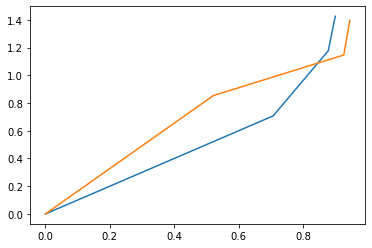

In [153]:
# choose joint angles in degrees for verifying accuracy of Neural Network predicted joint angles
q1 = 45
q2 = 25
q3 = 15

# Blue is the correct/true configuration based solely on the forward kinematics and orange is the NN predicted configuration
FKCheck(q1,q2,q3, modelBM)

# Trained Model Accuracy Visualization

1/1 [==============================] - 0s 77ms/step
End-Effector Error: 0.0109


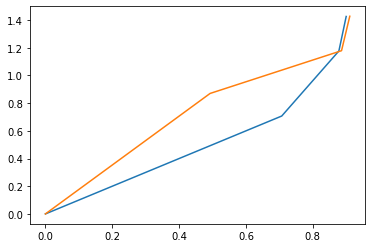

In [147]:
# Blue is the correct/true configuration based solely on the forward kinematics and orange is the NN predicted configuration
FKCheck(q1,q2,q3, model)

# The second method for accuracy visualization is path following. The model is fed the coordinates of a circle and the end-effector position is determined using the forward kinematics and the NN predicted joint angles. 

# Benchmark Circle Test

1/1 [==============================] - 0s 28ms/step


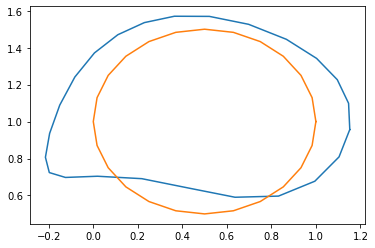

In [149]:
path = modelBM.predict(circ)
XcircE = []
YcircE = []
circX = []
circY = []

for i in range(25):  
    
    circX = np.append(circX, circ[i][0])
    circY = np.append(circY, circ[i][1])
    Xcirc, Ycirc, Acirc = ForwardKinematics(path[i][0], path[i][1], path[i][2])
    XcircE = np.append(XcircE, Xcirc[3])
    YcircE = np.append(YcircE, Ycirc[3])
    
plt.plot(XcircE, YcircE)
plt.plot(circX, circY)

# Trained Model Circle Test

1/1 [==============================] - 0s 26ms/step


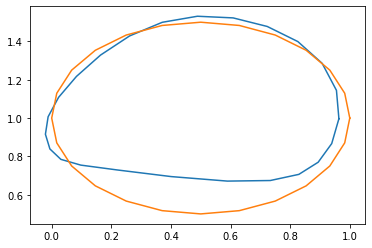

In [130]:
path = model.predict(circ)
XcircE = []
YcircE = []
circX = []
circY = []

for i in range(25):  
    
    circX = np.append(circX, circ[i][0])
    circY = np.append(circY, circ[i][1])
    Xcirc, Ycirc, Acirc = ForwardKinematics(path[i][0], path[i][1], path[i][2])
    XcircE = np.append(XcircE, Xcirc[3])
    YcircE = np.append(YcircE, Ycirc[3])
    
plt.plot(XcircE, YcircE)
plt.plot(circX, circY)

### The above plot shows that the neural network has some issues with path following. I made sure to check that the coordinates of the circle(shown in orange) are within the workspace of the robotic arm. This means that there is a theoretical configuration of joint angles which places the end-effector at each point along the circular path. Maybe there is something im not considering but for a relatively small feedforward neural network with very few augementations, the performance is quite good. 